In [1]:
import torch

import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import Adam

In [2]:
NOISE_DIM = 128
IMG_SIZE = 28
EPOCHS = 200
DISPLAY_EVERY = 1000

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def fake_labels(size):
    return torch.zeros(size, 1).to(device)

def real_labels(size):
    return torch.ones(size, 1).to(device)

def noise(batch_size):
    return torch.randn(batch_size, NOISE_DIM).to(device)

log_data = []

def log(e, E, b, B, de, ge):
    row = {
        'epoch': e, 'epochs': E,
        'batch': b, 'batches': B,
        'derror': de, 'gerror': ge,
    }

def display_logs(e, E, b, B, de, ge, dr, df, batch_size=128):
    print(f"Epoch {e+1}/{E} ({(e/E)*100:.1f}%):"
          f" [{b*batch_size}/{B*batch_size}] ({(b/B)*100:.1f}%)"
          f" D Error: {de:.4f} G Error: {ge:.4f}")

def display_images(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    count = 0
    for y in range(4):
        for x in range(4):
            img = imgs[count].view(28, 28)
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()

def imgs_to_vec(imgs, img_size=28):
    return imgs.view(imgs.size(0), img_size * img_size)

def vec_to_imgs(vec):
    return vec.view(vec.size(0), 1, 28, 28)

In [5]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
test_set = datasets.MNIST(root='./data/', train=False, download=False, transform=transform)

data = train_set + test_set

data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [11]:
class DiscriminatorModel(nn.Module):
    """ 3 hidden layer discriminative nn. """
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(IMG_SIZE * IMG_SIZE, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
class GeneratorModel(nn.Module):
    """ 3 hidden layer generative nn. """
    def __init__(self, batch_size=128):
        super(GeneratorModel, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(batch_size, 256),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(1024, IMG_SIZE * IMG_SIZE),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [28]:
def train_discriminator(model, optimizer, loss_fn, real_inputs, fake_inputs):
    optimizer.zero_grad()
    
    real_outputs = model(real_inputs)
    labels = real_labels(real_inputs.size(0))

    loss_real = loss_fn(real_outputs, labels)
    loss_real.backward()

    fake_outputs = model(fake_inputs)
    labels = fake_labels(fake_inputs.size(0))

    loss_fake = loss_fn(fake_outputs, labels)
    loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake, real_outputs, fake_outputs
    

In [29]:
def train_generator(dmodel, optimizer, loss_fn, fake_outputs):
    optimizer.zero_grad()
    outputs = dmodel(fake_outputs)
    labels = real_labels(fake_outputs.size(0))

    loss = loss_fn(outputs, labels)
    loss.backward()
    
    optimizer.step()

    return loss

In [26]:
NUM_BATCHES = len(data_loader)
num_samples = 16
torch.manual_seed(1)
test_noise = noise(num_samples)
test_noise

tensor([[-1.5256, -0.7502, -0.6540,  ...,  1.7986,  0.1018,  0.3400],
        [ 0.7124, -1.7765,  0.3539,  ..., -1.1797, -0.0908,  0.5631],
        [-1.2560,  0.8956,  0.1675,  ...,  0.4209, -1.0214,  0.9886],
        ...,
        [ 0.9927, -1.2597, -0.7705,  ...,  0.4246,  0.3852, -1.2694],
        [ 0.4554, -1.2638,  0.2165,  ...,  0.3109, -0.4731, -0.8671],
        [ 0.4252, -0.1734,  1.4066,  ...,  0.5313,  0.1559,  0.1716]],
       device='cuda:0')

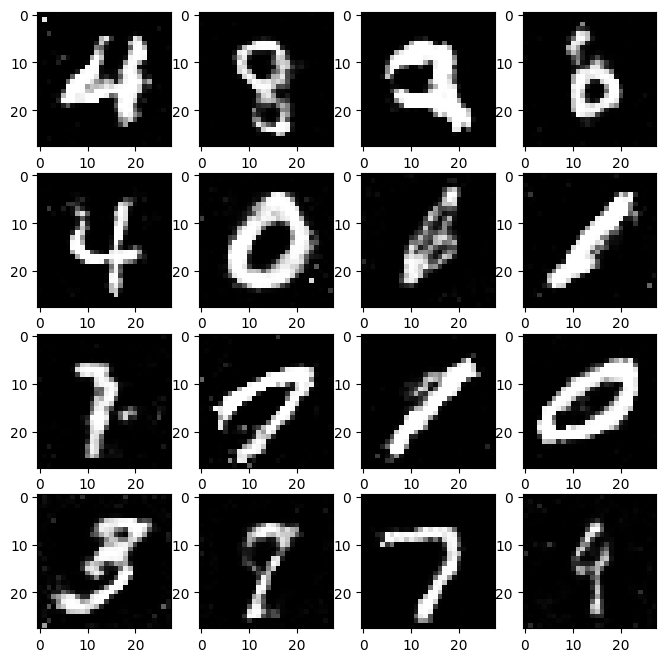

Epoch 1/200 (0.0%): [0/70016] (0.0%) D Error: 1.3667 G Error: 0.8325


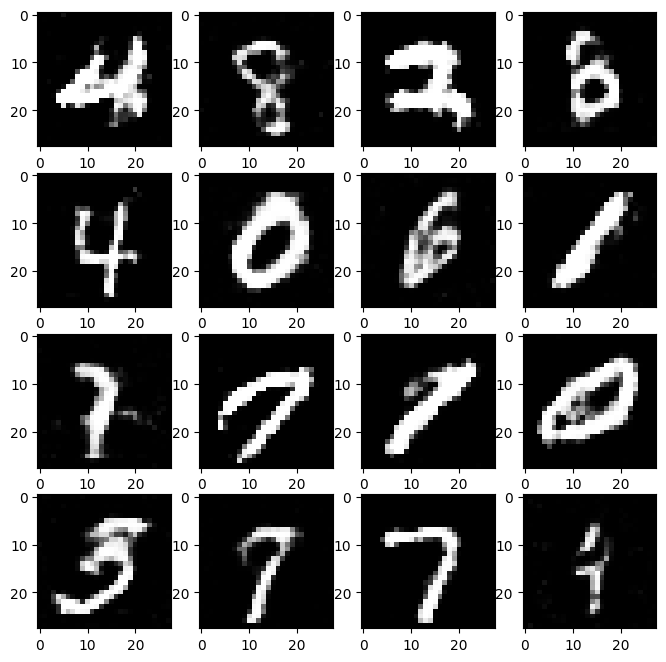

Epoch 2/200 (0.5%): [0/70016] (0.0%) D Error: 1.3128 G Error: 0.8130


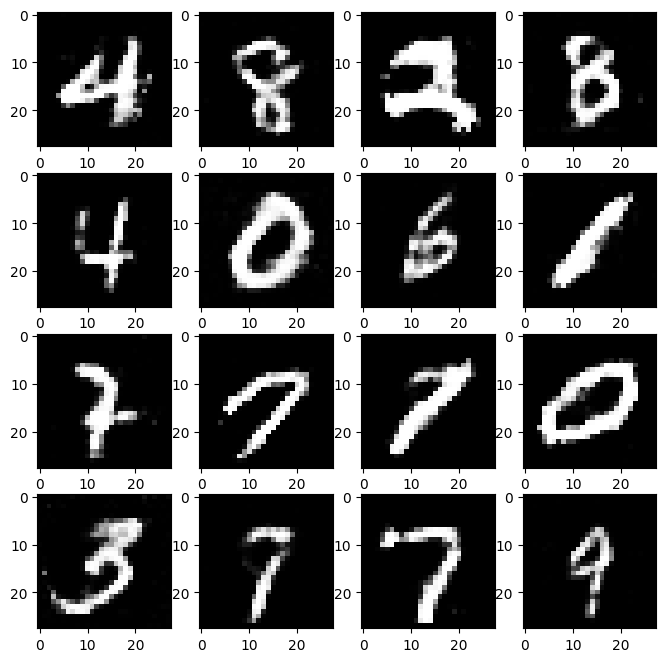

Epoch 3/200 (1.0%): [0/70016] (0.0%) D Error: 1.2592 G Error: 0.8459


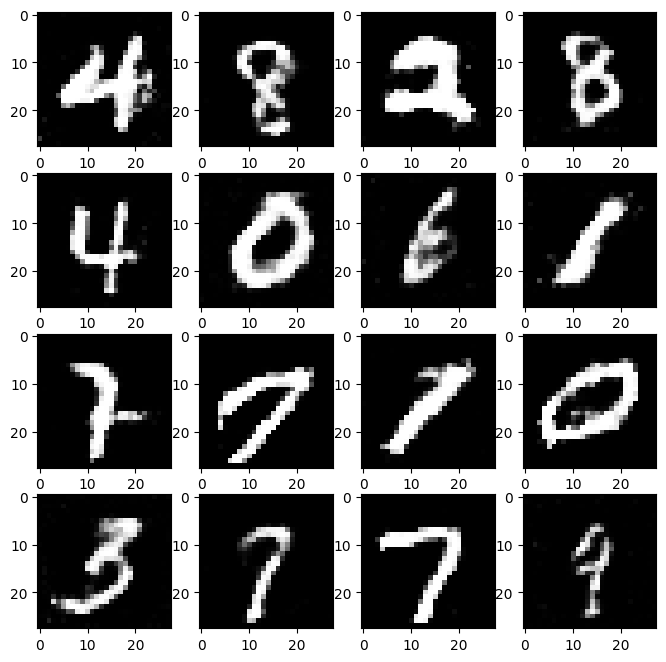

Epoch 4/200 (1.5%): [0/70016] (0.0%) D Error: 1.4193 G Error: 0.8721


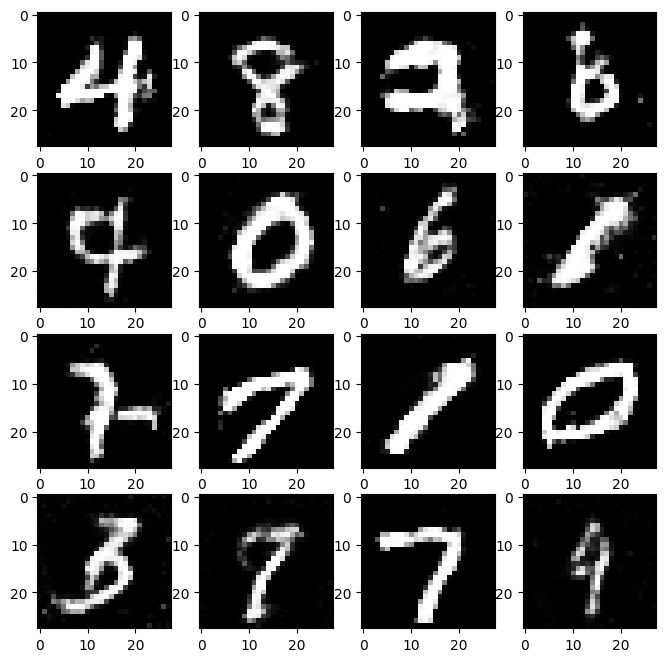

Epoch 5/200 (2.0%): [0/70016] (0.0%) D Error: 1.3069 G Error: 0.8937


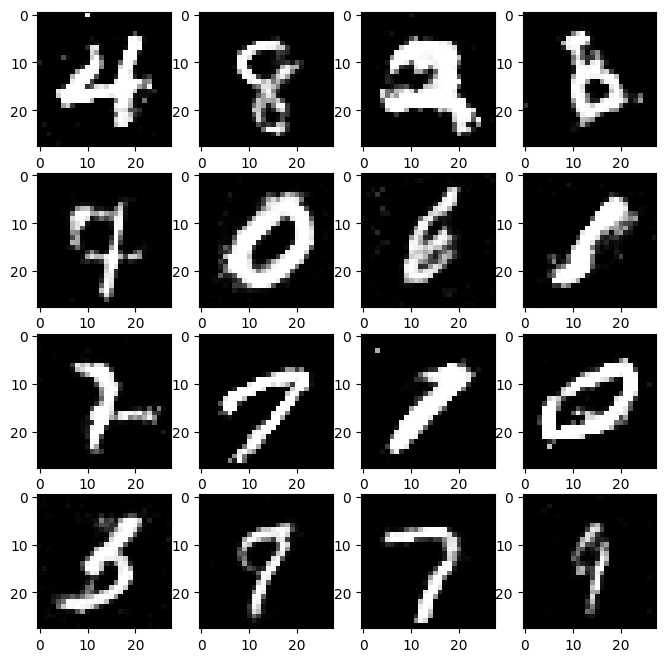

Epoch 6/200 (2.5%): [0/70016] (0.0%) D Error: 1.1816 G Error: 0.9706


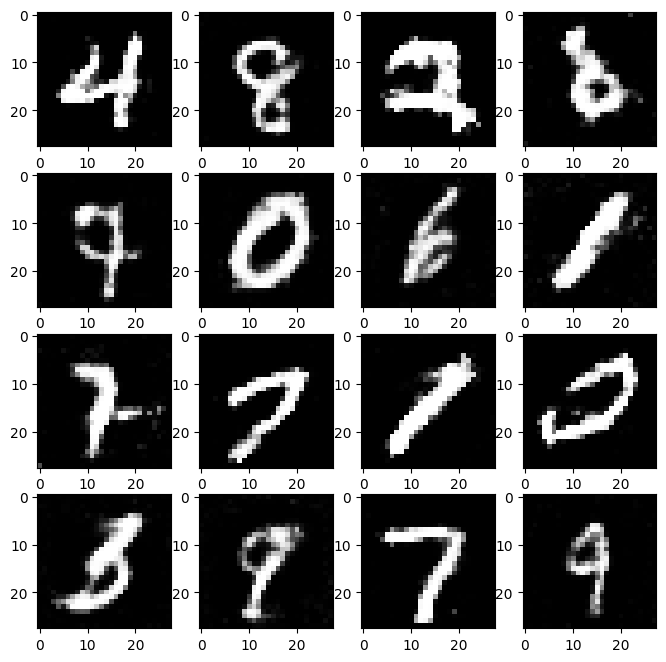

Epoch 7/200 (3.0%): [0/70016] (0.0%) D Error: 1.3817 G Error: 0.9002


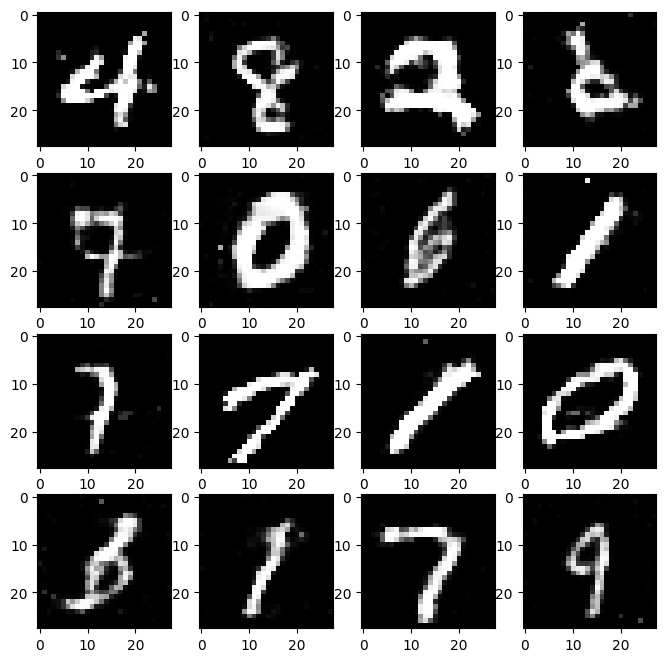

Epoch 8/200 (3.5%): [0/70016] (0.0%) D Error: 1.3137 G Error: 0.9693


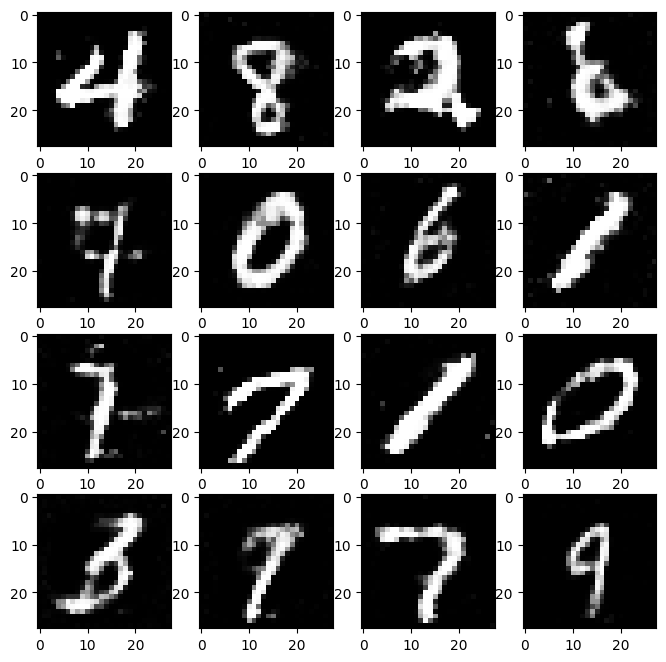

Epoch 9/200 (4.0%): [0/70016] (0.0%) D Error: 1.0933 G Error: 1.0202


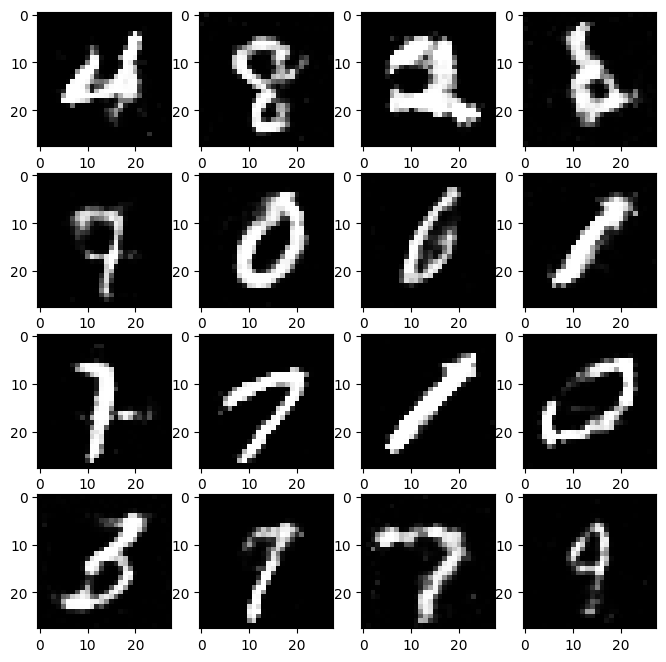

Epoch 10/200 (4.5%): [0/70016] (0.0%) D Error: 1.3156 G Error: 0.8327


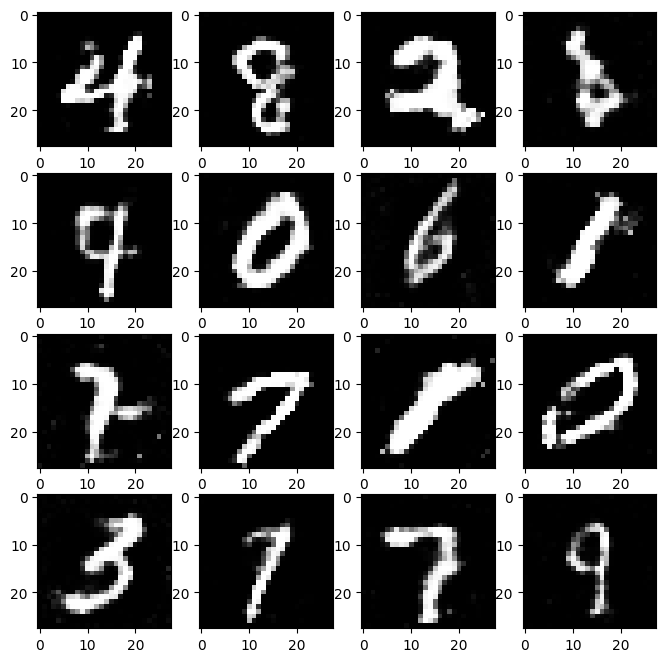

Epoch 11/200 (5.0%): [0/70016] (0.0%) D Error: 1.2585 G Error: 0.8383


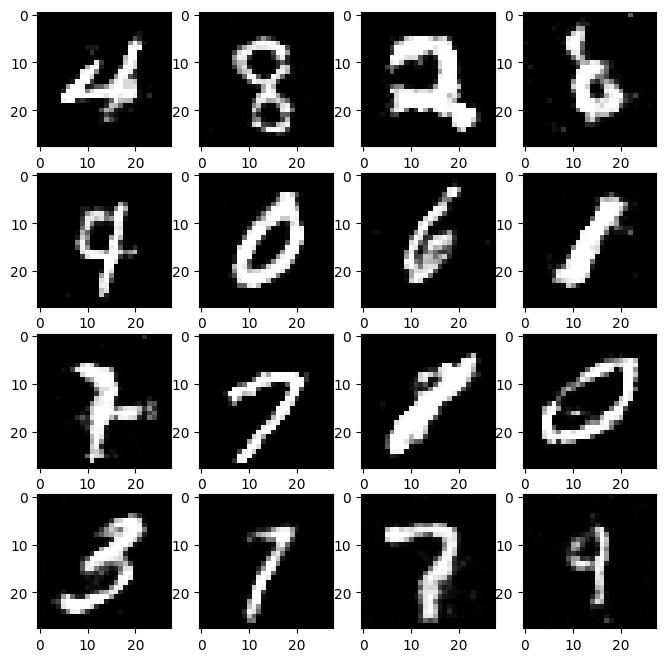

Epoch 12/200 (5.5%): [0/70016] (0.0%) D Error: 1.3514 G Error: 0.8667


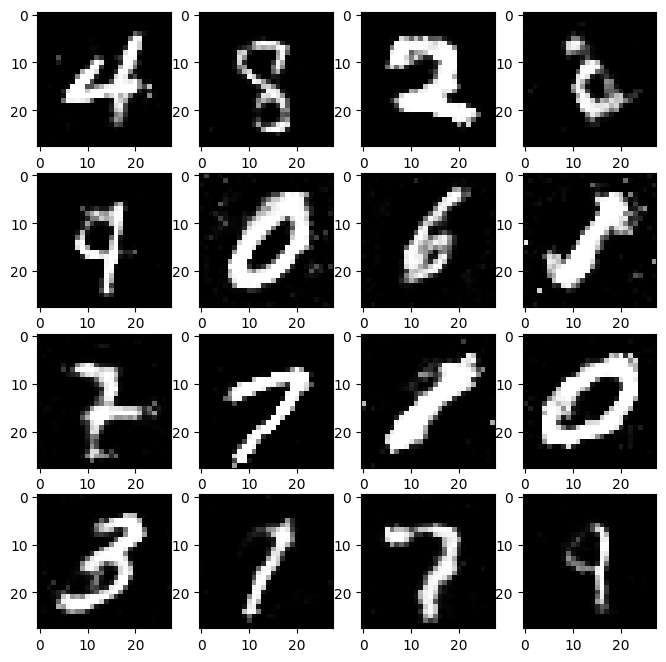

Epoch 13/200 (6.0%): [0/70016] (0.0%) D Error: 1.2653 G Error: 0.8203


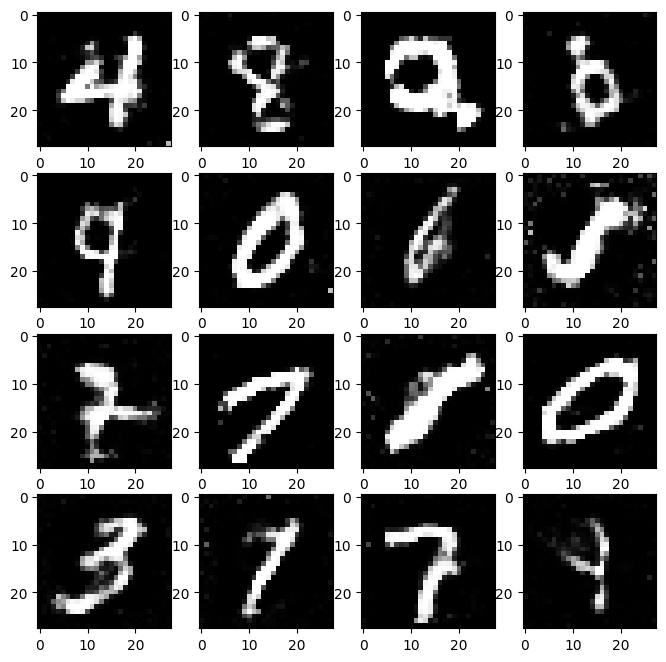

Epoch 14/200 (6.5%): [0/70016] (0.0%) D Error: 1.2331 G Error: 0.8934


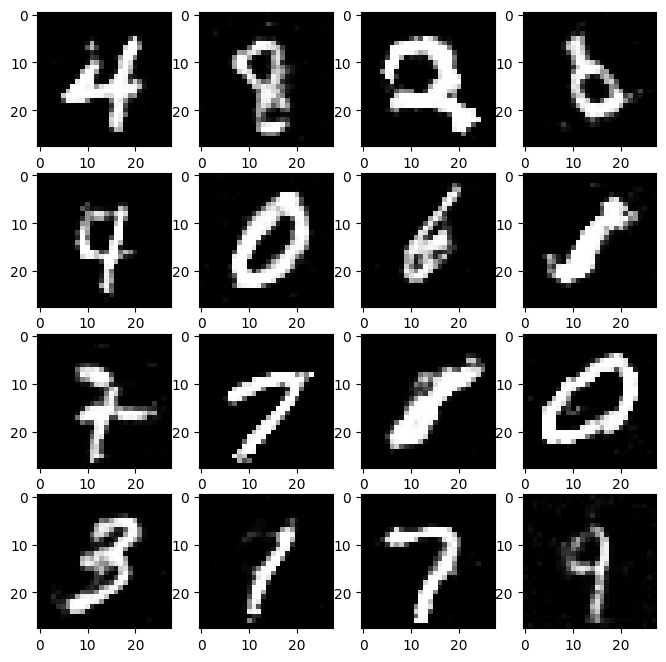

Epoch 15/200 (7.0%): [0/70016] (0.0%) D Error: 1.3007 G Error: 0.8572


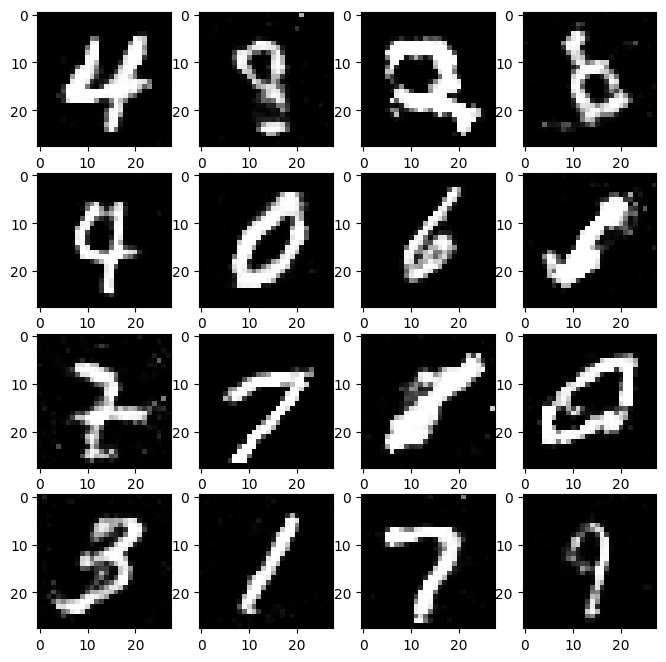

Epoch 16/200 (7.5%): [0/70016] (0.0%) D Error: 1.2939 G Error: 0.8291


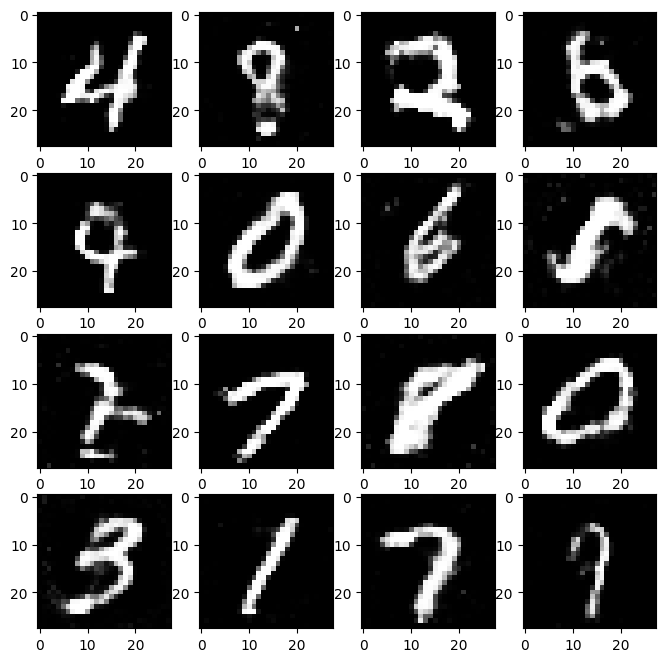

Epoch 17/200 (8.0%): [0/70016] (0.0%) D Error: 1.2471 G Error: 0.8534


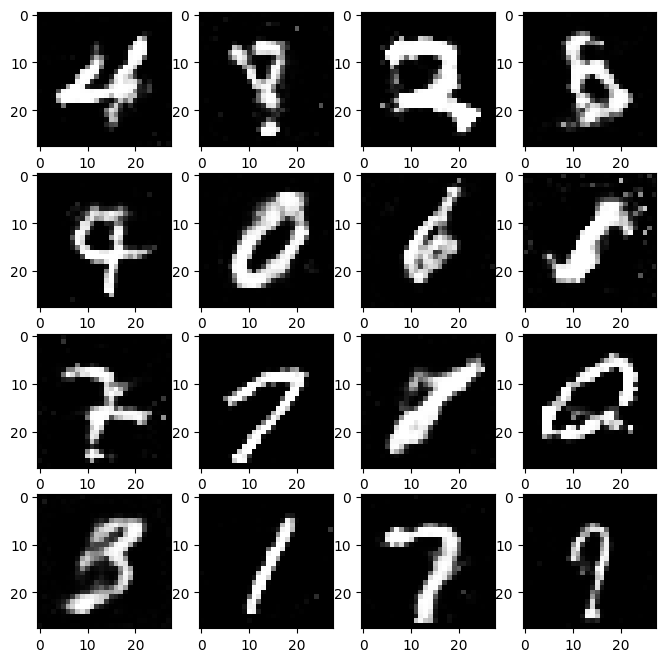

Epoch 18/200 (8.5%): [0/70016] (0.0%) D Error: 1.2802 G Error: 0.9408


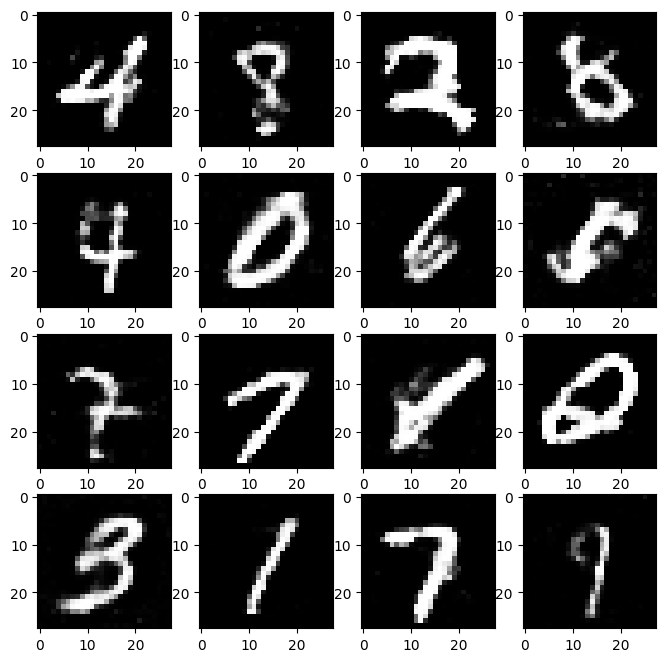

Epoch 19/200 (9.0%): [0/70016] (0.0%) D Error: 1.3159 G Error: 0.7862


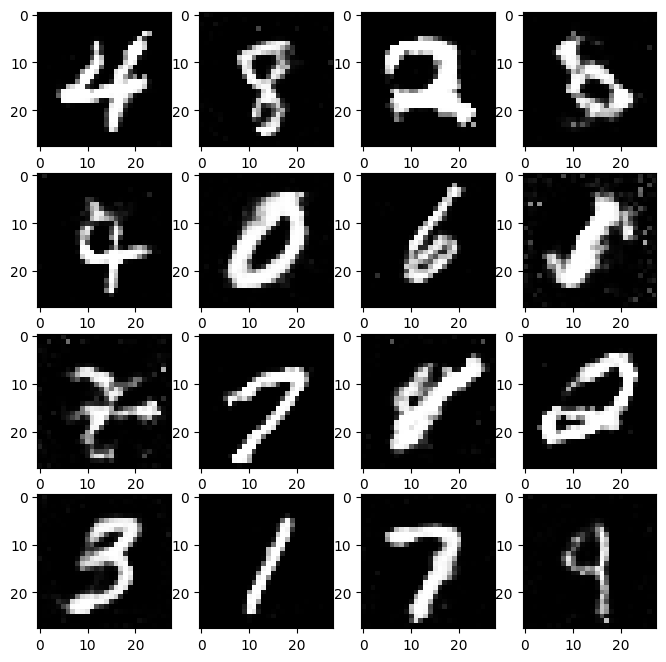

Epoch 20/200 (9.5%): [0/70016] (0.0%) D Error: 1.2853 G Error: 0.8080


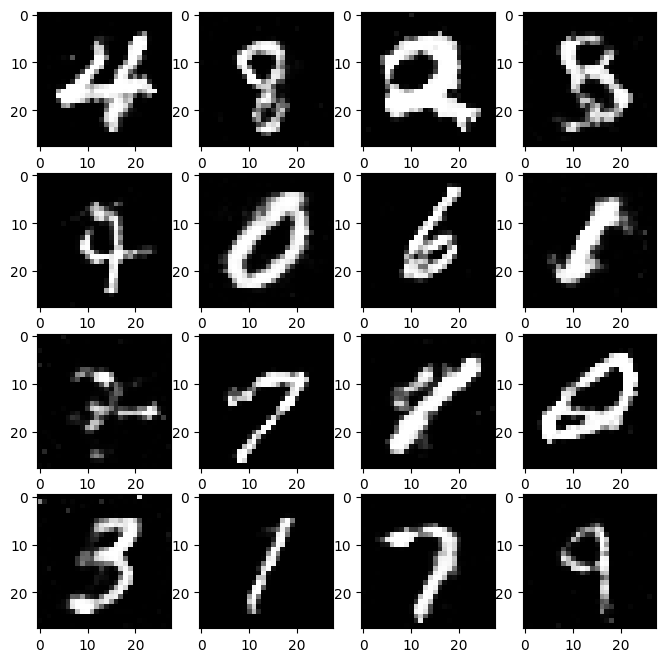

Epoch 21/200 (10.0%): [0/70016] (0.0%) D Error: 1.4036 G Error: 0.7898


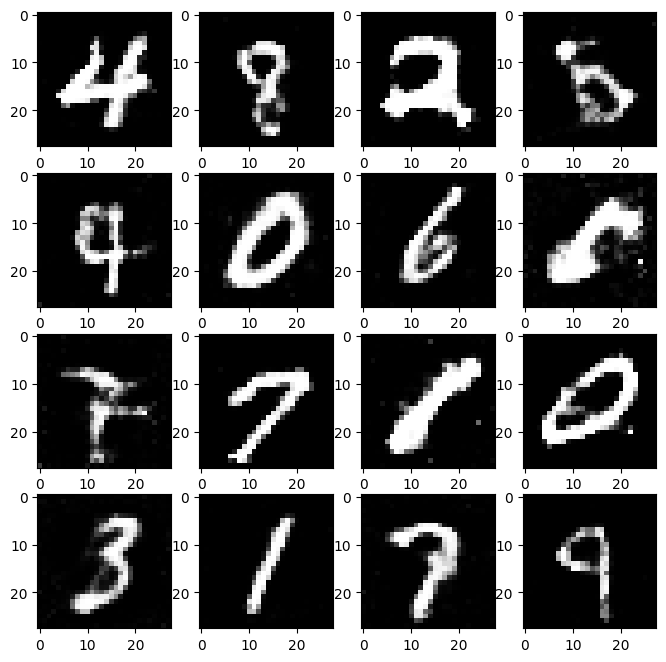

Epoch 22/200 (10.5%): [0/70016] (0.0%) D Error: 1.2725 G Error: 0.8522


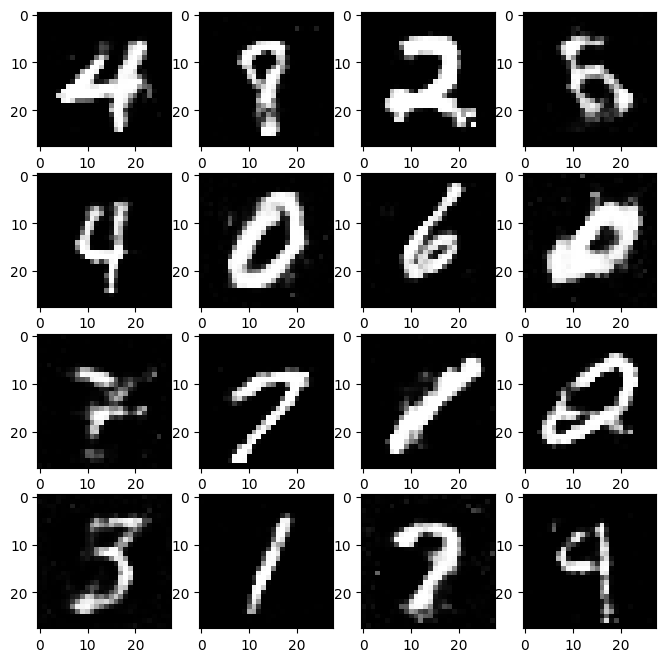

Epoch 23/200 (11.0%): [0/70016] (0.0%) D Error: 1.2440 G Error: 0.8773


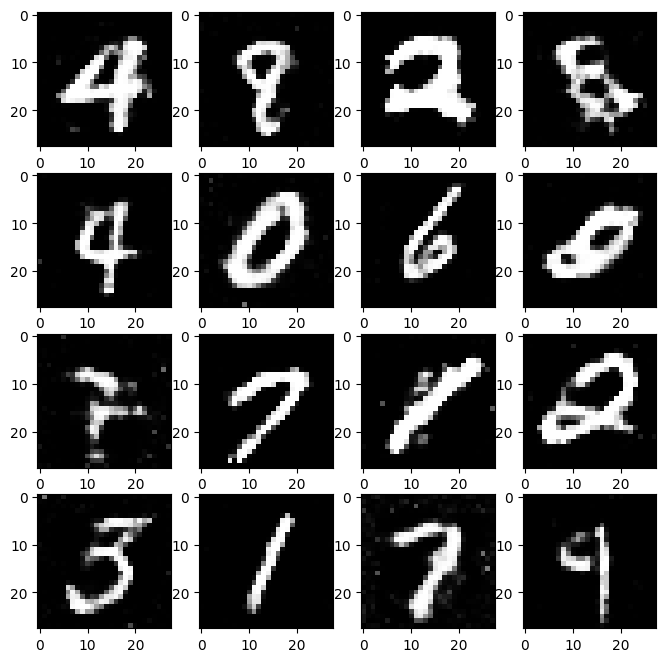

Epoch 24/200 (11.5%): [0/70016] (0.0%) D Error: 1.3588 G Error: 0.8276


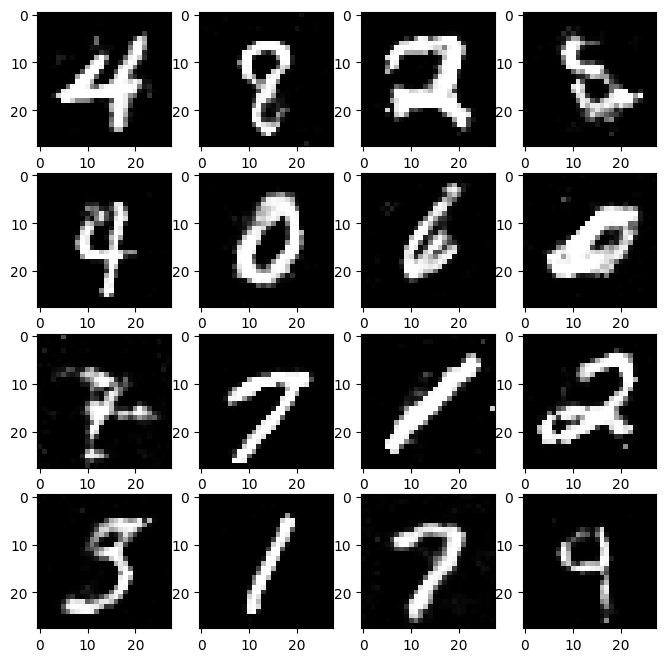

Epoch 25/200 (12.0%): [0/70016] (0.0%) D Error: 1.3242 G Error: 0.8081


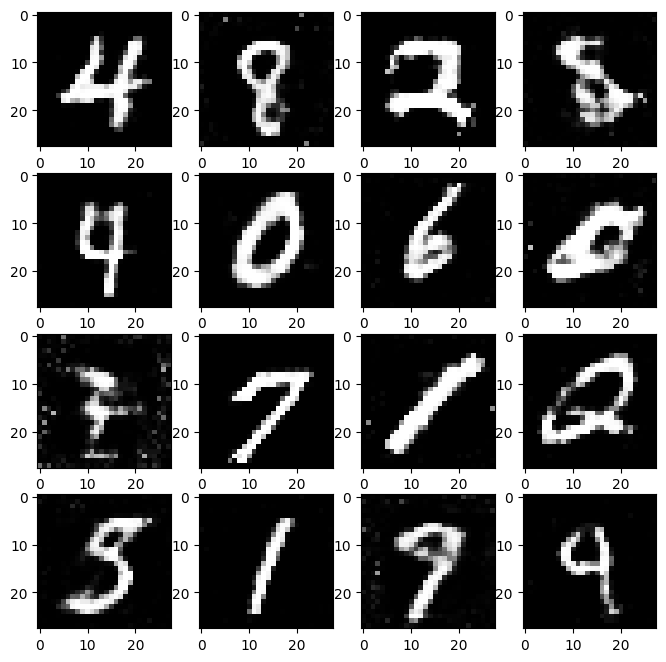

Epoch 26/200 (12.5%): [0/70016] (0.0%) D Error: 1.3685 G Error: 0.8856


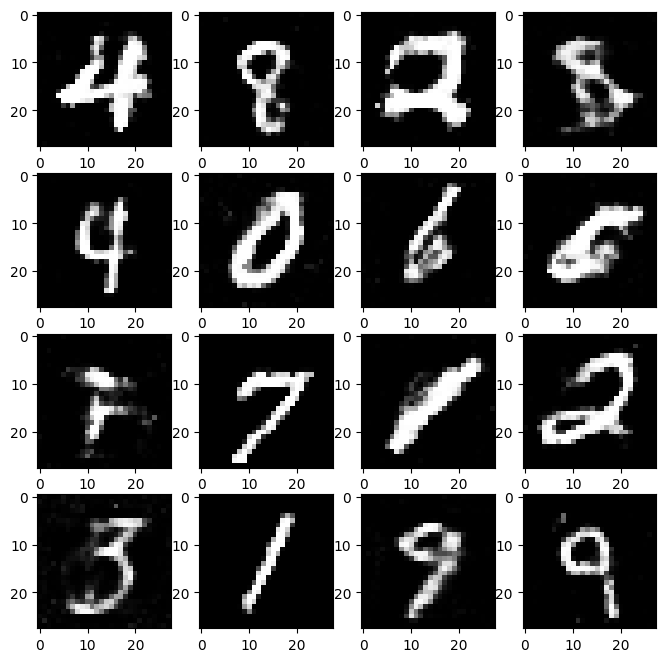

Epoch 27/200 (13.0%): [0/70016] (0.0%) D Error: 1.3195 G Error: 0.9021


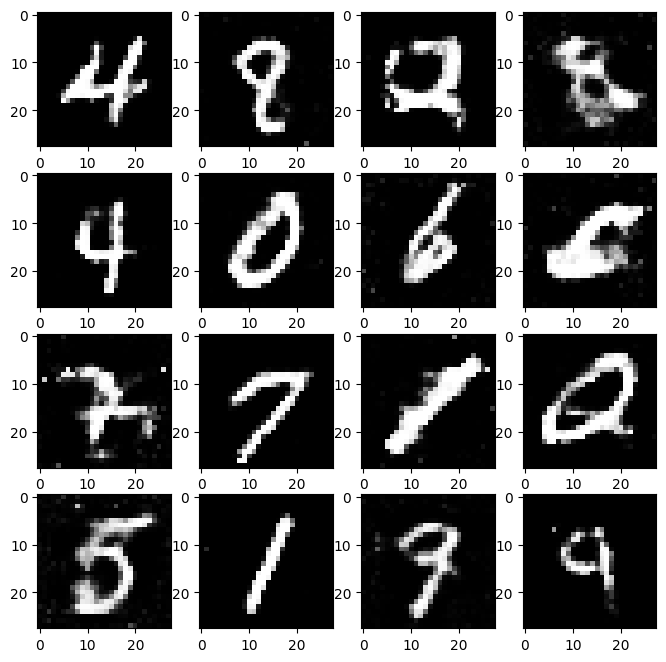

Epoch 28/200 (13.5%): [0/70016] (0.0%) D Error: 1.3995 G Error: 0.8397


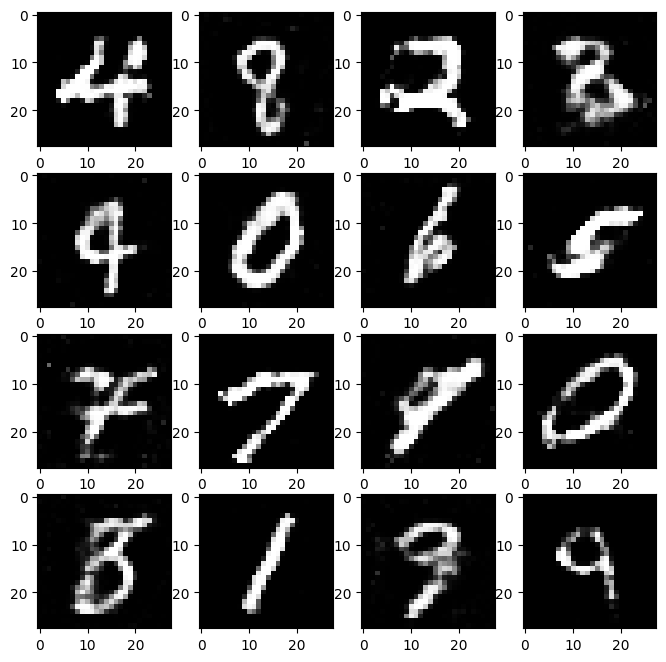

Epoch 29/200 (14.0%): [0/70016] (0.0%) D Error: 1.2422 G Error: 0.9358


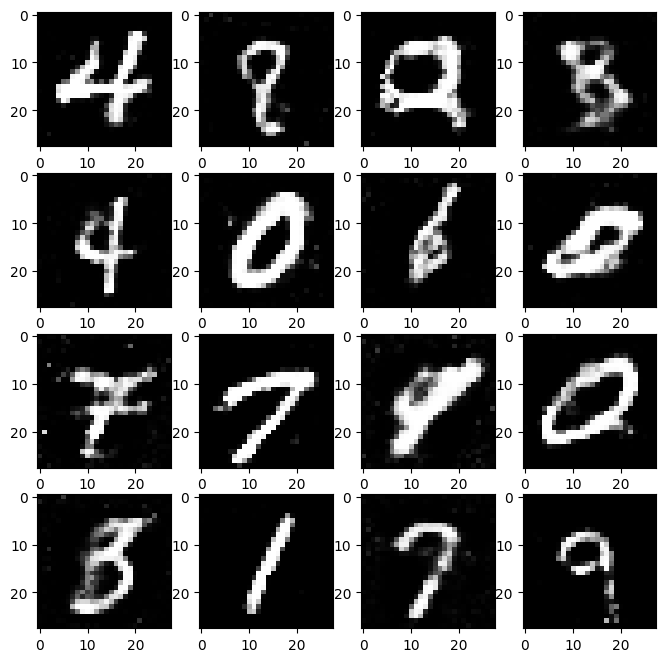

Epoch 30/200 (14.5%): [0/70016] (0.0%) D Error: 1.2929 G Error: 0.9248


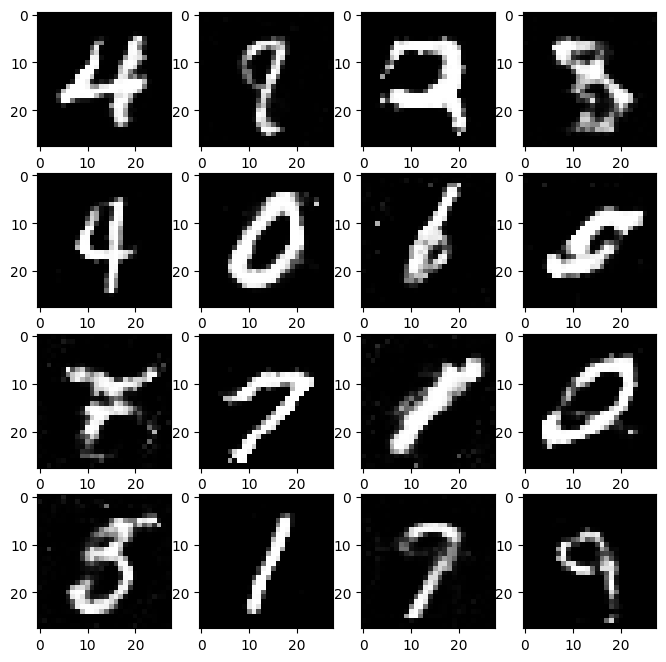

Epoch 31/200 (15.0%): [0/70016] (0.0%) D Error: 1.3742 G Error: 0.7383


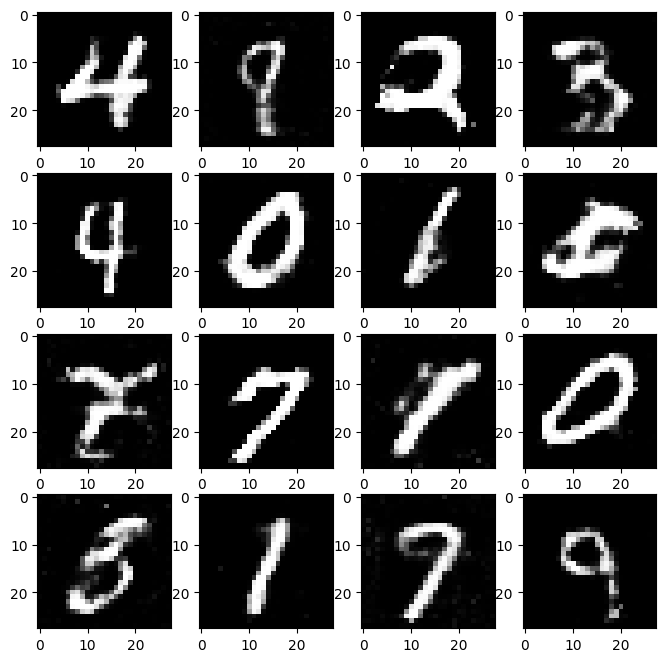

Epoch 32/200 (15.5%): [0/70016] (0.0%) D Error: 1.2673 G Error: 1.0064


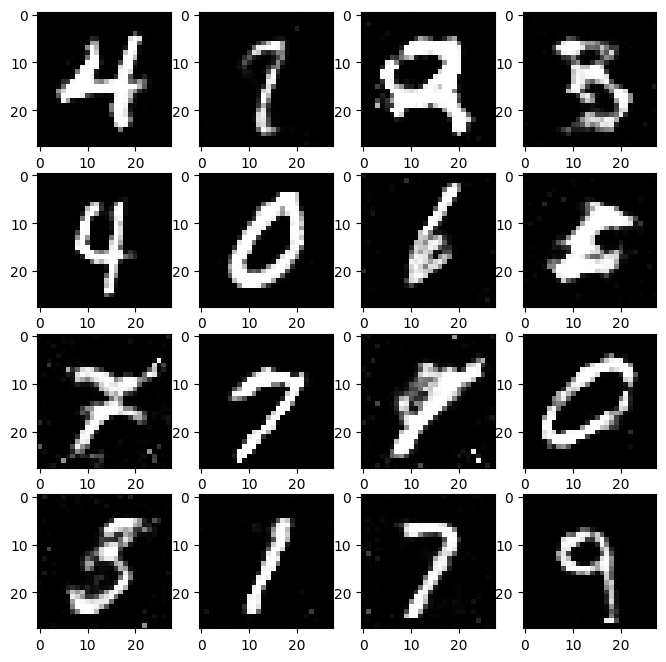

Epoch 33/200 (16.0%): [0/70016] (0.0%) D Error: 1.2432 G Error: 0.9417


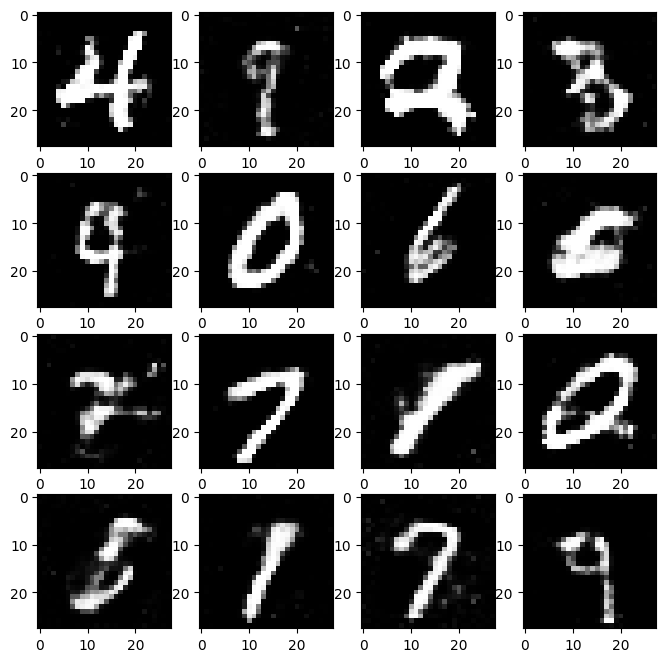

Epoch 34/200 (16.5%): [0/70016] (0.0%) D Error: 1.2590 G Error: 0.9575


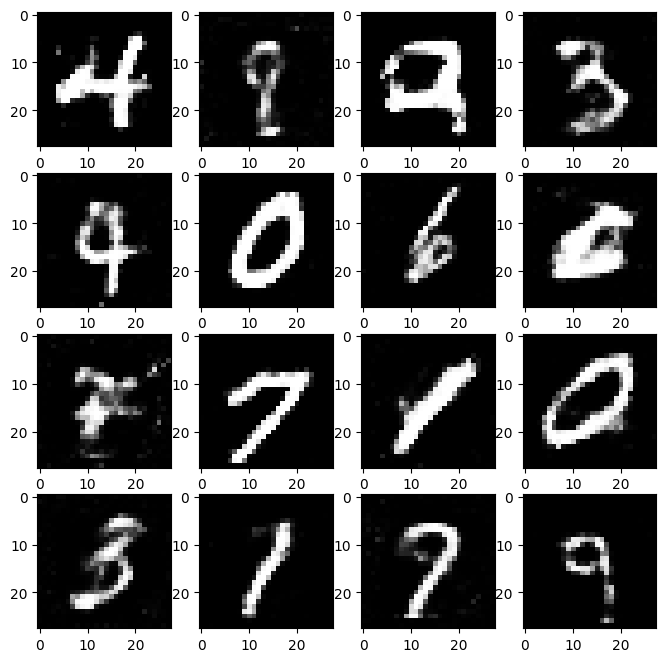

Epoch 35/200 (17.0%): [0/70016] (0.0%) D Error: 1.1850 G Error: 0.8828


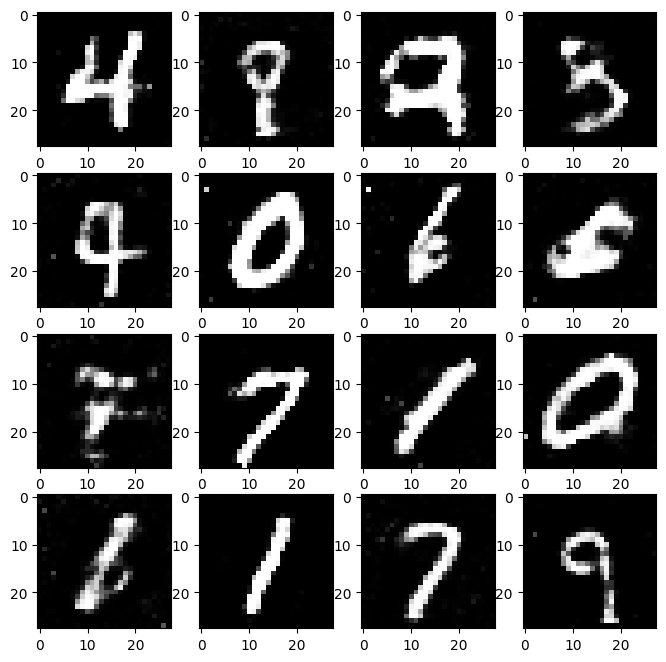

Epoch 36/200 (17.5%): [0/70016] (0.0%) D Error: 1.3066 G Error: 0.7624


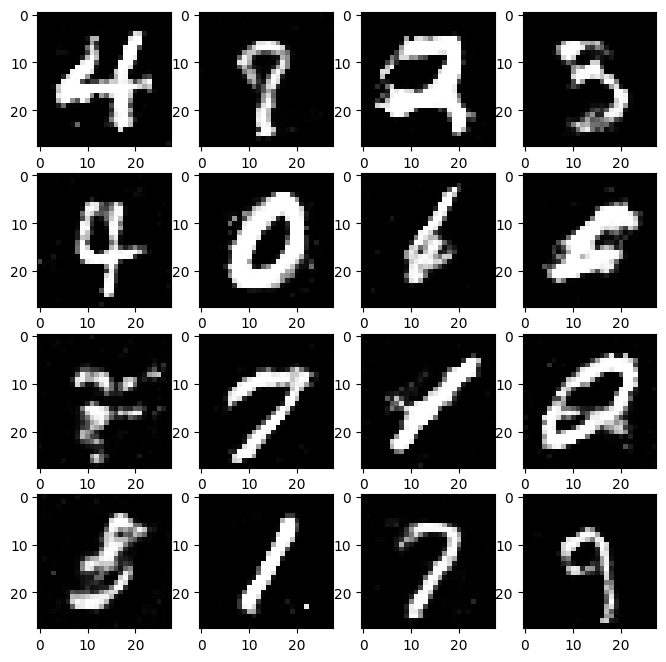

Epoch 37/200 (18.0%): [0/70016] (0.0%) D Error: 1.3199 G Error: 0.7844


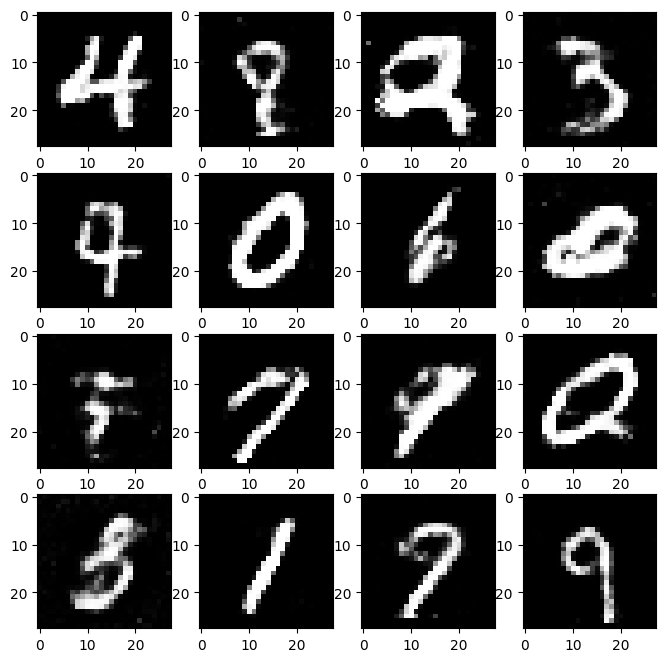

Epoch 38/200 (18.5%): [0/70016] (0.0%) D Error: 1.2714 G Error: 0.8266


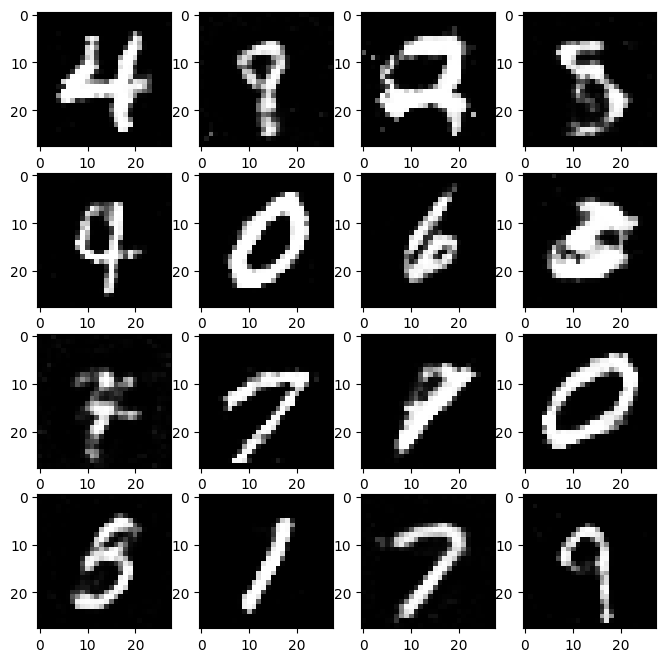

Epoch 39/200 (19.0%): [0/70016] (0.0%) D Error: 1.2399 G Error: 0.8474


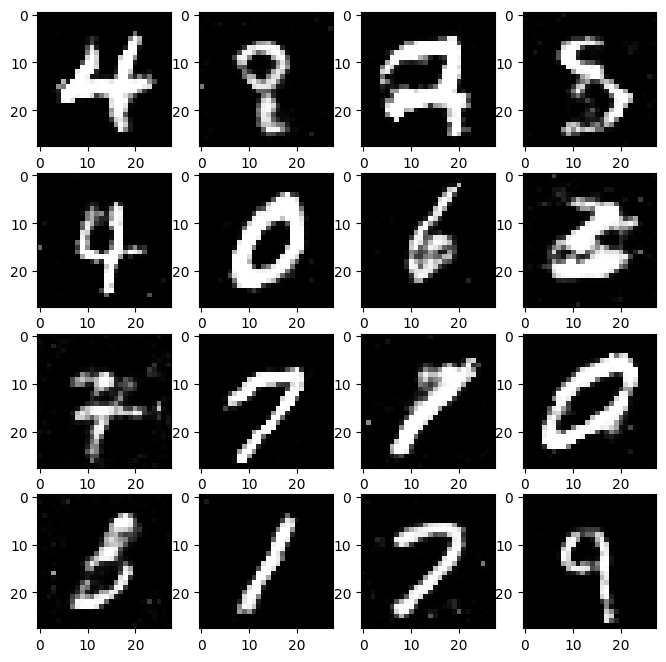

Epoch 40/200 (19.5%): [0/70016] (0.0%) D Error: 1.2598 G Error: 0.8327


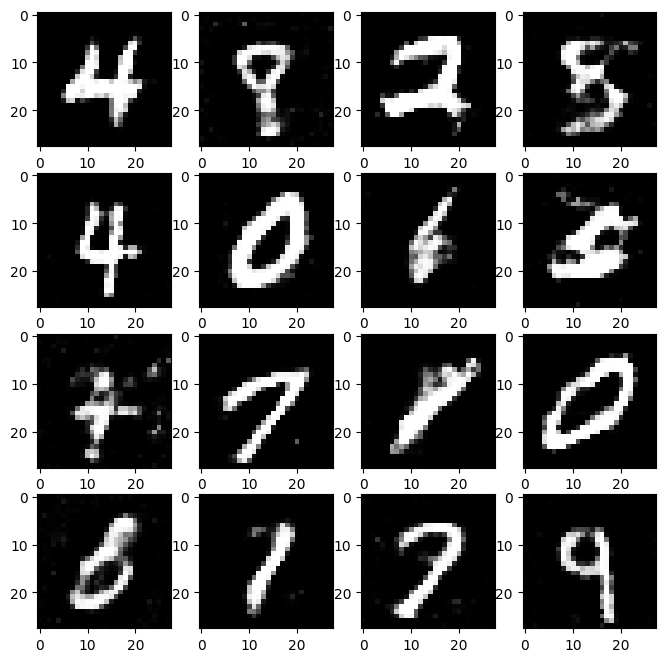

Epoch 41/200 (20.0%): [0/70016] (0.0%) D Error: 1.2587 G Error: 0.9050


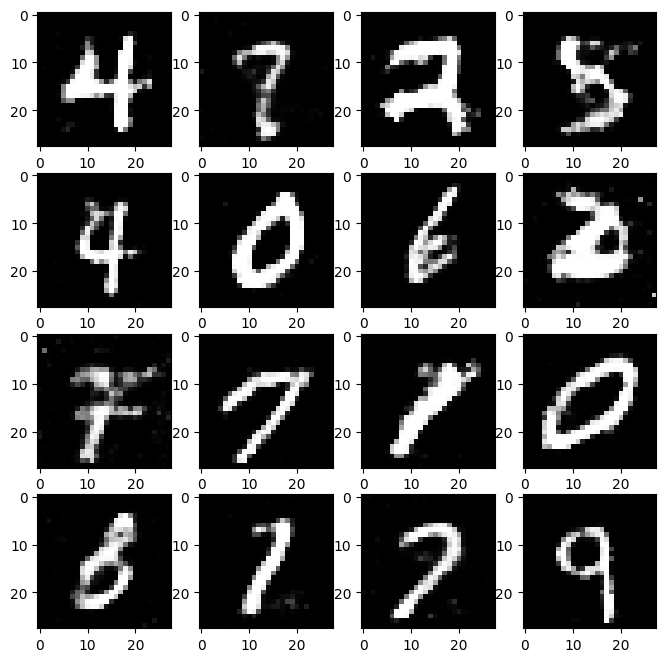

Epoch 42/200 (20.5%): [0/70016] (0.0%) D Error: 1.4139 G Error: 0.9420


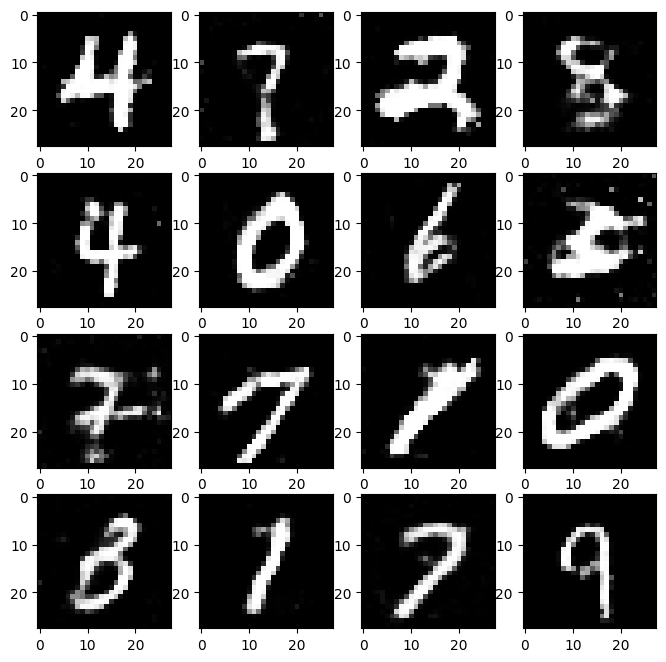

Epoch 43/200 (21.0%): [0/70016] (0.0%) D Error: 1.3213 G Error: 0.8507


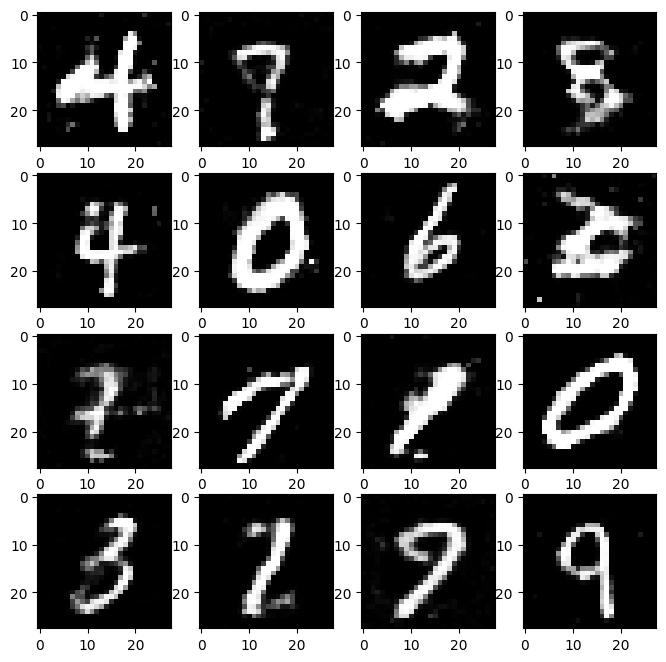

Epoch 44/200 (21.5%): [0/70016] (0.0%) D Error: 1.3864 G Error: 0.7578


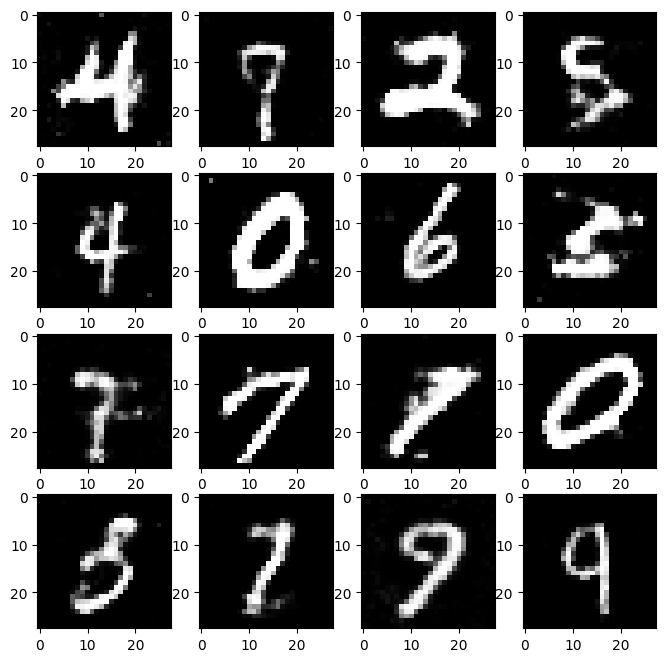

Epoch 45/200 (22.0%): [0/70016] (0.0%) D Error: 1.2141 G Error: 0.8330


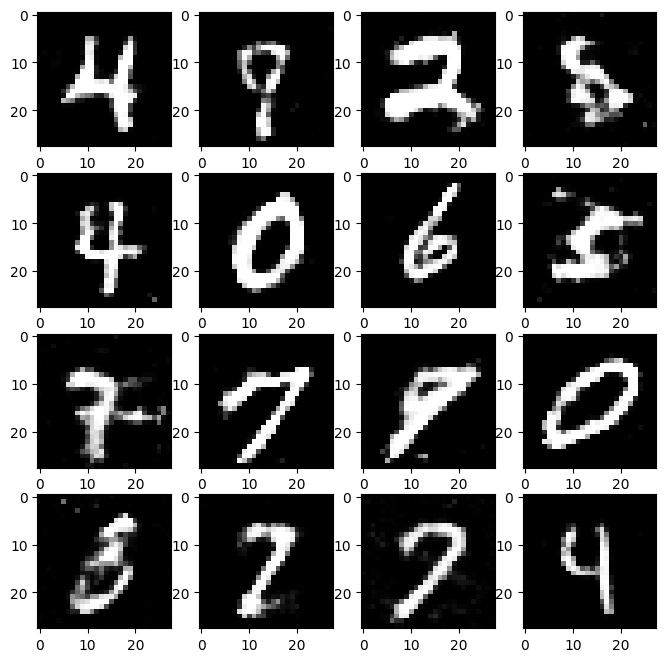

Epoch 46/200 (22.5%): [0/70016] (0.0%) D Error: 1.2985 G Error: 0.8501


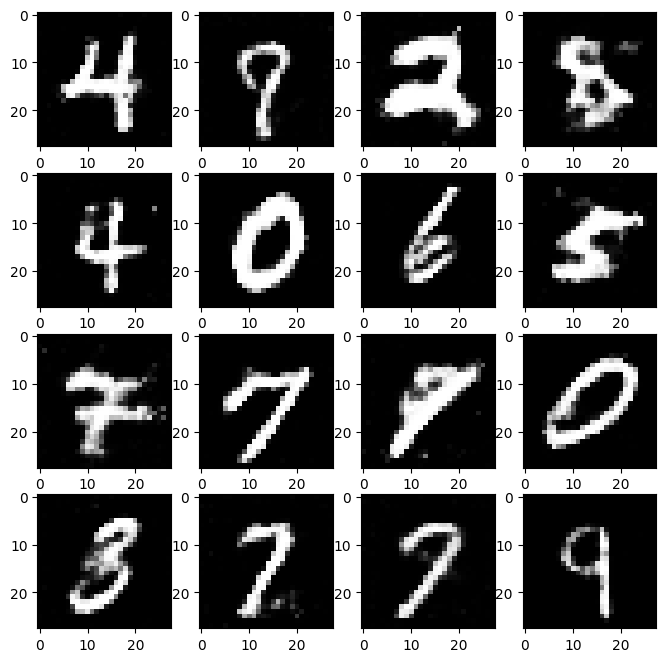

Epoch 47/200 (23.0%): [0/70016] (0.0%) D Error: 1.2454 G Error: 0.8478


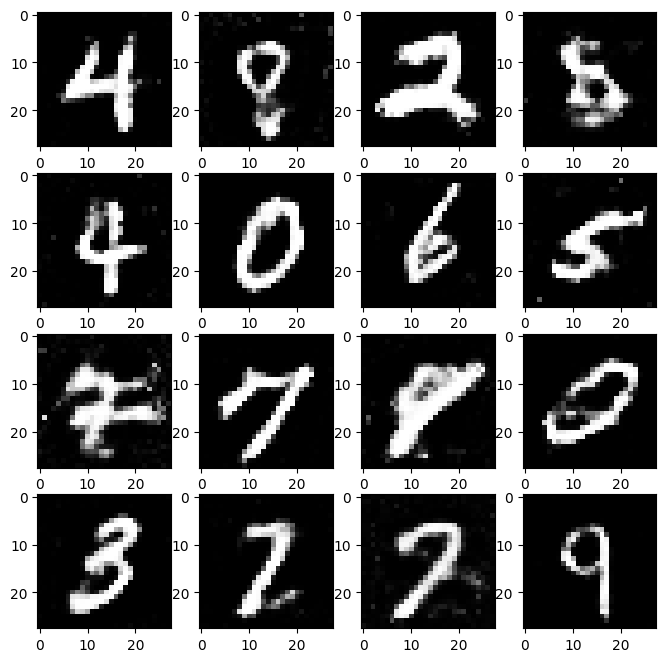

Epoch 48/200 (23.5%): [0/70016] (0.0%) D Error: 1.3479 G Error: 0.7470


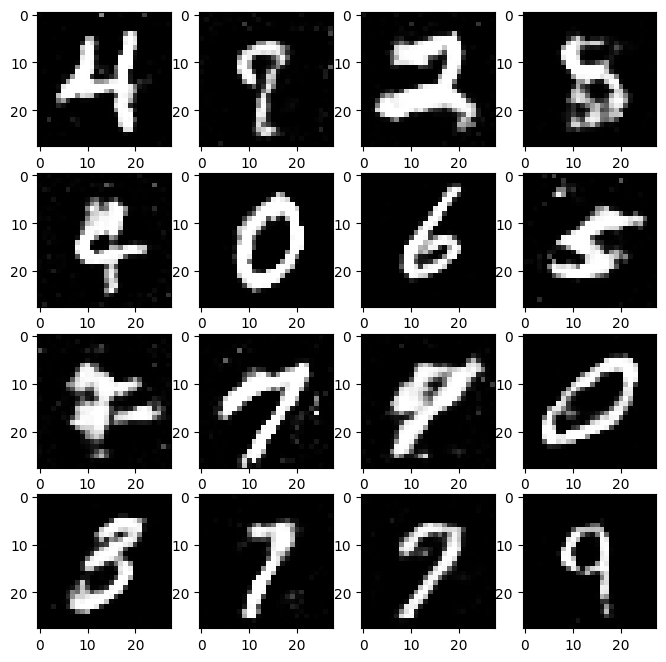

Epoch 49/200 (24.0%): [0/70016] (0.0%) D Error: 1.2980 G Error: 0.8628


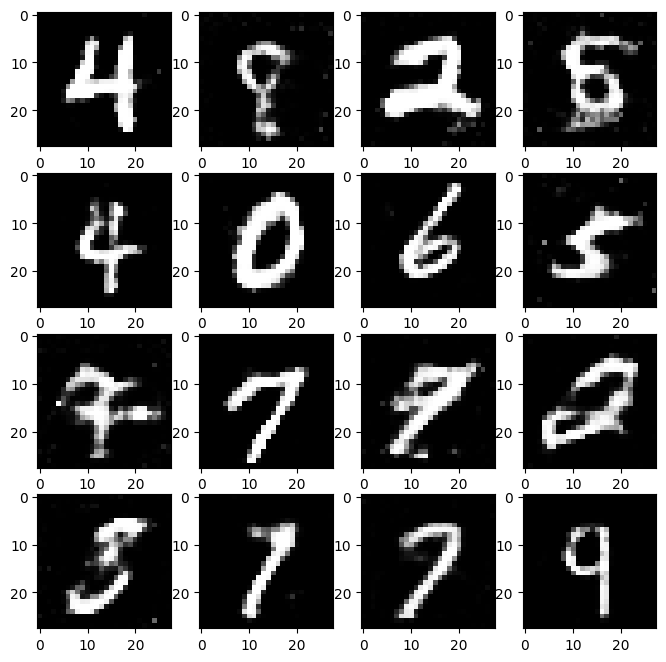

Epoch 50/200 (24.5%): [0/70016] (0.0%) D Error: 1.3181 G Error: 0.8027


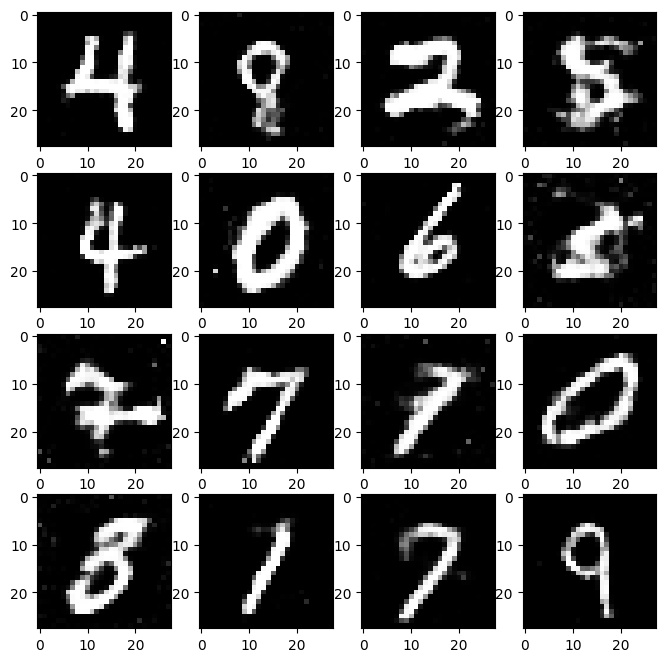

Epoch 51/200 (25.0%): [0/70016] (0.0%) D Error: 1.2175 G Error: 0.8166


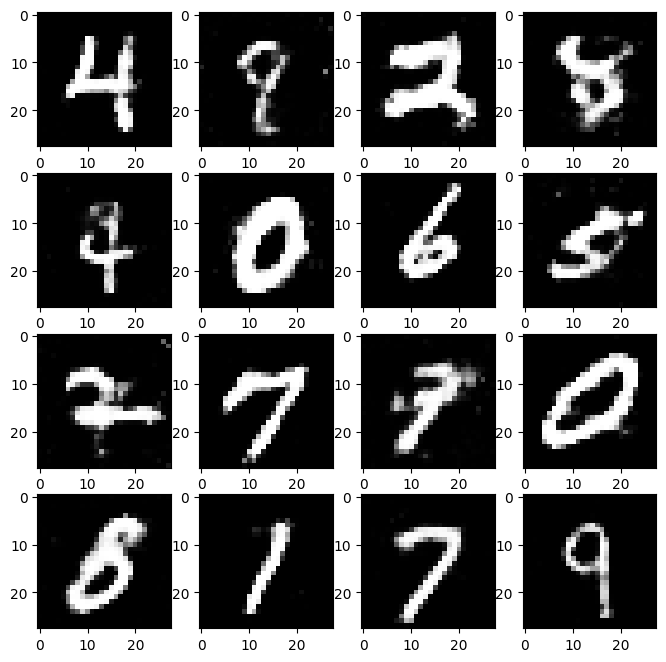

Epoch 52/200 (25.5%): [0/70016] (0.0%) D Error: 1.2713 G Error: 0.9530


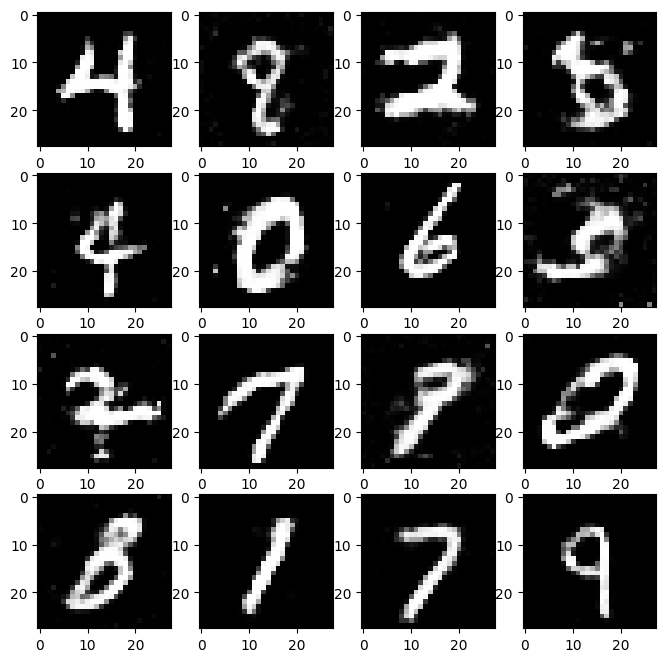

Epoch 53/200 (26.0%): [0/70016] (0.0%) D Error: 1.2862 G Error: 0.9020


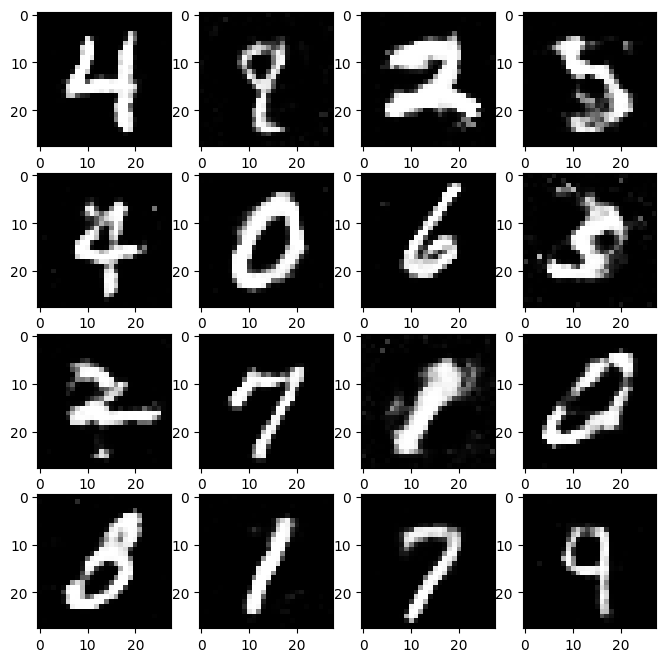

Epoch 54/200 (26.5%): [0/70016] (0.0%) D Error: 1.2524 G Error: 0.8921


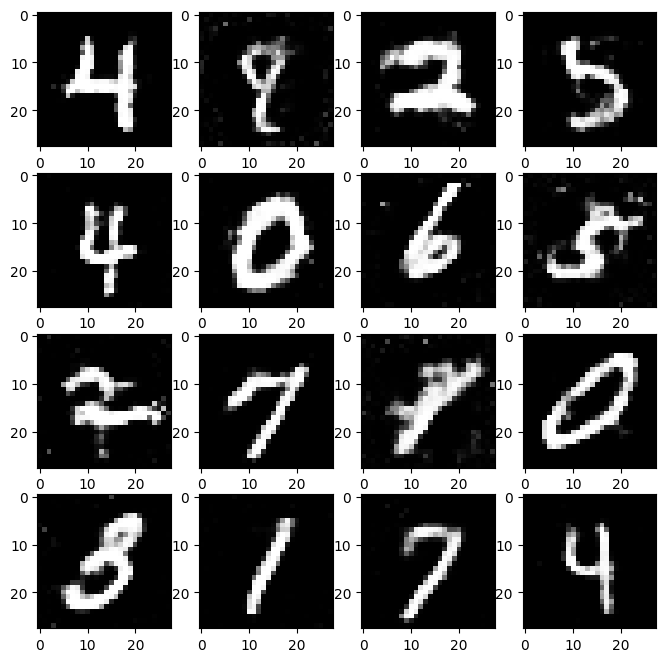

Epoch 55/200 (27.0%): [0/70016] (0.0%) D Error: 1.2803 G Error: 0.8768


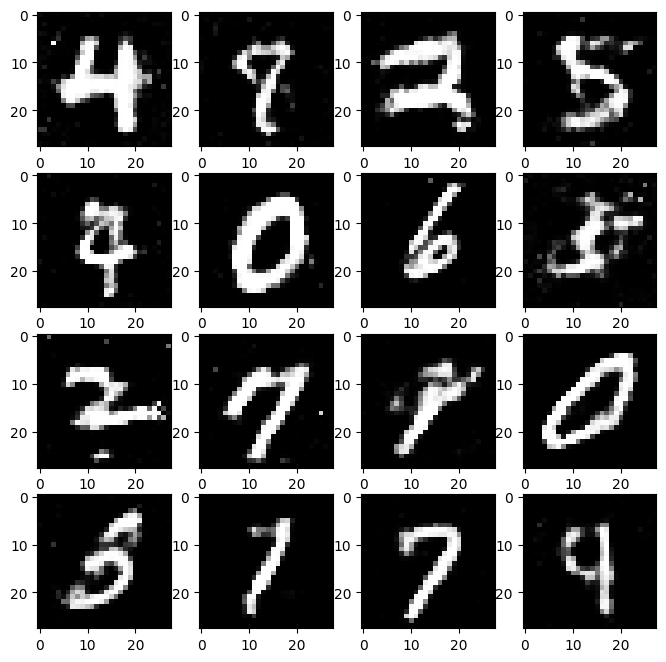

Epoch 56/200 (27.5%): [0/70016] (0.0%) D Error: 1.3090 G Error: 0.8019


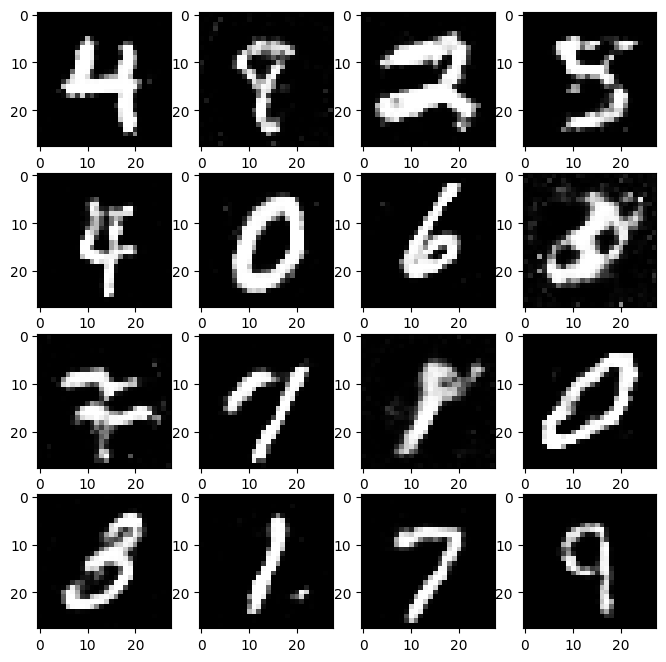

Epoch 57/200 (28.0%): [0/70016] (0.0%) D Error: 1.2323 G Error: 0.8835


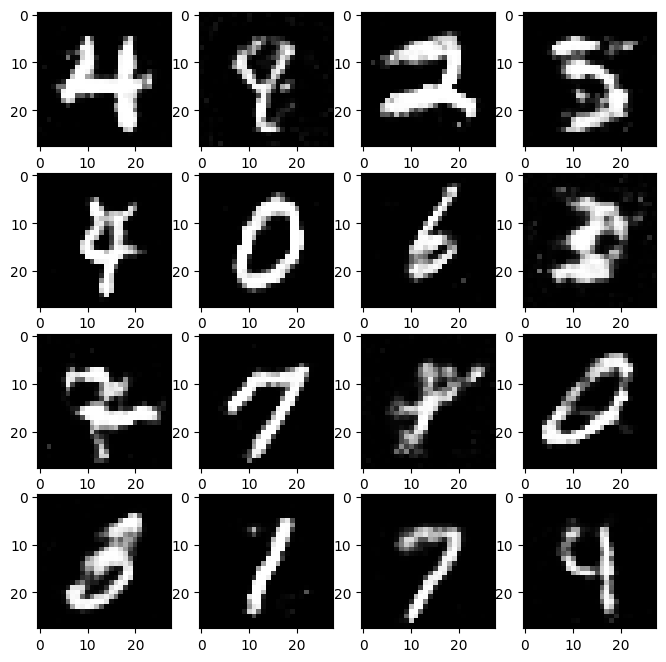

Epoch 58/200 (28.5%): [0/70016] (0.0%) D Error: 1.3067 G Error: 0.8560


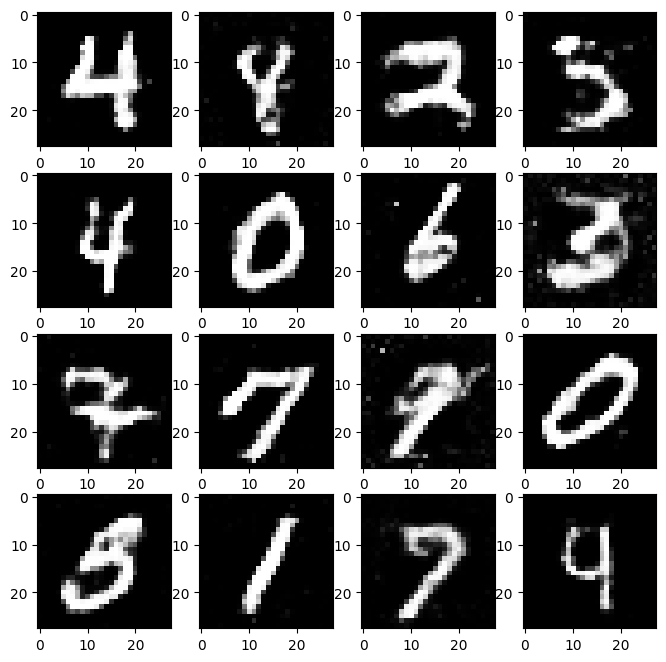

Epoch 59/200 (29.0%): [0/70016] (0.0%) D Error: 1.2937 G Error: 0.8215


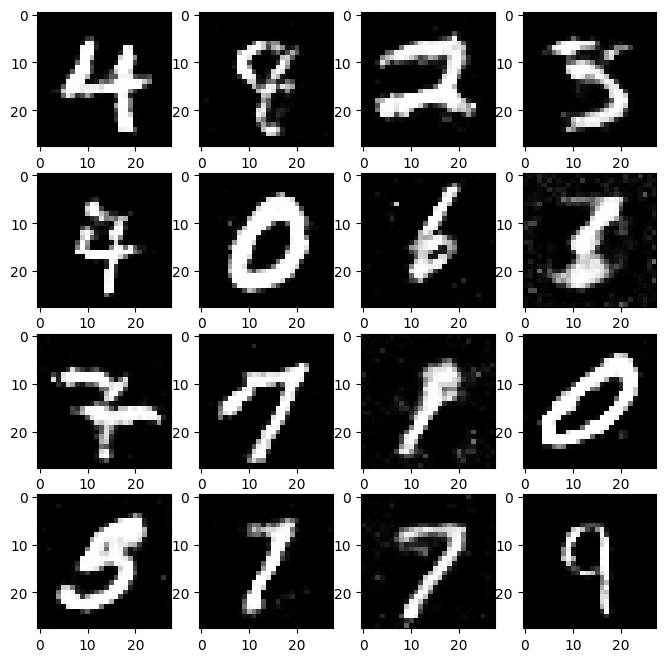

Epoch 60/200 (29.5%): [0/70016] (0.0%) D Error: 1.3823 G Error: 0.7514


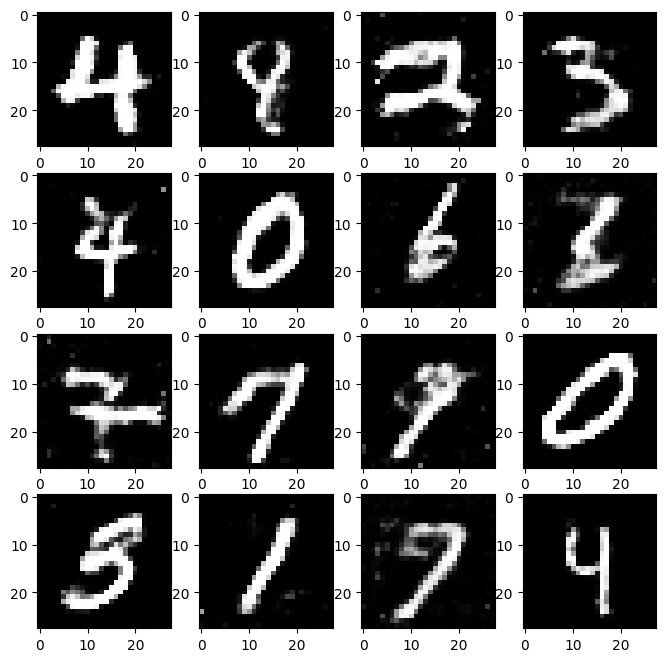

Epoch 61/200 (30.0%): [0/70016] (0.0%) D Error: 1.2693 G Error: 0.8537


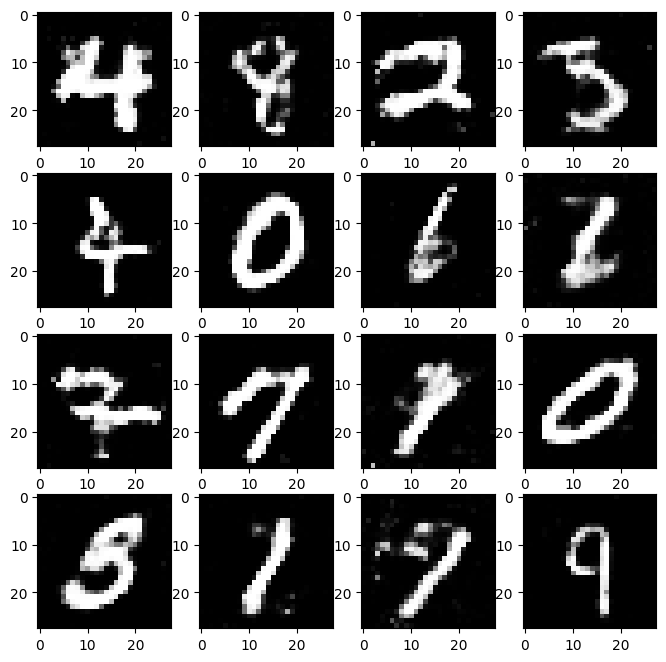

Epoch 62/200 (30.5%): [0/70016] (0.0%) D Error: 1.3248 G Error: 0.8370


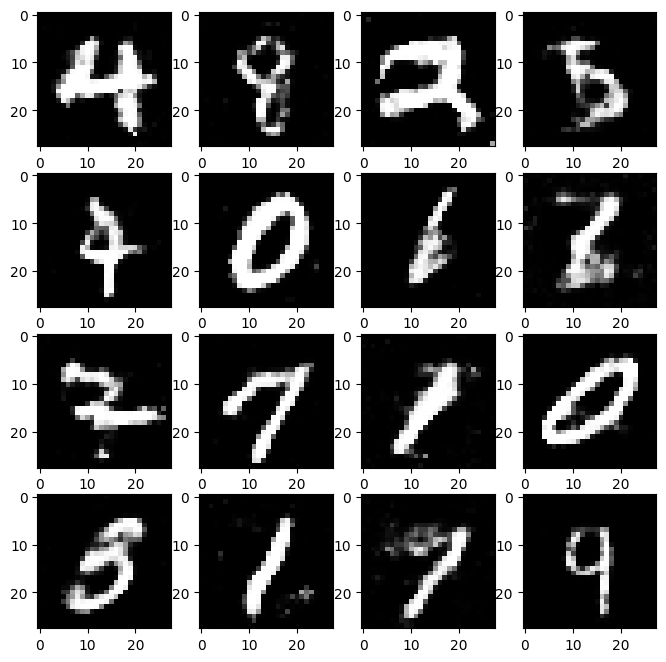

Epoch 63/200 (31.0%): [0/70016] (0.0%) D Error: 1.2895 G Error: 0.8378


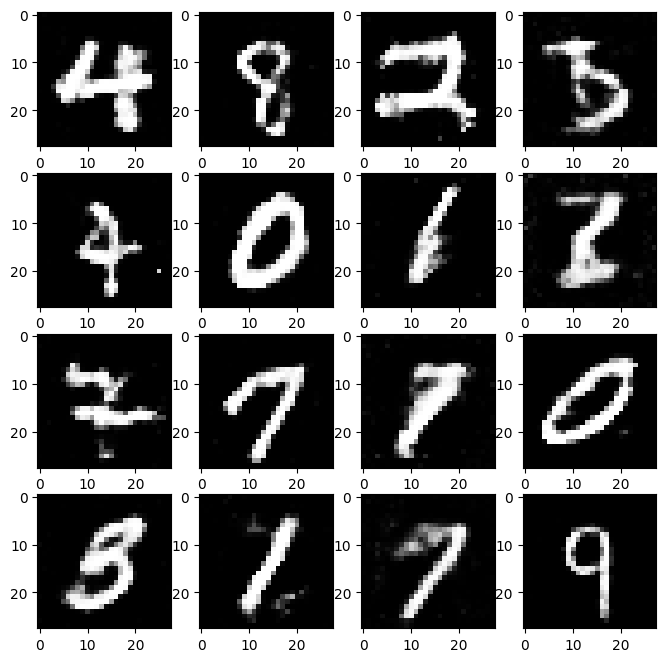

Epoch 64/200 (31.5%): [0/70016] (0.0%) D Error: 1.3604 G Error: 0.9212


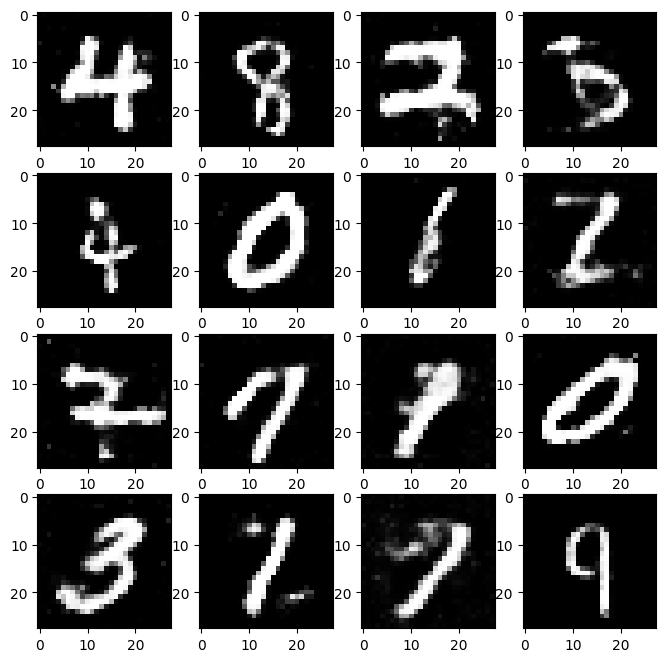

Epoch 65/200 (32.0%): [0/70016] (0.0%) D Error: 1.3921 G Error: 0.8863


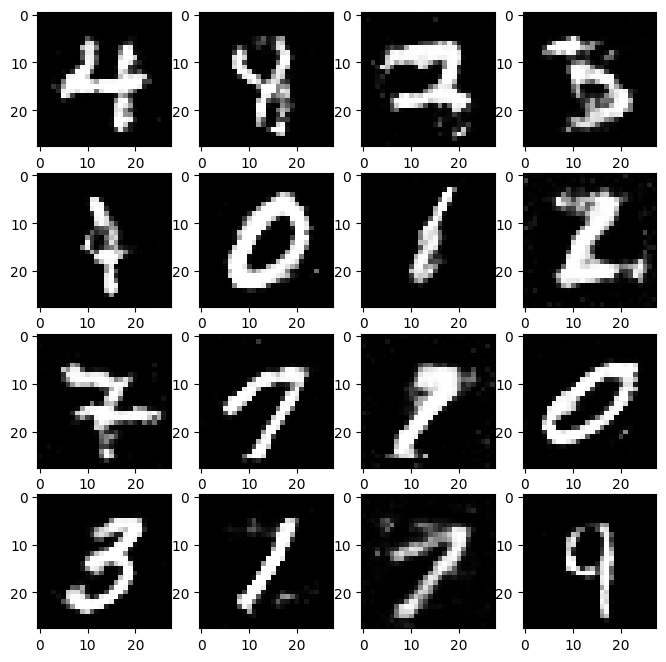

Epoch 66/200 (32.5%): [0/70016] (0.0%) D Error: 1.4365 G Error: 0.8628


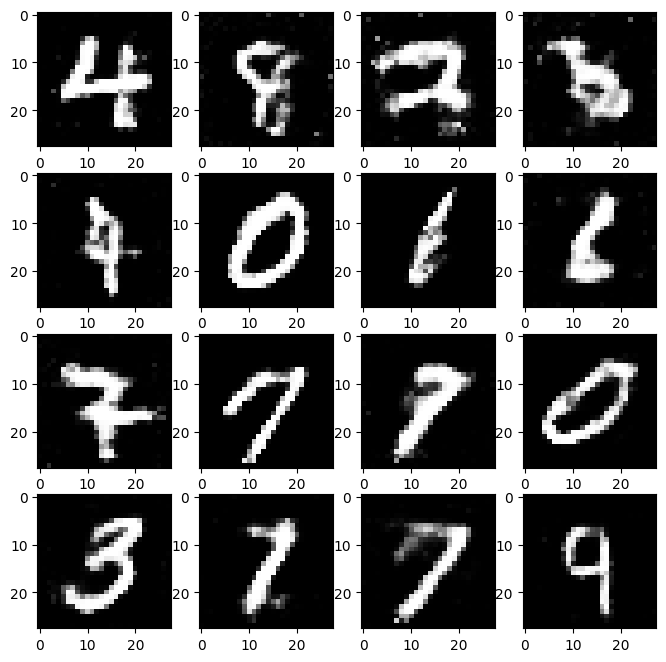

Epoch 67/200 (33.0%): [0/70016] (0.0%) D Error: 1.2520 G Error: 0.8056


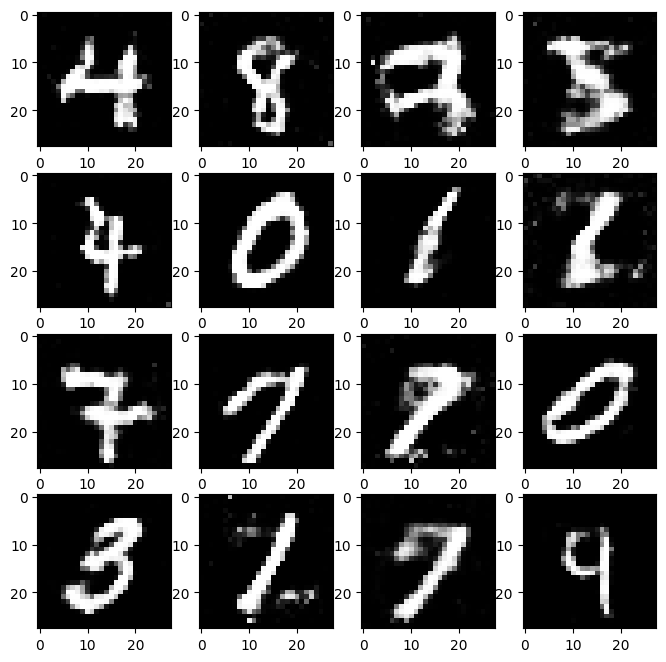

Epoch 68/200 (33.5%): [0/70016] (0.0%) D Error: 1.1753 G Error: 0.8958


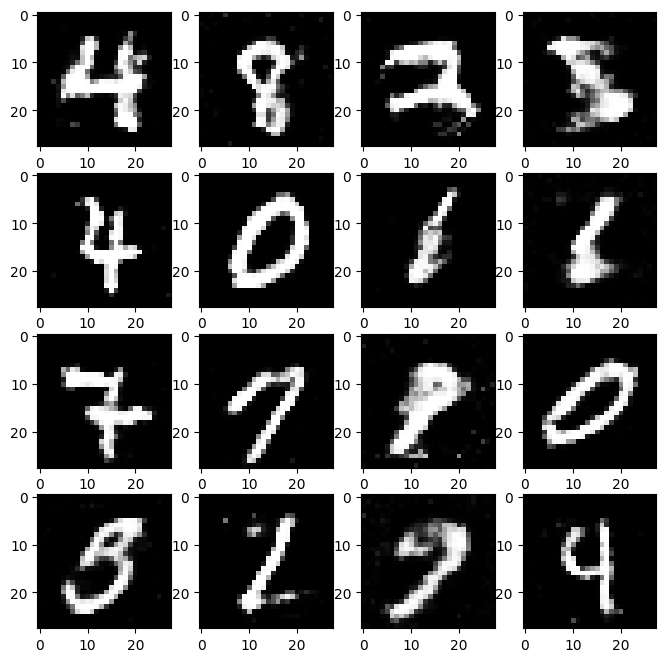

Epoch 69/200 (34.0%): [0/70016] (0.0%) D Error: 1.1940 G Error: 0.8832


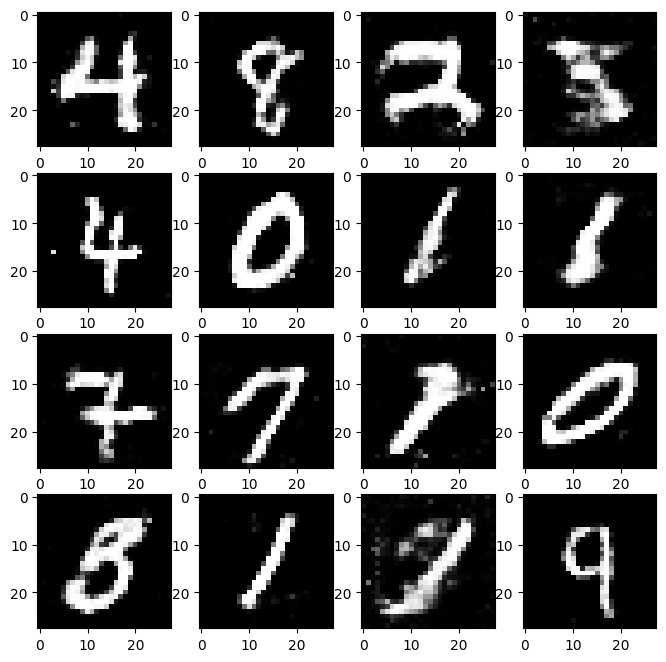

Epoch 70/200 (34.5%): [0/70016] (0.0%) D Error: 1.3065 G Error: 0.8000


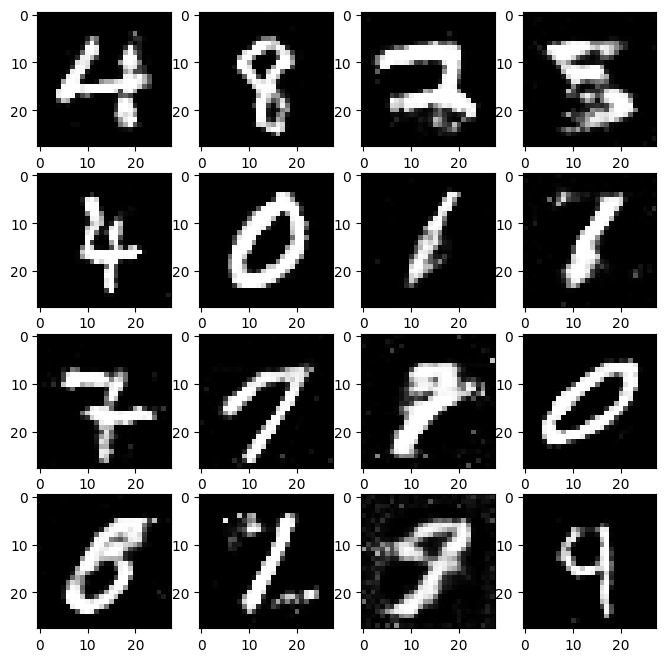

Epoch 71/200 (35.0%): [0/70016] (0.0%) D Error: 1.3127 G Error: 0.8589


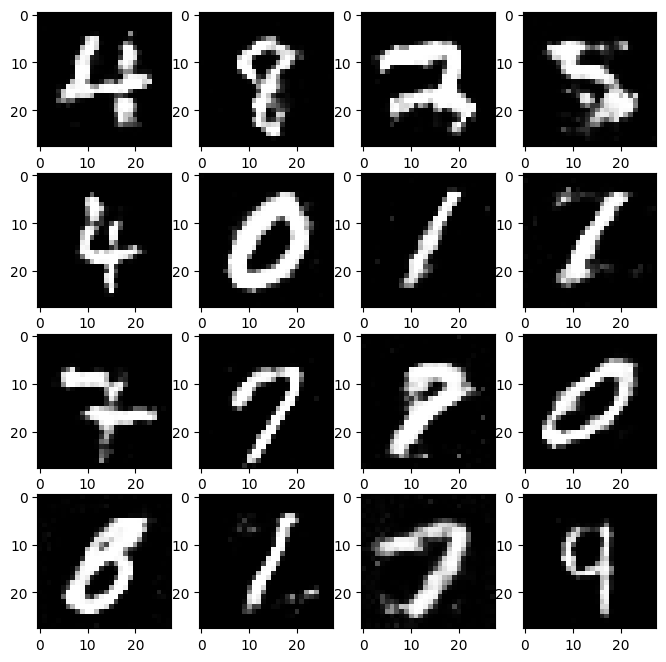

Epoch 72/200 (35.5%): [0/70016] (0.0%) D Error: 1.3006 G Error: 1.0301


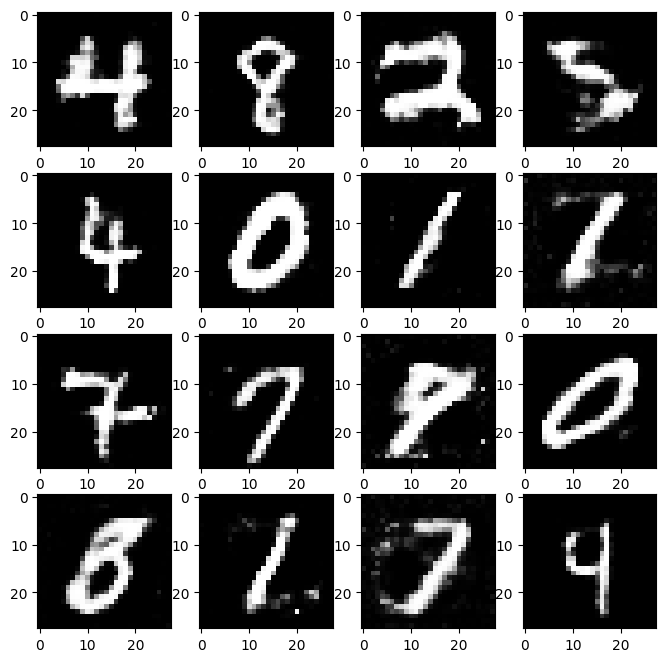

Epoch 73/200 (36.0%): [0/70016] (0.0%) D Error: 1.3247 G Error: 0.8560


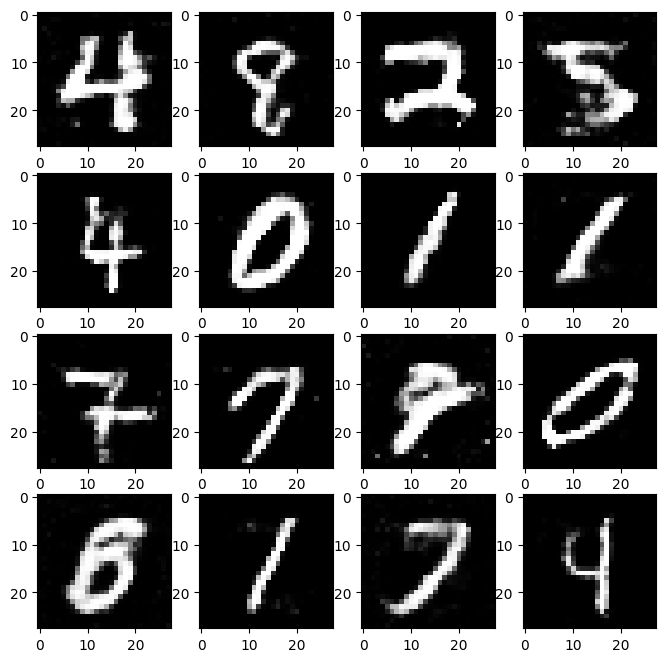

Epoch 74/200 (36.5%): [0/70016] (0.0%) D Error: 1.2807 G Error: 0.8712


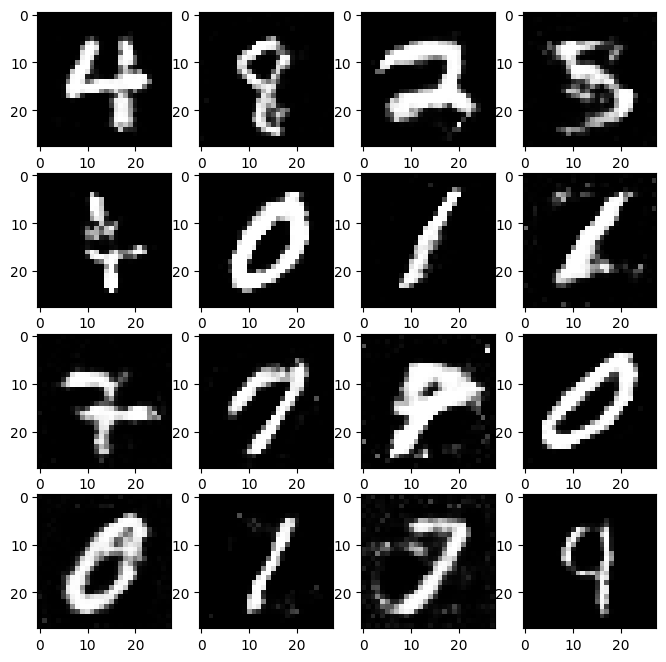

Epoch 75/200 (37.0%): [0/70016] (0.0%) D Error: 1.2820 G Error: 0.9004


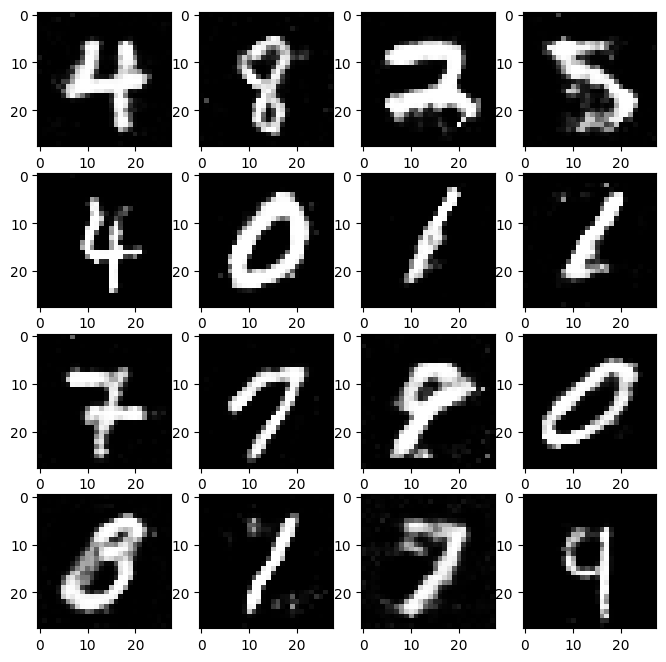

Epoch 76/200 (37.5%): [0/70016] (0.0%) D Error: 1.2788 G Error: 1.1063


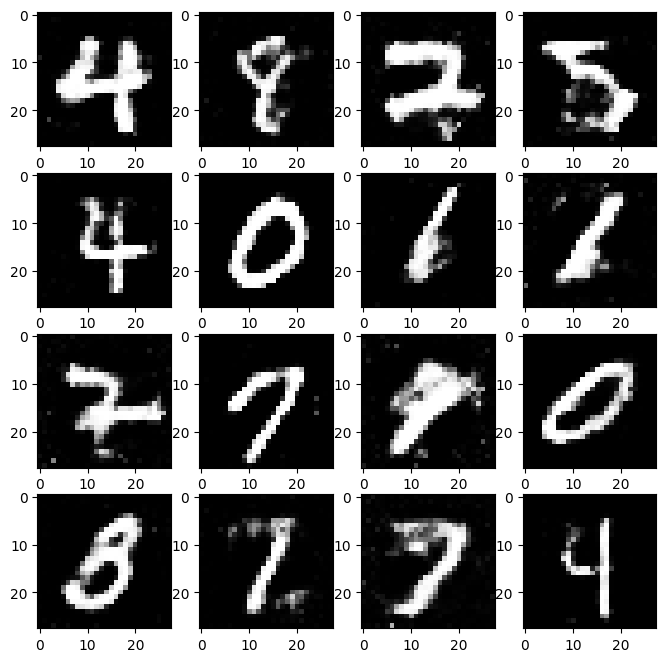

Epoch 77/200 (38.0%): [0/70016] (0.0%) D Error: 1.2579 G Error: 0.8563


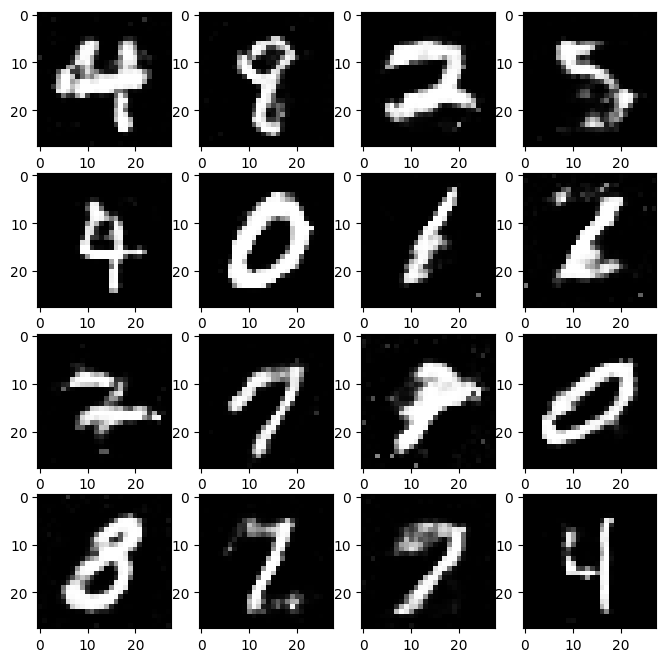

Epoch 78/200 (38.5%): [0/70016] (0.0%) D Error: 1.3624 G Error: 0.8473


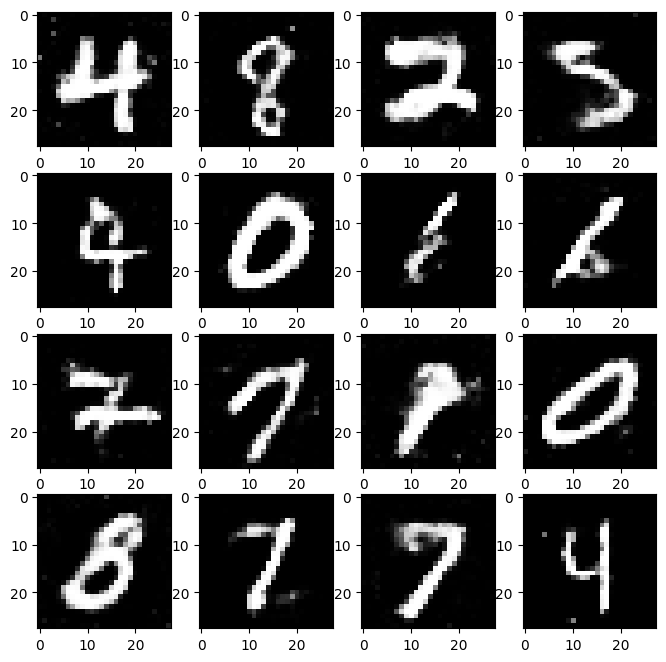

Epoch 79/200 (39.0%): [0/70016] (0.0%) D Error: 1.3189 G Error: 0.7853


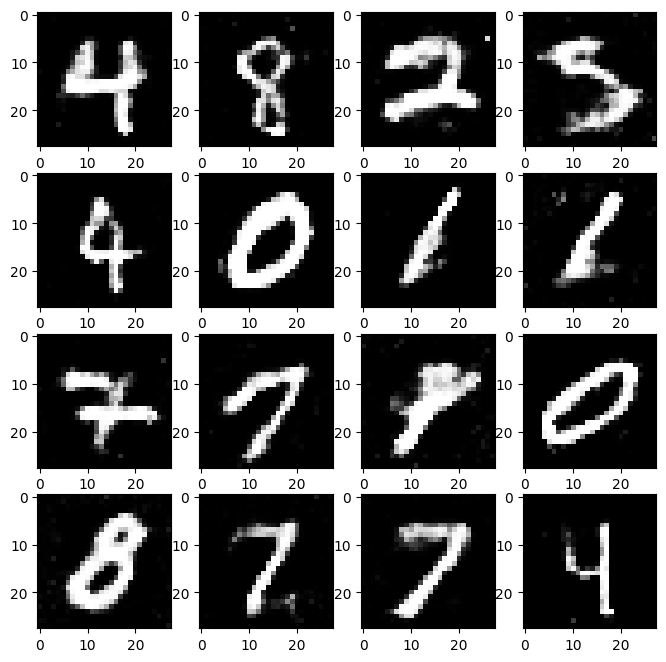

Epoch 80/200 (39.5%): [0/70016] (0.0%) D Error: 1.2545 G Error: 0.9297


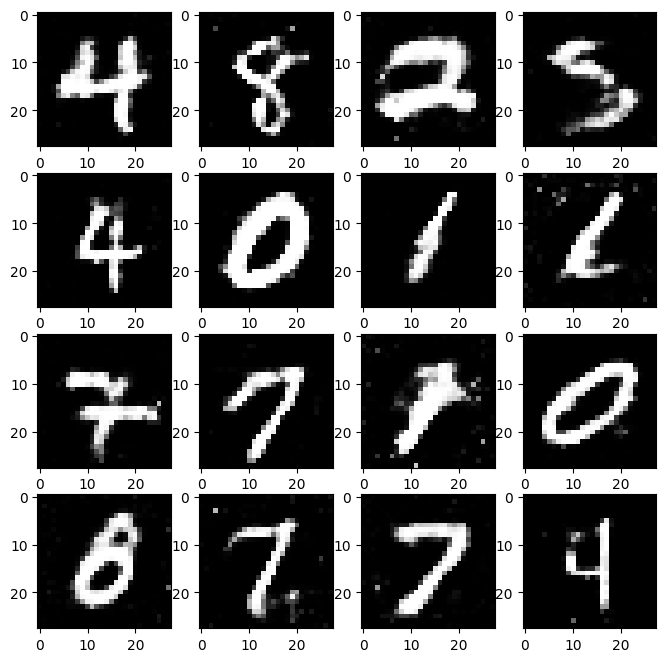

Epoch 81/200 (40.0%): [0/70016] (0.0%) D Error: 1.2411 G Error: 0.8740


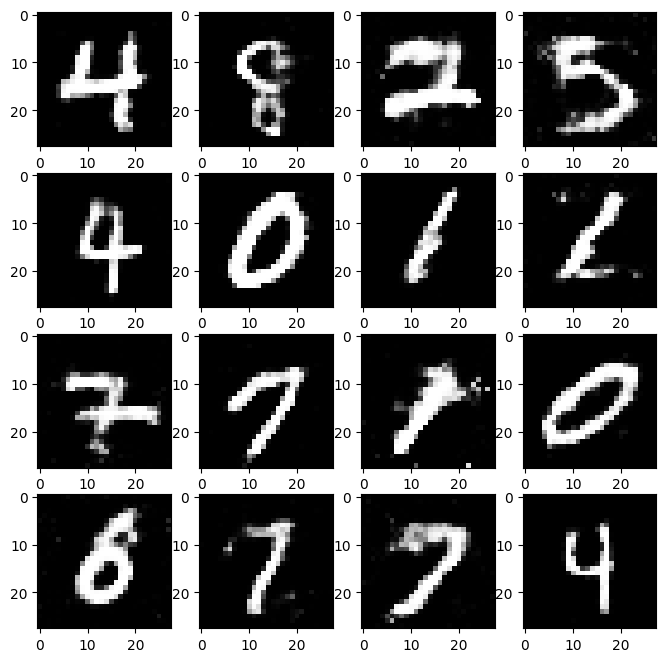

Epoch 82/200 (40.5%): [0/70016] (0.0%) D Error: 1.1654 G Error: 1.1015


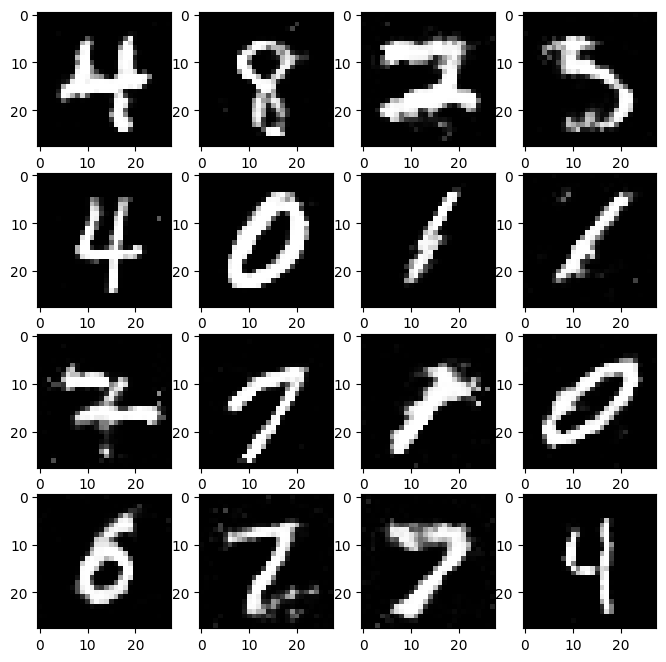

Epoch 83/200 (41.0%): [0/70016] (0.0%) D Error: 1.3572 G Error: 0.9540


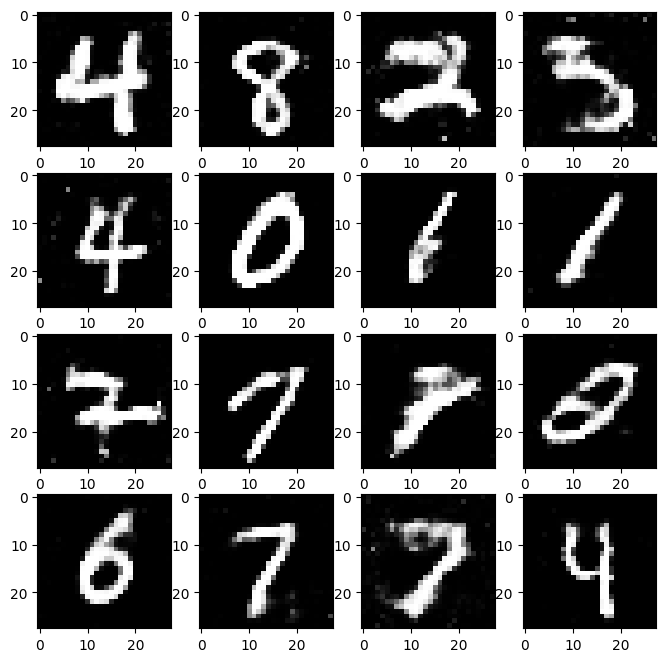

Epoch 84/200 (41.5%): [0/70016] (0.0%) D Error: 1.2379 G Error: 0.7760


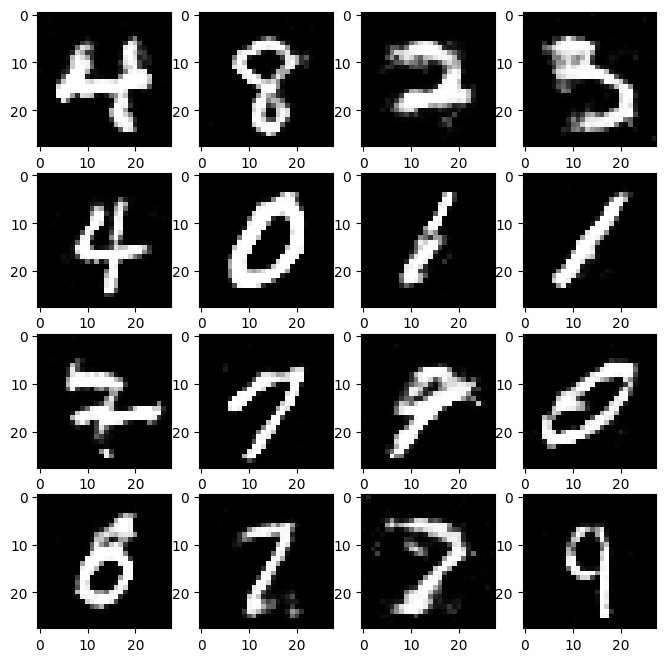

Epoch 85/200 (42.0%): [0/70016] (0.0%) D Error: 1.3307 G Error: 0.8833


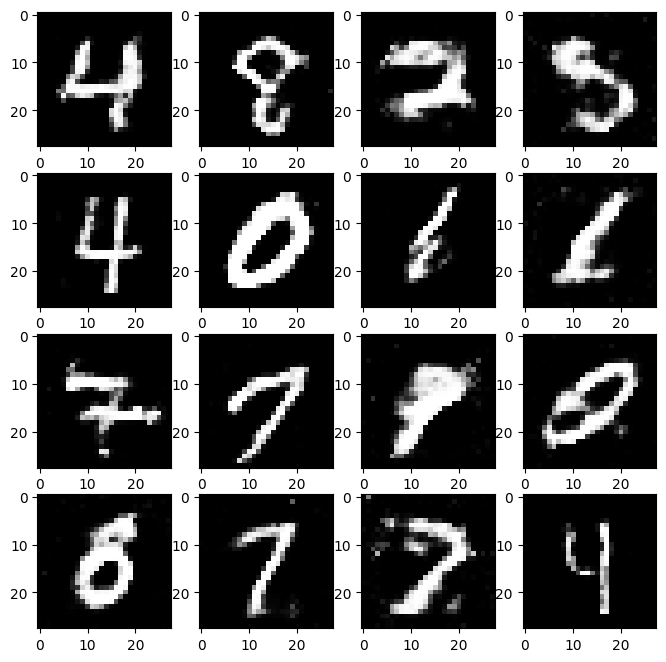

Epoch 86/200 (42.5%): [0/70016] (0.0%) D Error: 1.3261 G Error: 0.8466


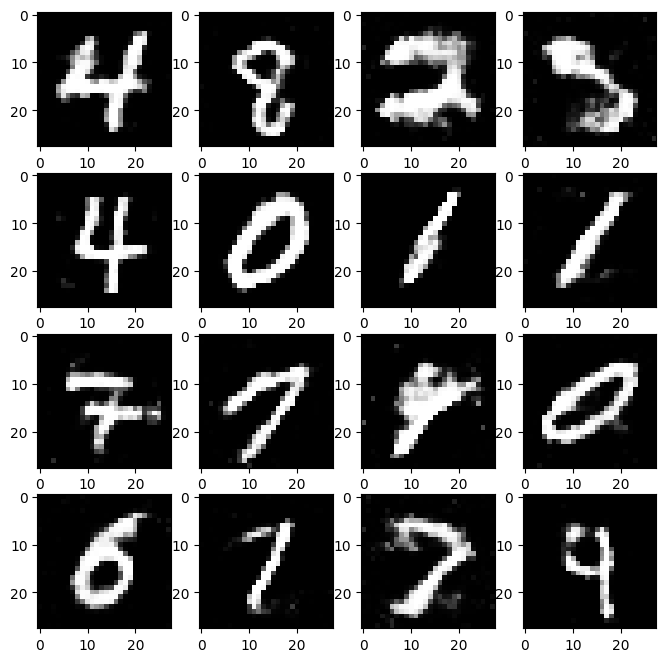

Epoch 87/200 (43.0%): [0/70016] (0.0%) D Error: 1.2866 G Error: 0.7973


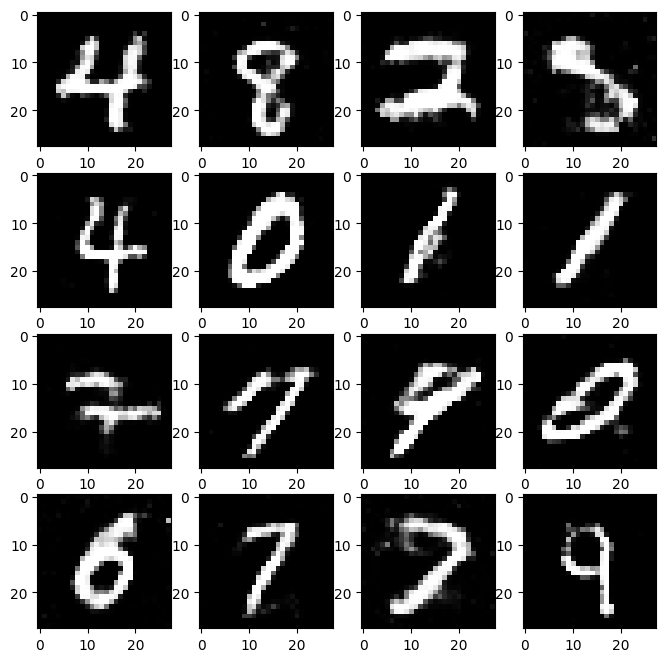

Epoch 88/200 (43.5%): [0/70016] (0.0%) D Error: 1.2967 G Error: 0.7737


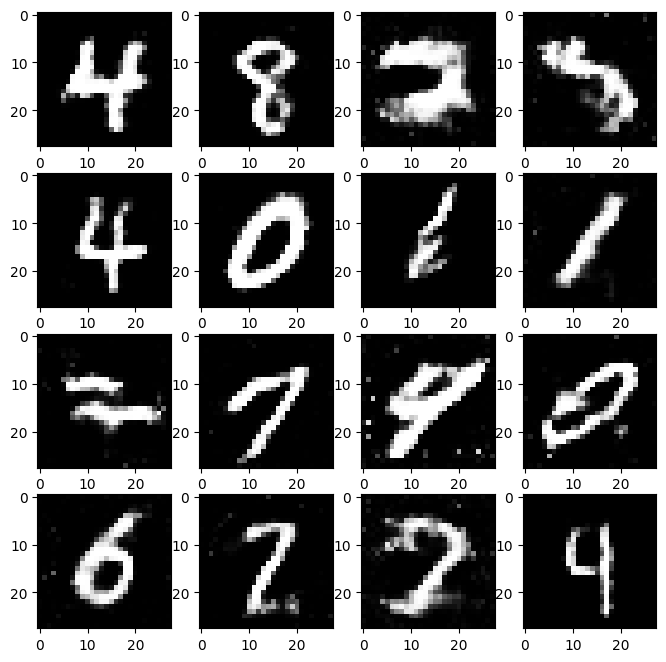

Epoch 89/200 (44.0%): [0/70016] (0.0%) D Error: 1.2827 G Error: 0.8881


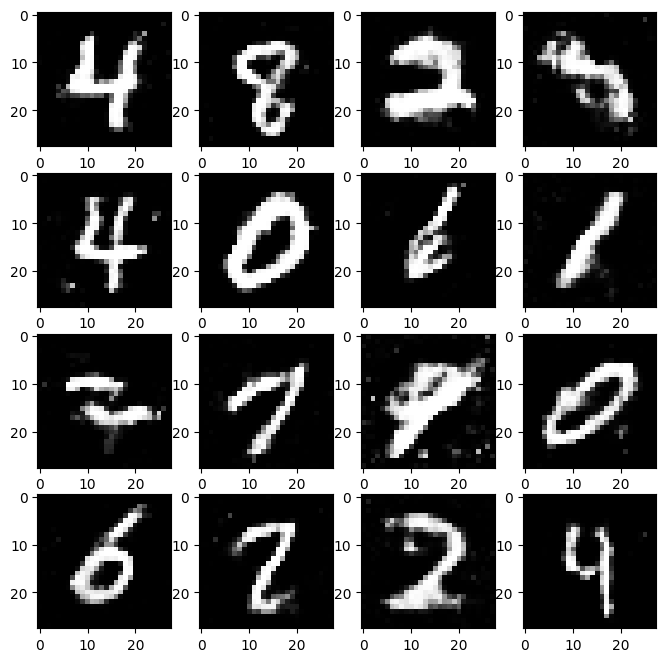

Epoch 90/200 (44.5%): [0/70016] (0.0%) D Error: 1.1136 G Error: 1.1792


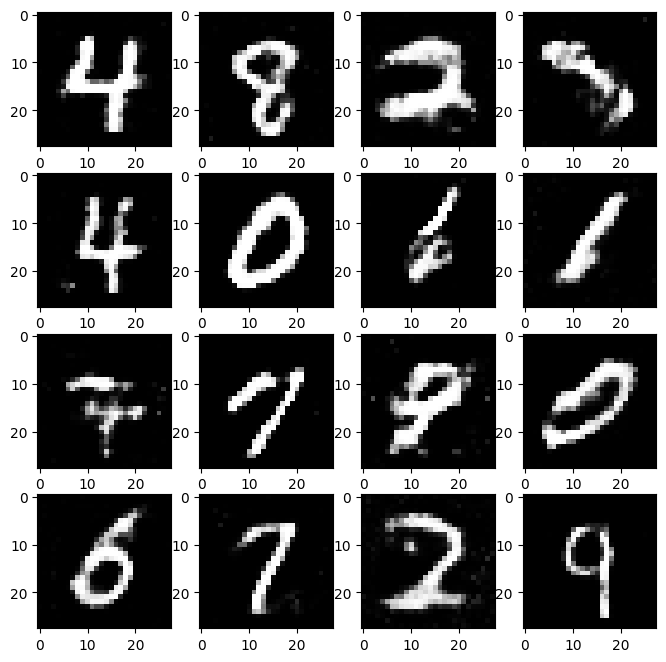

Epoch 91/200 (45.0%): [0/70016] (0.0%) D Error: 1.2704 G Error: 0.8558


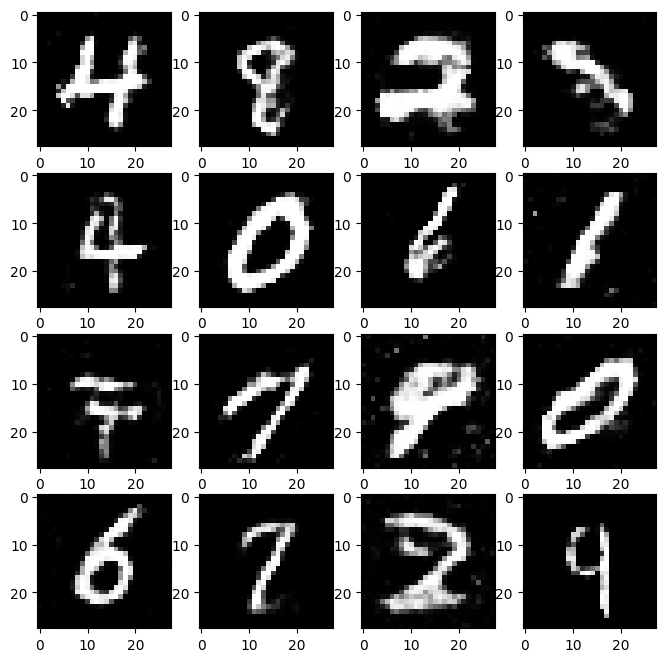

Epoch 92/200 (45.5%): [0/70016] (0.0%) D Error: 1.3501 G Error: 0.8253


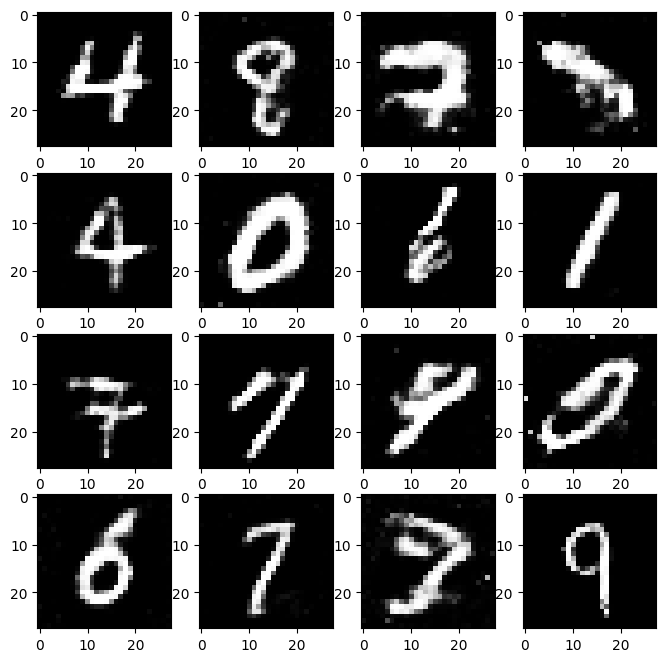

Epoch 93/200 (46.0%): [0/70016] (0.0%) D Error: 1.2887 G Error: 0.8064


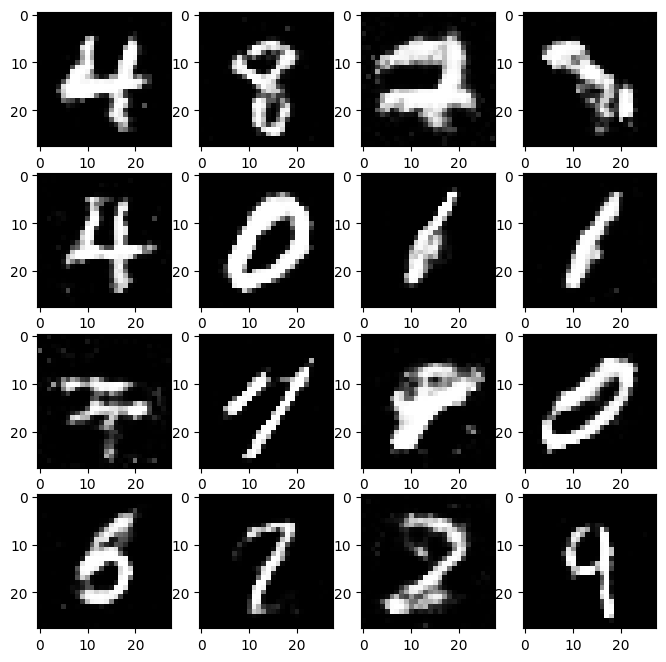

Epoch 94/200 (46.5%): [0/70016] (0.0%) D Error: 1.3520 G Error: 0.8410


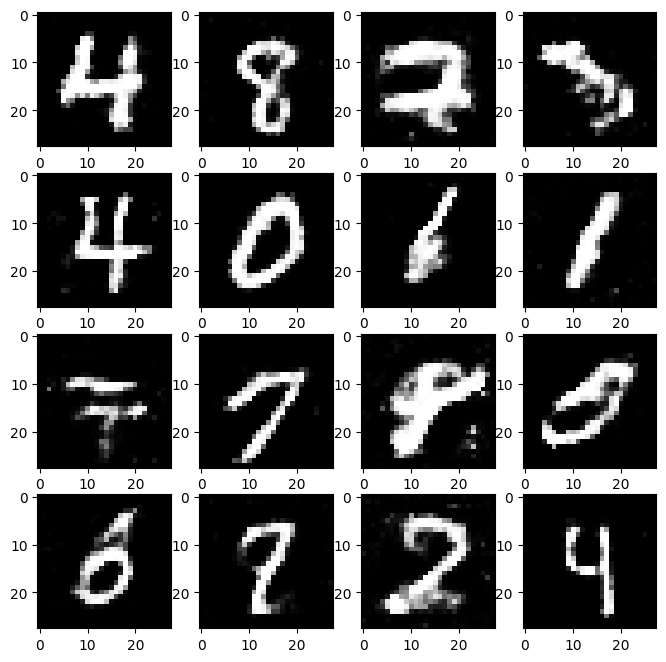

Epoch 95/200 (47.0%): [0/70016] (0.0%) D Error: 1.4579 G Error: 0.7986


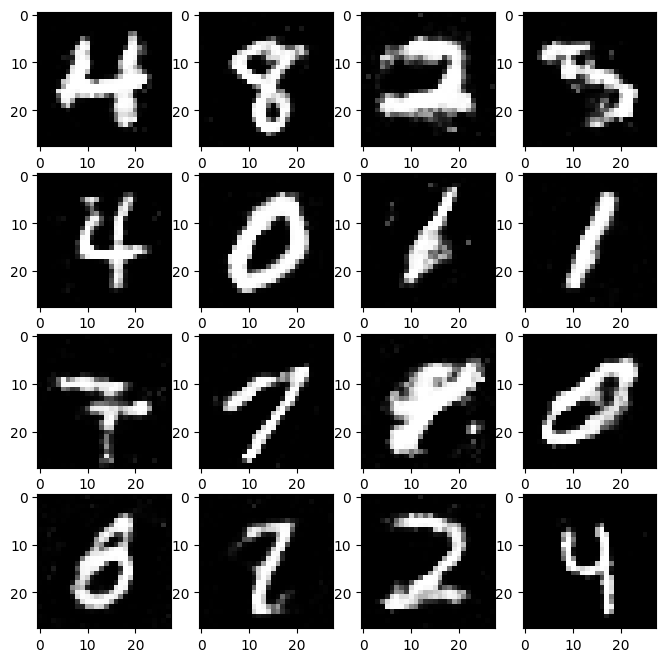

Epoch 96/200 (47.5%): [0/70016] (0.0%) D Error: 1.2881 G Error: 0.8098


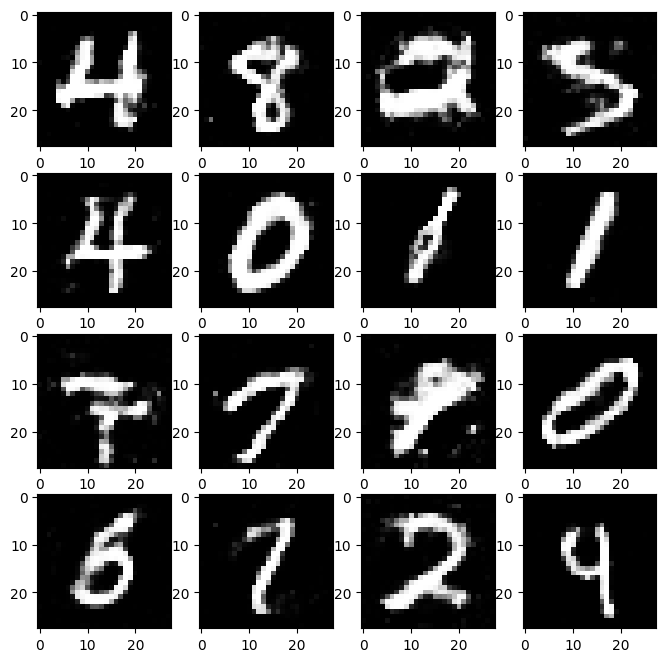

Epoch 97/200 (48.0%): [0/70016] (0.0%) D Error: 1.2499 G Error: 0.9740


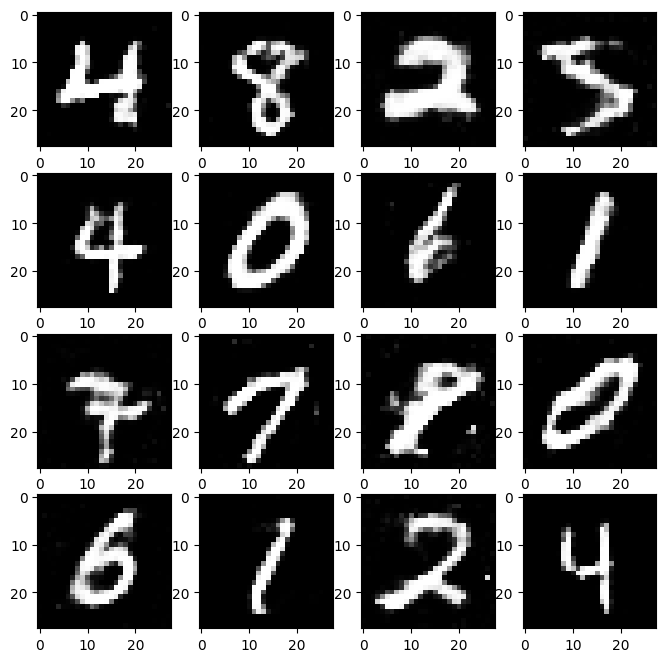

Epoch 98/200 (48.5%): [0/70016] (0.0%) D Error: 1.3586 G Error: 0.7929


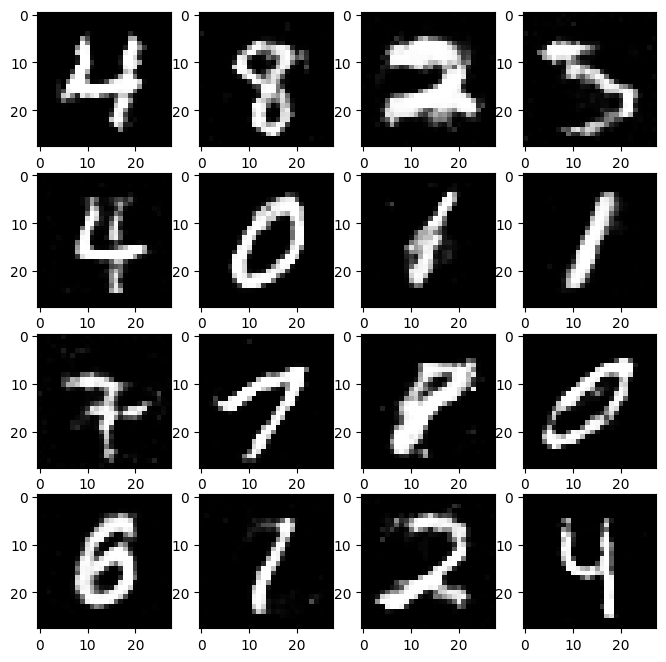

Epoch 99/200 (49.0%): [0/70016] (0.0%) D Error: 1.2926 G Error: 0.9418


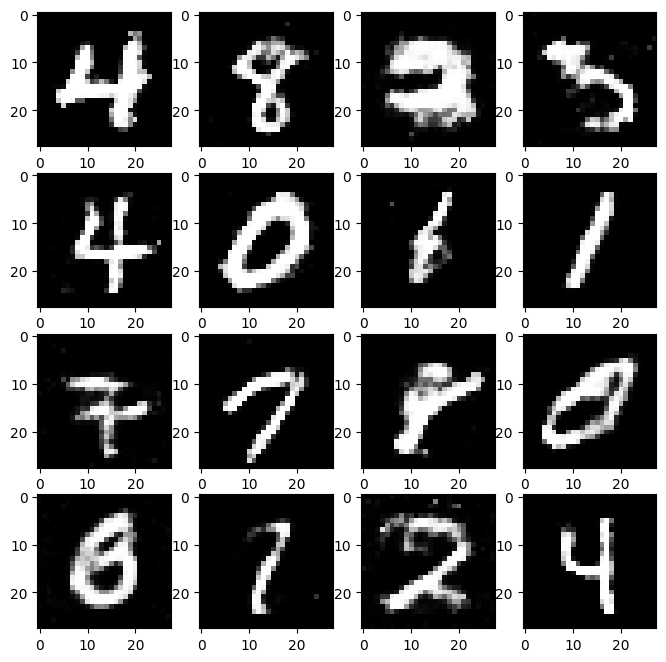

Epoch 100/200 (49.5%): [0/70016] (0.0%) D Error: 1.2168 G Error: 0.7978


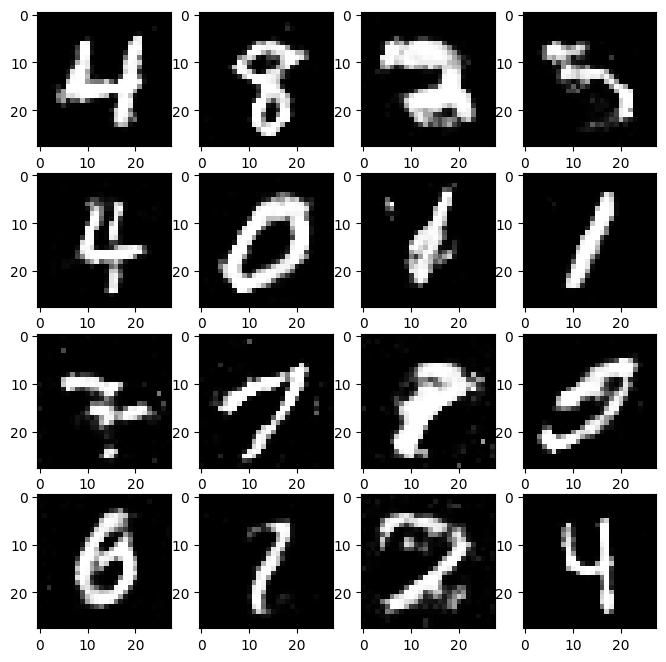

Epoch 101/200 (50.0%): [0/70016] (0.0%) D Error: 1.2847 G Error: 0.8784


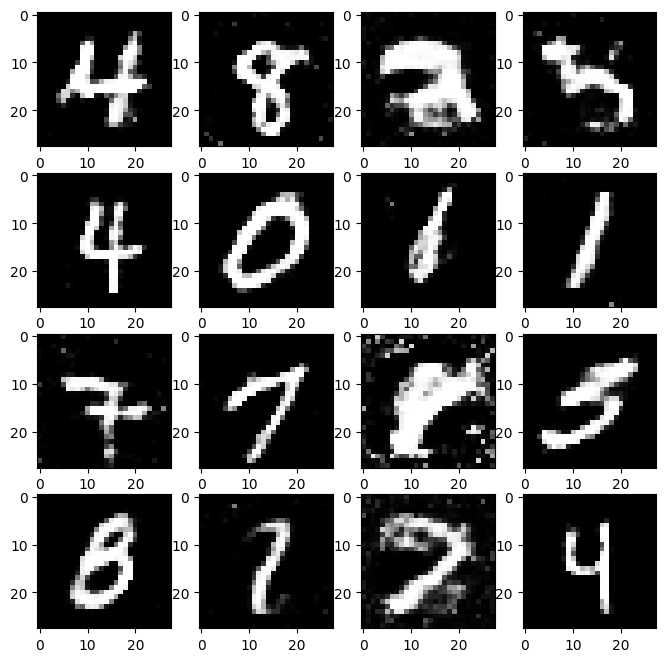

Epoch 102/200 (50.5%): [0/70016] (0.0%) D Error: 1.2291 G Error: 0.8540


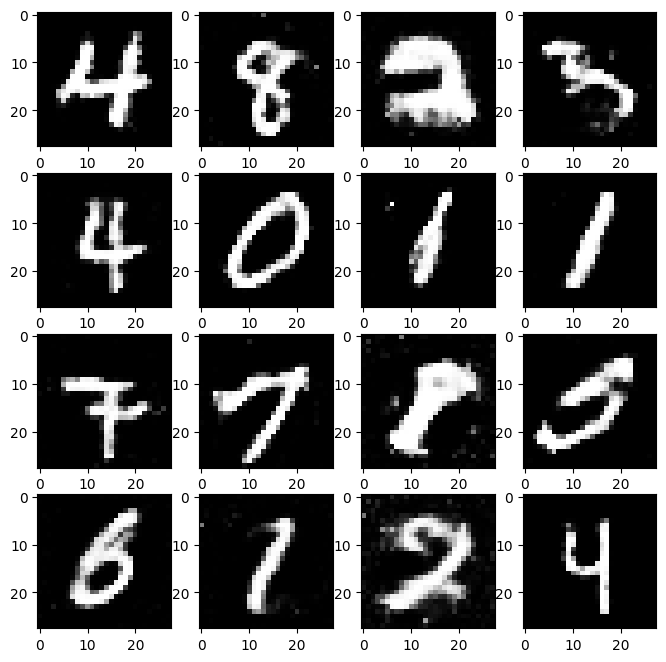

Epoch 103/200 (51.0%): [0/70016] (0.0%) D Error: 1.2506 G Error: 0.8638


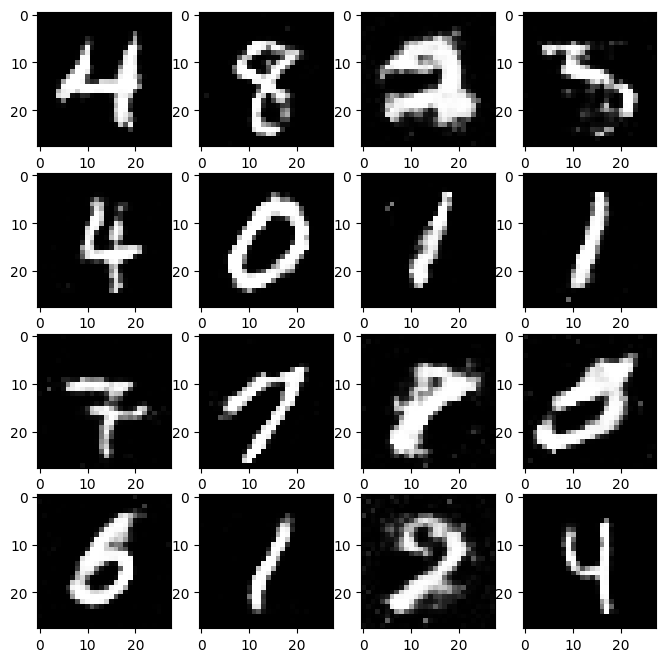

Epoch 104/200 (51.5%): [0/70016] (0.0%) D Error: 1.2342 G Error: 0.9118


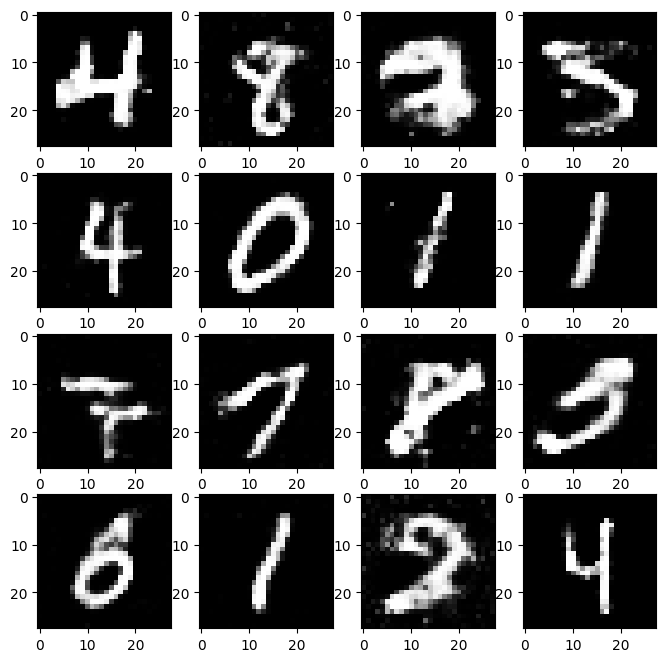

Epoch 105/200 (52.0%): [0/70016] (0.0%) D Error: 1.2683 G Error: 0.9121


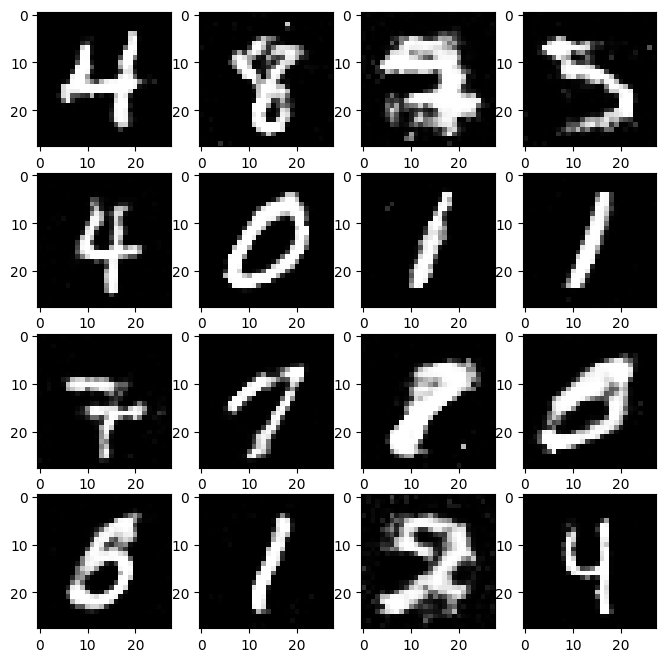

Epoch 106/200 (52.5%): [0/70016] (0.0%) D Error: 1.2370 G Error: 0.8390


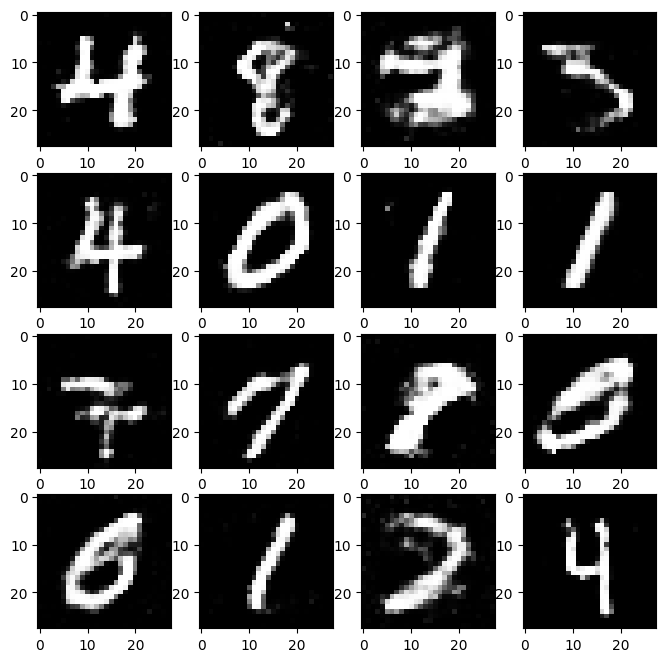

Epoch 107/200 (53.0%): [0/70016] (0.0%) D Error: 1.4455 G Error: 0.8553


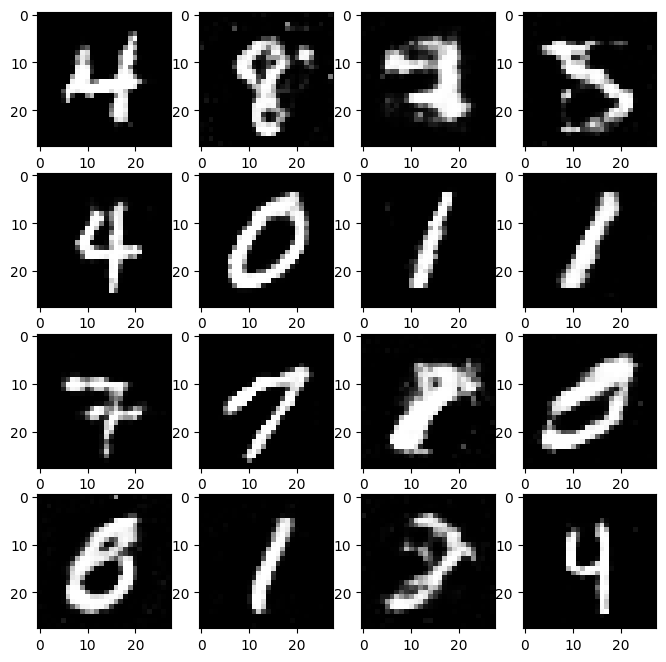

Epoch 108/200 (53.5%): [0/70016] (0.0%) D Error: 1.3731 G Error: 0.9219


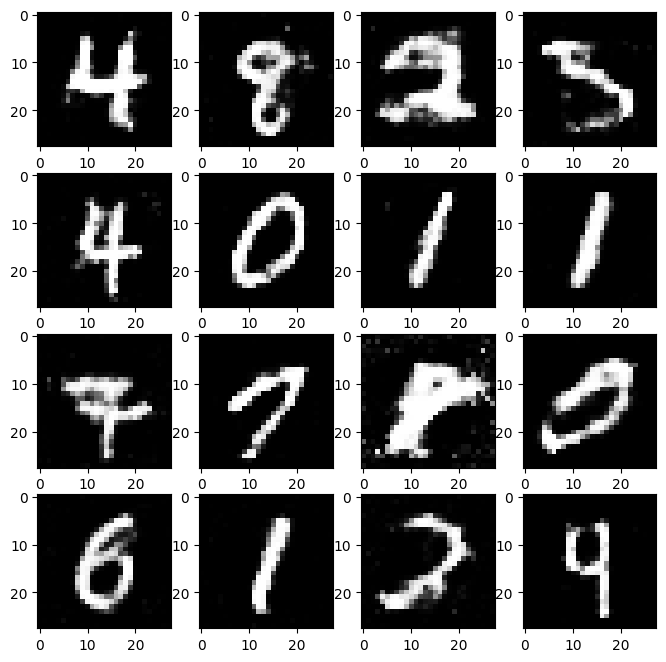

Epoch 109/200 (54.0%): [0/70016] (0.0%) D Error: 1.2673 G Error: 0.8657


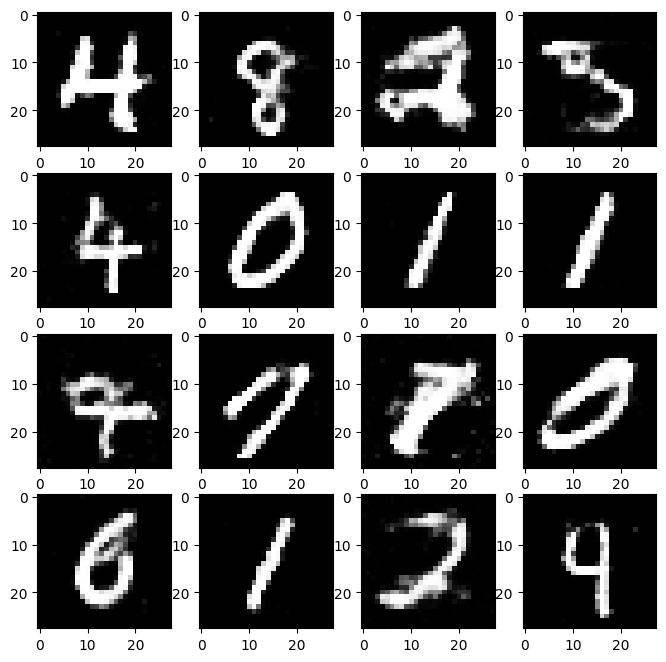

Epoch 110/200 (54.5%): [0/70016] (0.0%) D Error: 1.3382 G Error: 0.7526


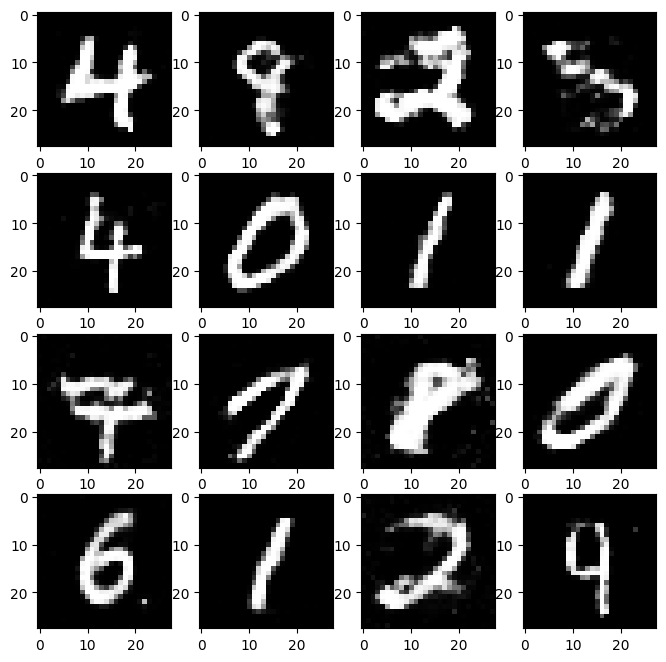

Epoch 111/200 (55.0%): [0/70016] (0.0%) D Error: 1.2611 G Error: 0.8528


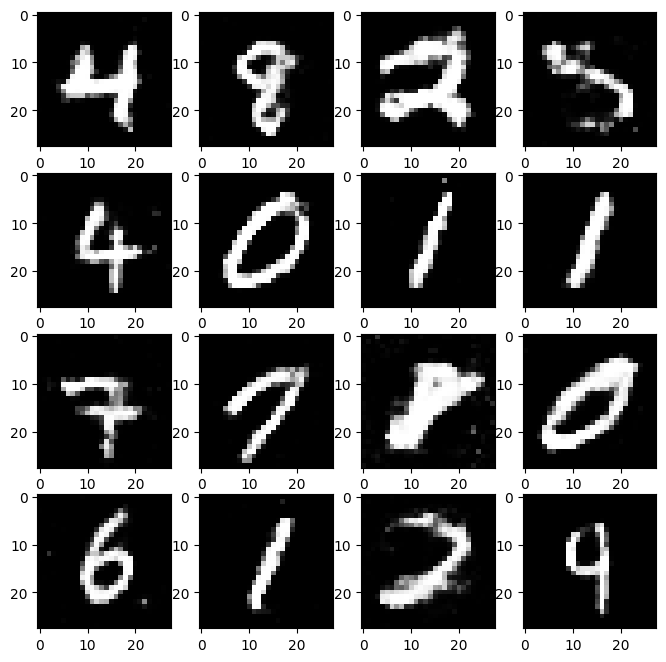

Epoch 112/200 (55.5%): [0/70016] (0.0%) D Error: 1.2836 G Error: 0.9021


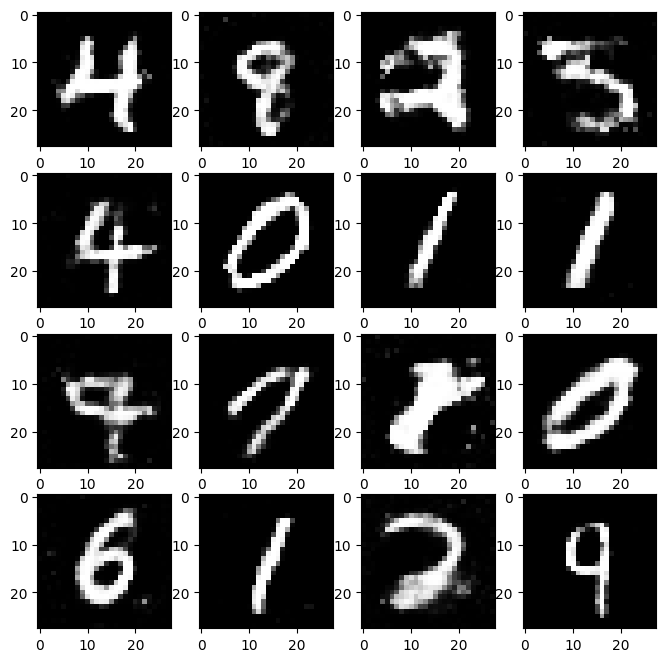

Epoch 113/200 (56.0%): [0/70016] (0.0%) D Error: 1.2539 G Error: 0.8864


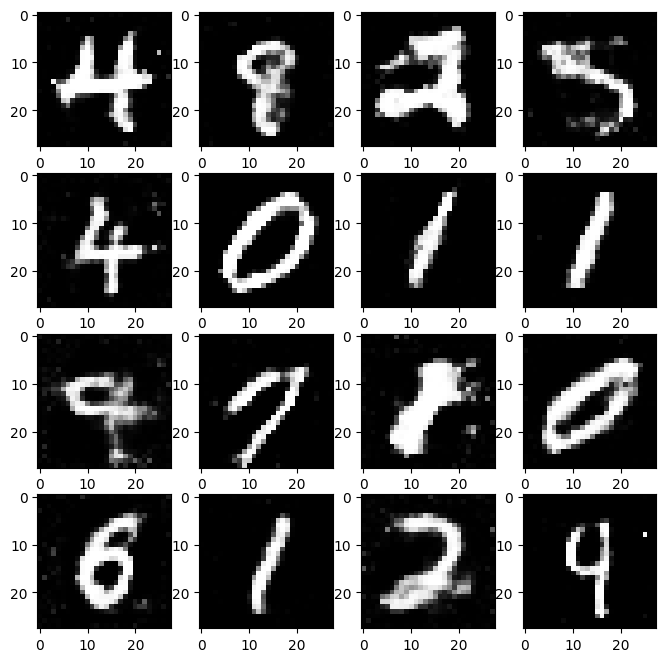

Epoch 114/200 (56.5%): [0/70016] (0.0%) D Error: 1.2812 G Error: 0.8700


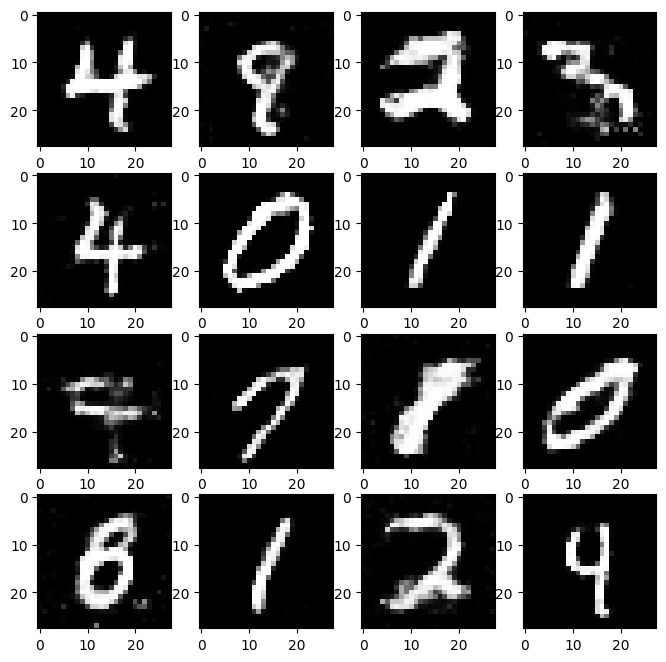

Epoch 115/200 (57.0%): [0/70016] (0.0%) D Error: 1.4386 G Error: 0.8561


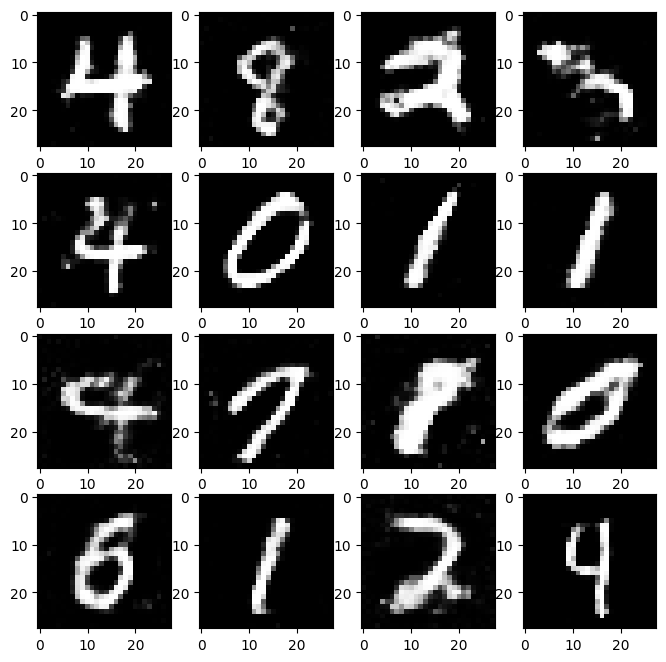

Epoch 116/200 (57.5%): [0/70016] (0.0%) D Error: 1.3346 G Error: 0.7137


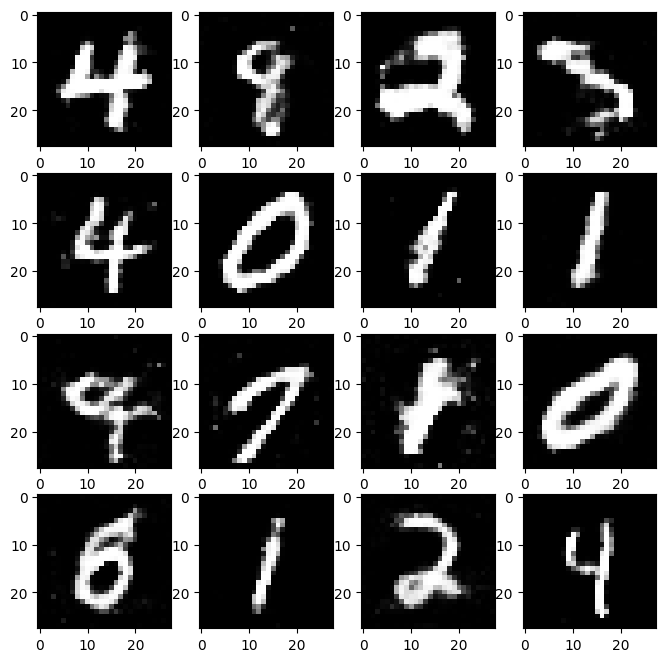

Epoch 117/200 (58.0%): [0/70016] (0.0%) D Error: 1.2713 G Error: 0.8038


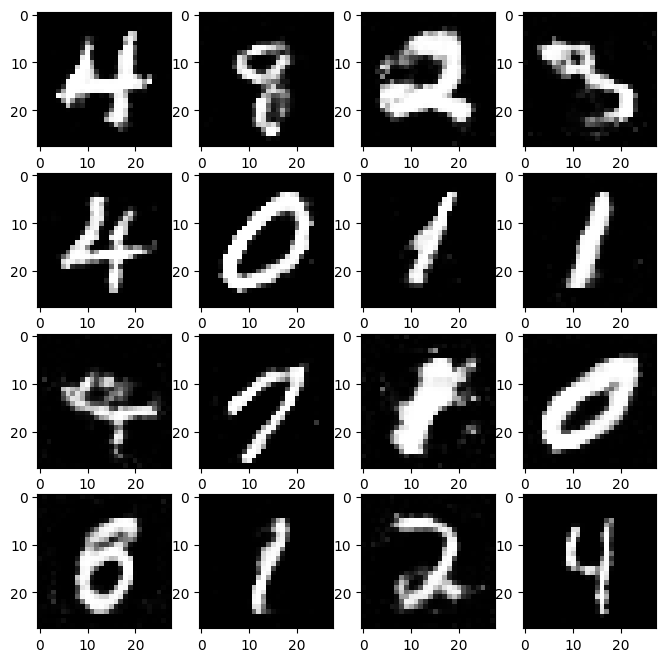

Epoch 118/200 (58.5%): [0/70016] (0.0%) D Error: 1.2738 G Error: 0.8686


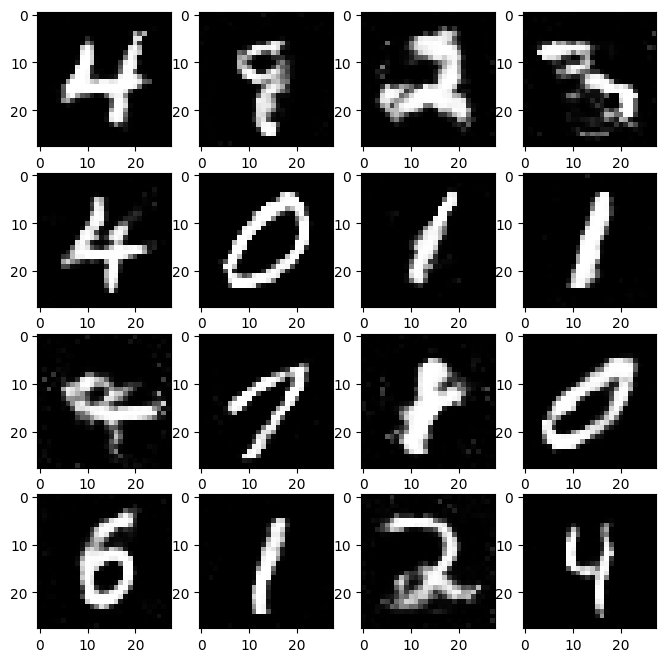

Epoch 119/200 (59.0%): [0/70016] (0.0%) D Error: 1.2901 G Error: 0.7900


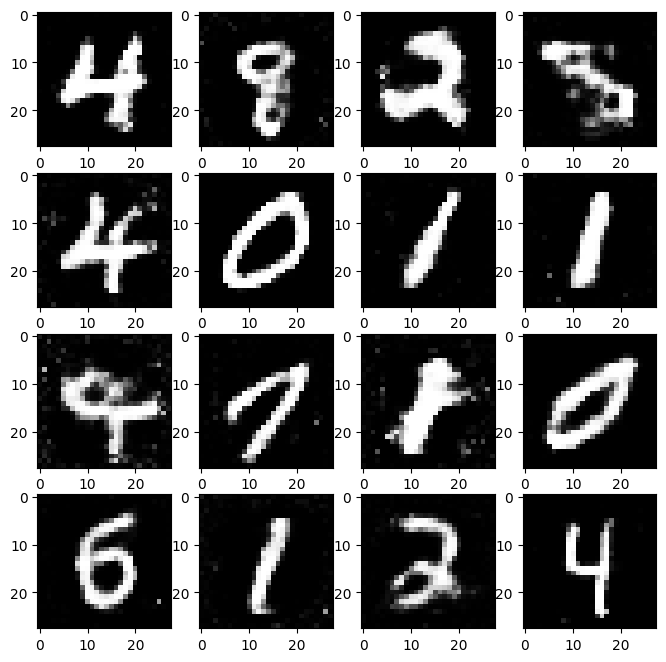

Epoch 120/200 (59.5%): [0/70016] (0.0%) D Error: 1.3889 G Error: 0.8623


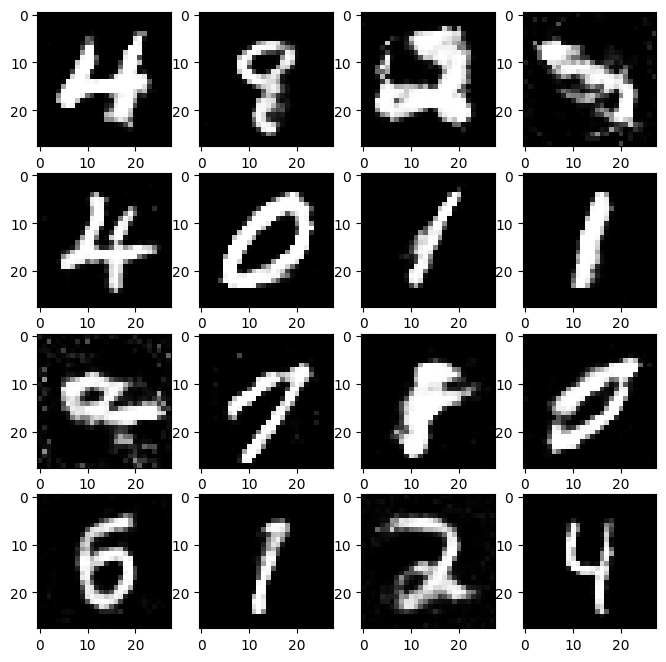

Epoch 121/200 (60.0%): [0/70016] (0.0%) D Error: 1.3588 G Error: 0.8845


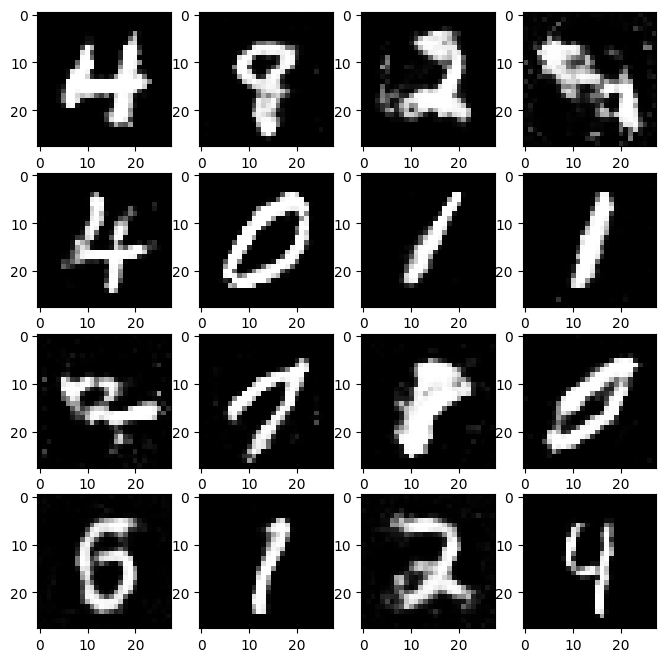

Epoch 122/200 (60.5%): [0/70016] (0.0%) D Error: 1.2974 G Error: 0.9092


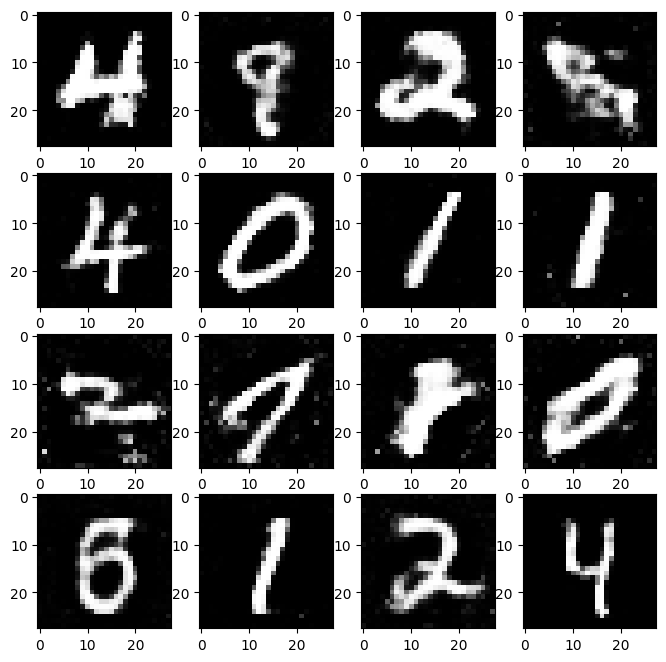

Epoch 123/200 (61.0%): [0/70016] (0.0%) D Error: 1.3151 G Error: 0.7560


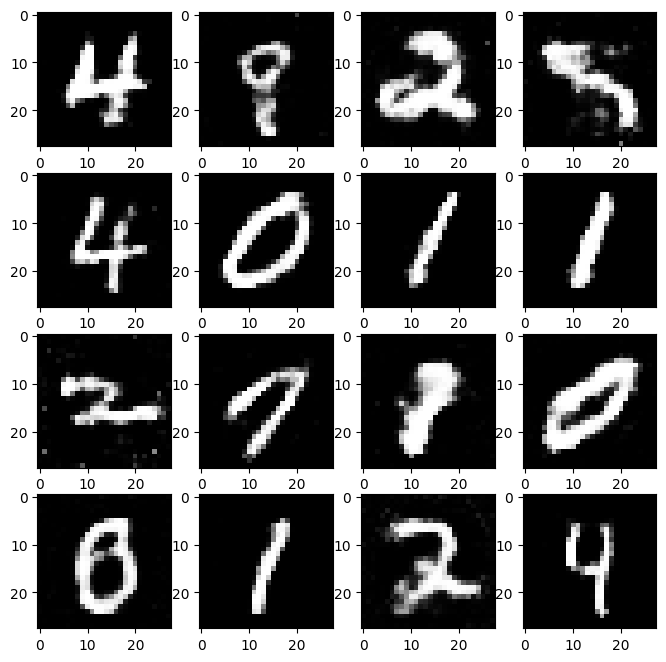

Epoch 124/200 (61.5%): [0/70016] (0.0%) D Error: 1.3474 G Error: 0.9008


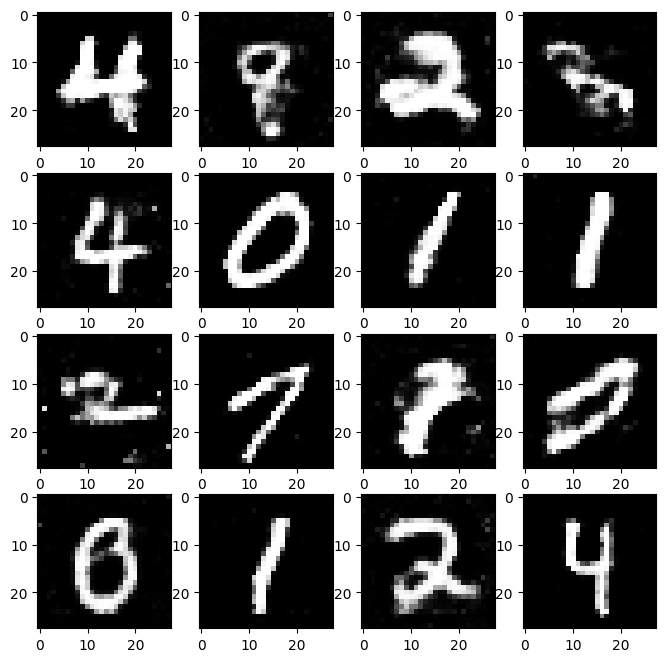

Epoch 125/200 (62.0%): [0/70016] (0.0%) D Error: 1.2392 G Error: 0.8935


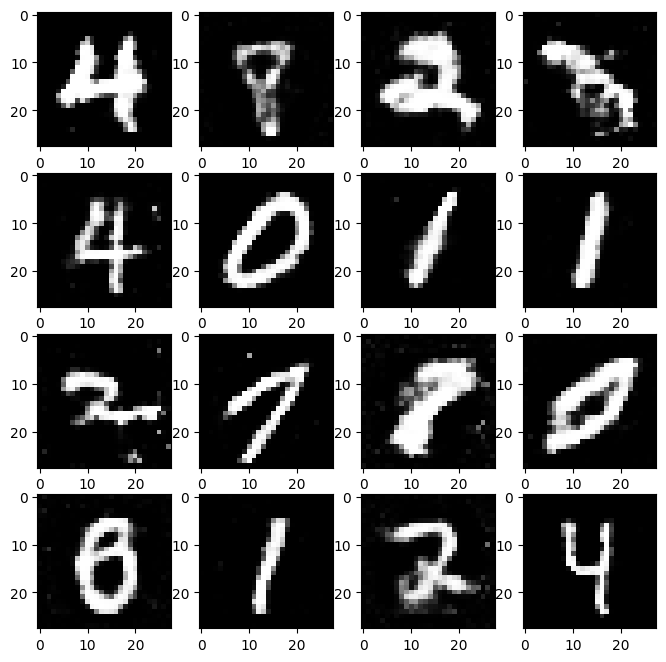

Epoch 126/200 (62.5%): [0/70016] (0.0%) D Error: 1.2742 G Error: 0.8706


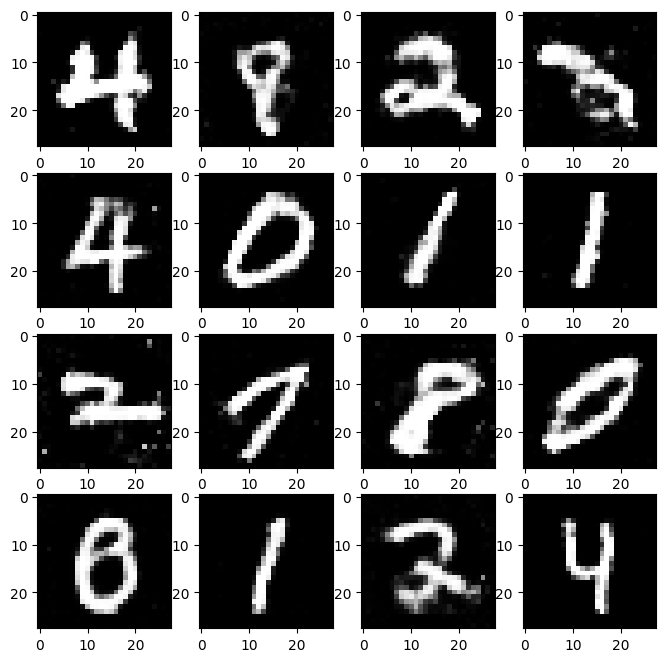

Epoch 127/200 (63.0%): [0/70016] (0.0%) D Error: 1.3131 G Error: 0.8384


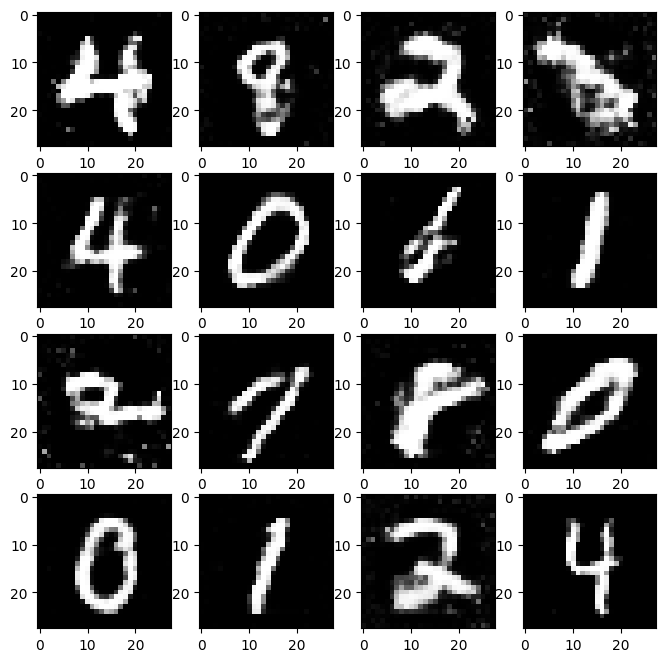

Epoch 128/200 (63.5%): [0/70016] (0.0%) D Error: 1.2638 G Error: 0.8703


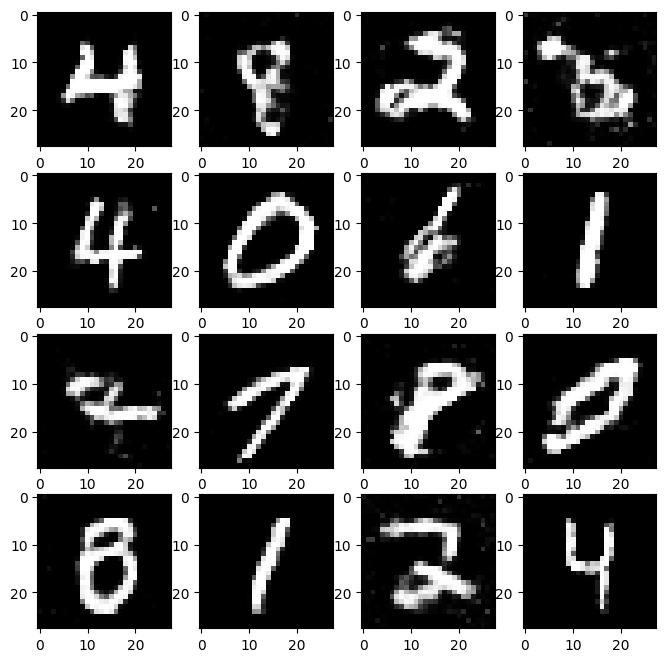

Epoch 129/200 (64.0%): [0/70016] (0.0%) D Error: 1.2784 G Error: 0.8310


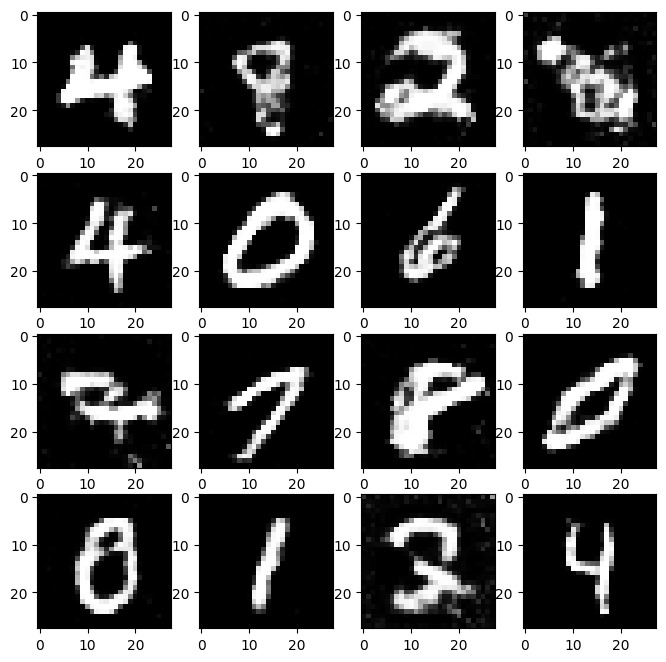

Epoch 130/200 (64.5%): [0/70016] (0.0%) D Error: 1.3007 G Error: 0.7964


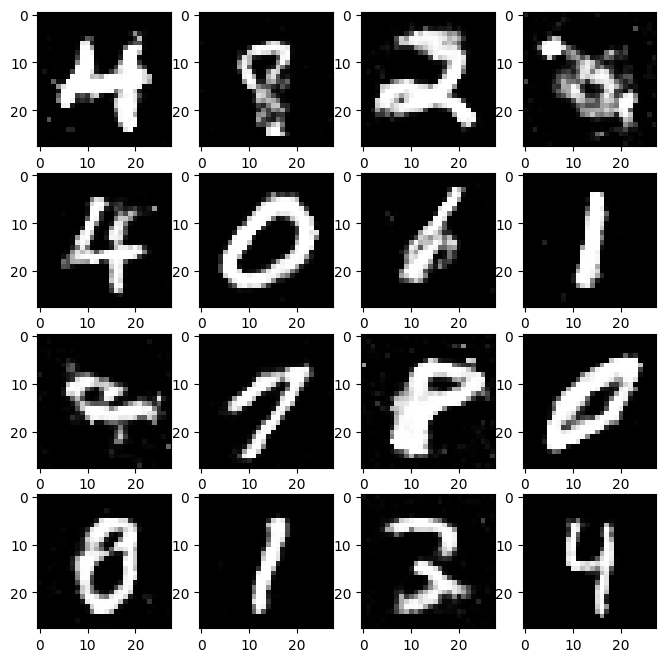

Epoch 131/200 (65.0%): [0/70016] (0.0%) D Error: 1.2866 G Error: 0.7575


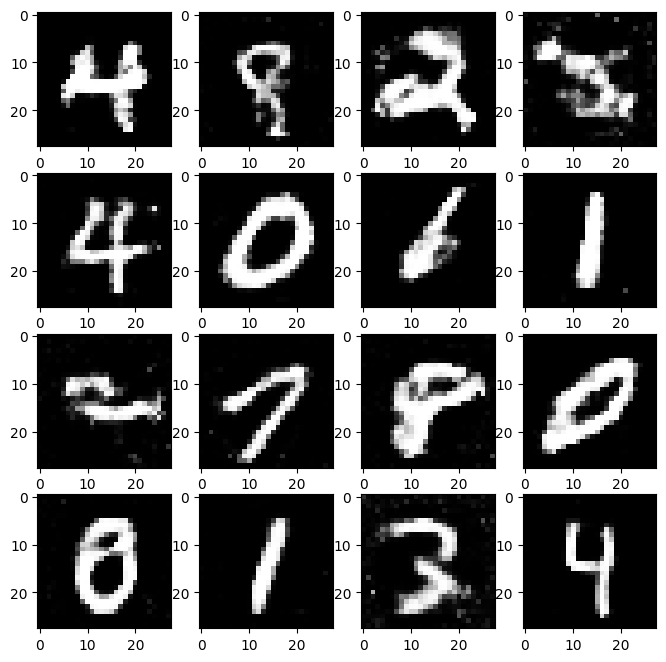

Epoch 132/200 (65.5%): [0/70016] (0.0%) D Error: 1.2966 G Error: 0.8487


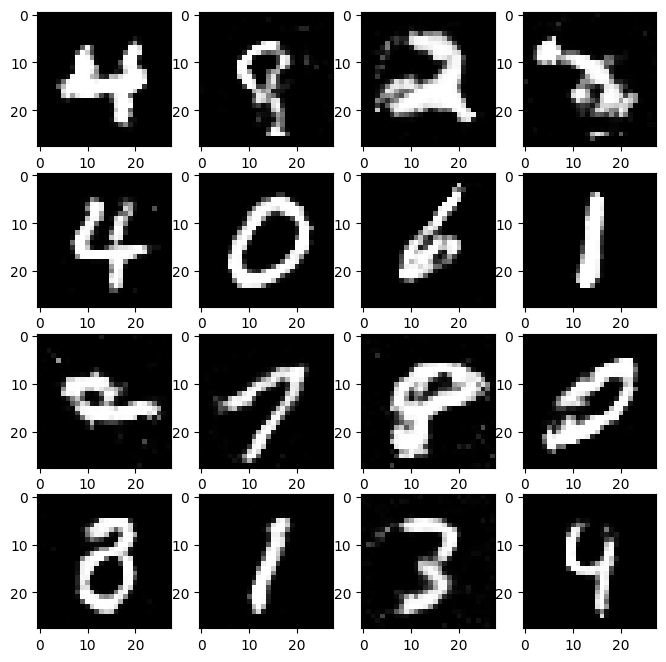

Epoch 133/200 (66.0%): [0/70016] (0.0%) D Error: 1.0983 G Error: 0.9702


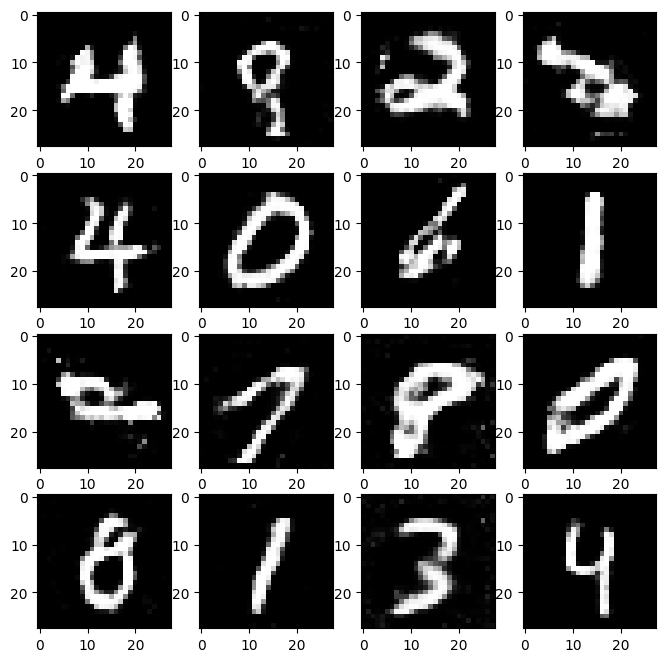

Epoch 134/200 (66.5%): [0/70016] (0.0%) D Error: 1.3330 G Error: 0.9073


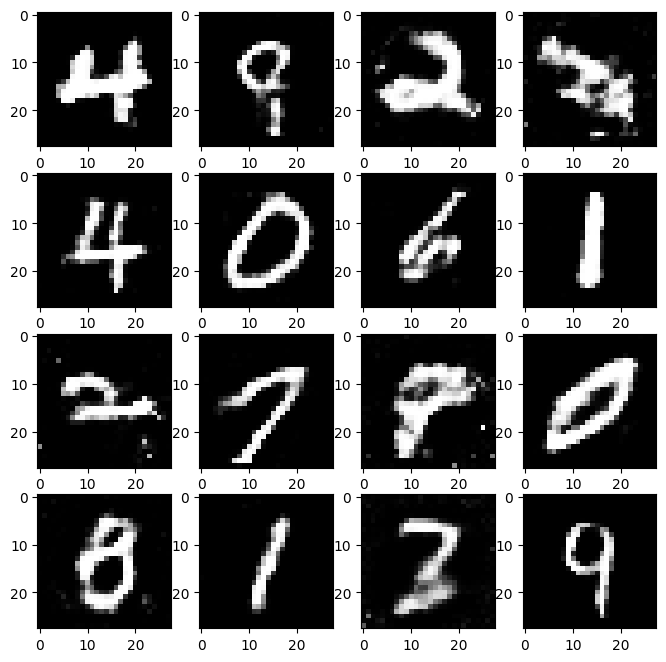

Epoch 135/200 (67.0%): [0/70016] (0.0%) D Error: 1.3341 G Error: 0.8781


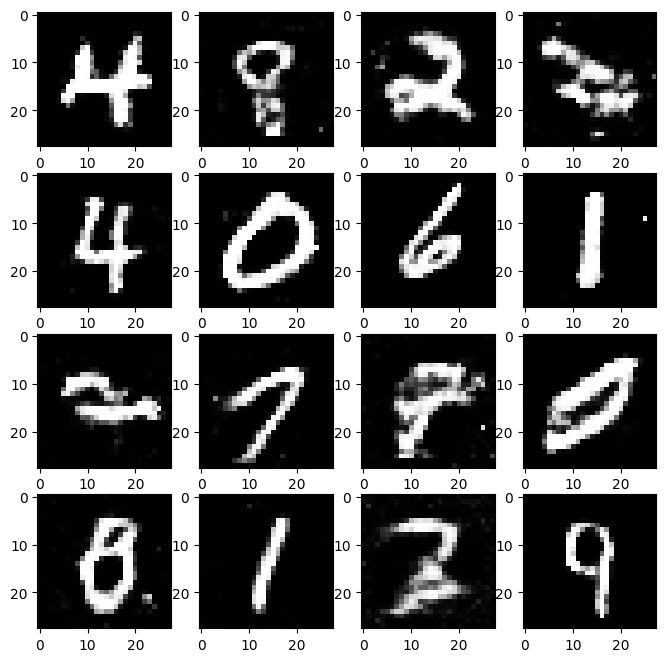

Epoch 136/200 (67.5%): [0/70016] (0.0%) D Error: 1.2957 G Error: 0.8601


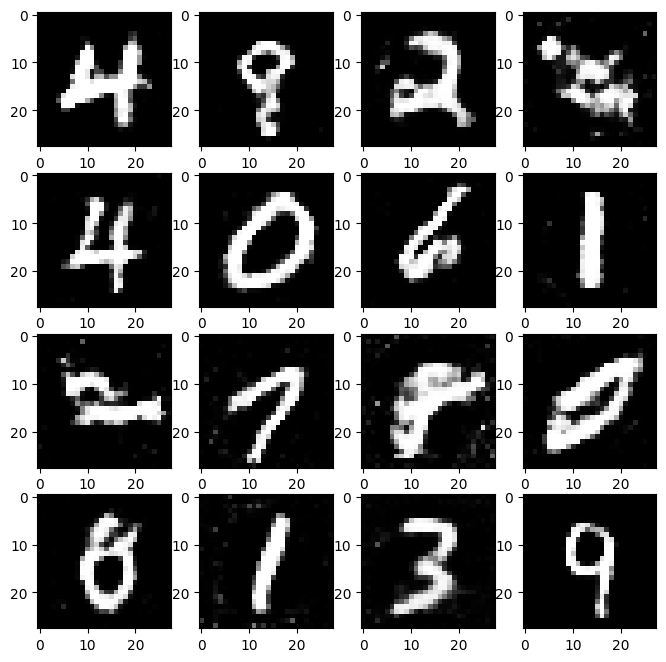

Epoch 137/200 (68.0%): [0/70016] (0.0%) D Error: 1.3399 G Error: 0.8695


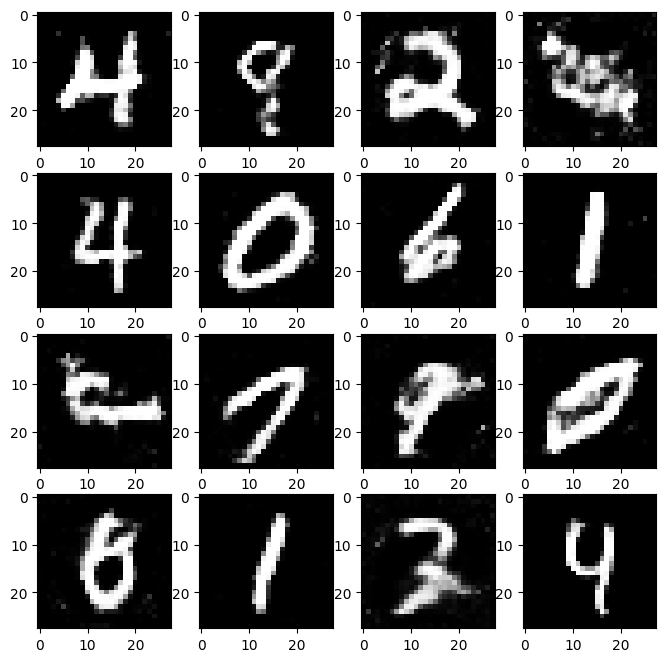

Epoch 138/200 (68.5%): [0/70016] (0.0%) D Error: 1.3214 G Error: 0.8583


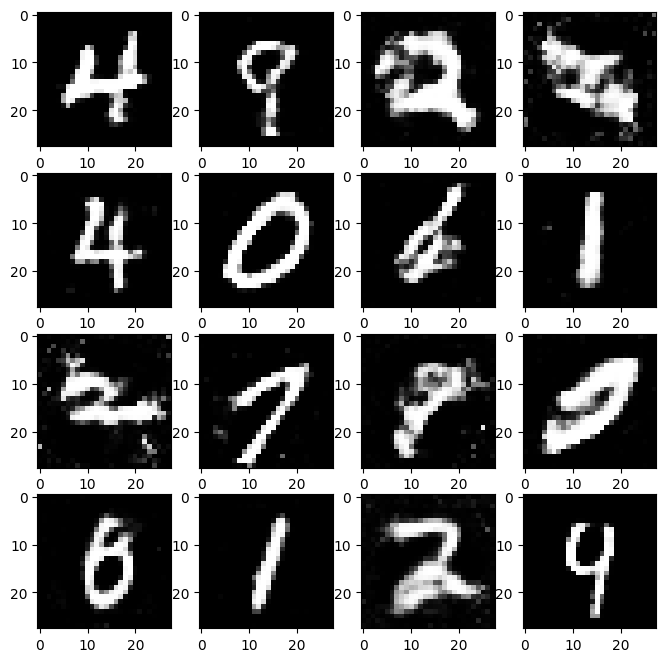

Epoch 139/200 (69.0%): [0/70016] (0.0%) D Error: 1.3725 G Error: 0.8333


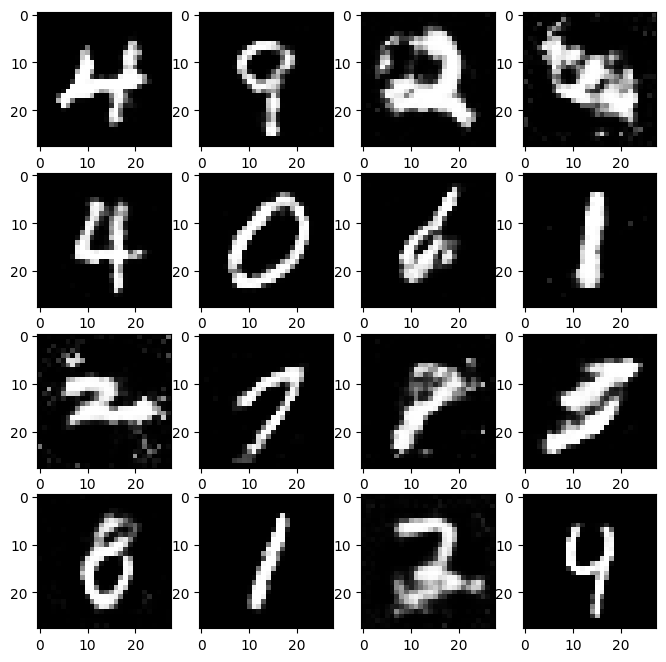

Epoch 140/200 (69.5%): [0/70016] (0.0%) D Error: 1.3056 G Error: 0.8217


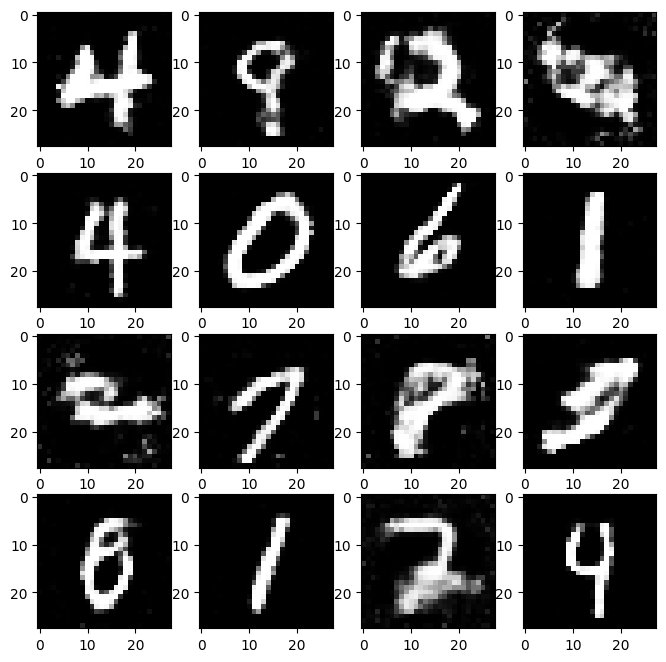

Epoch 141/200 (70.0%): [0/70016] (0.0%) D Error: 1.2744 G Error: 0.8758


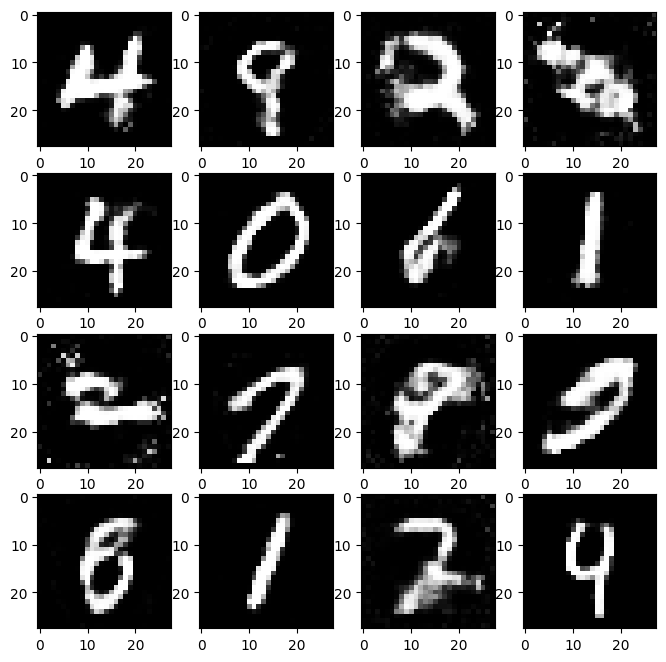

Epoch 142/200 (70.5%): [0/70016] (0.0%) D Error: 1.2635 G Error: 0.9478


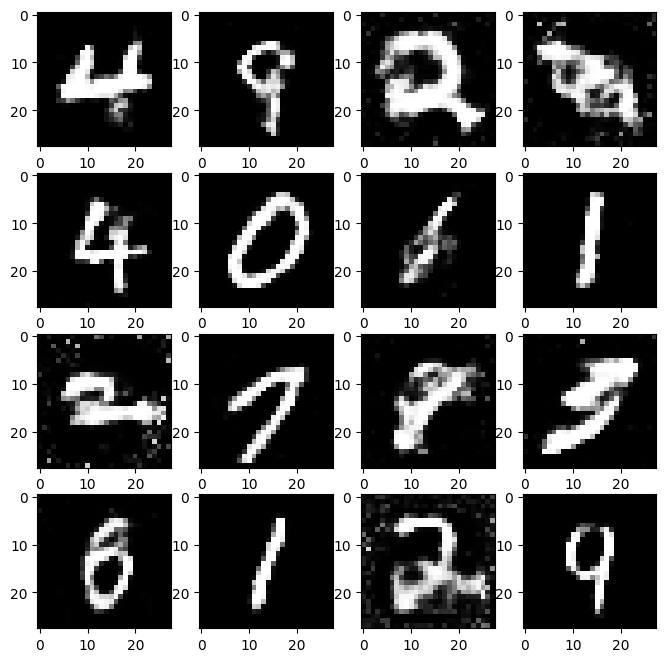

Epoch 143/200 (71.0%): [0/70016] (0.0%) D Error: 1.3387 G Error: 0.7977


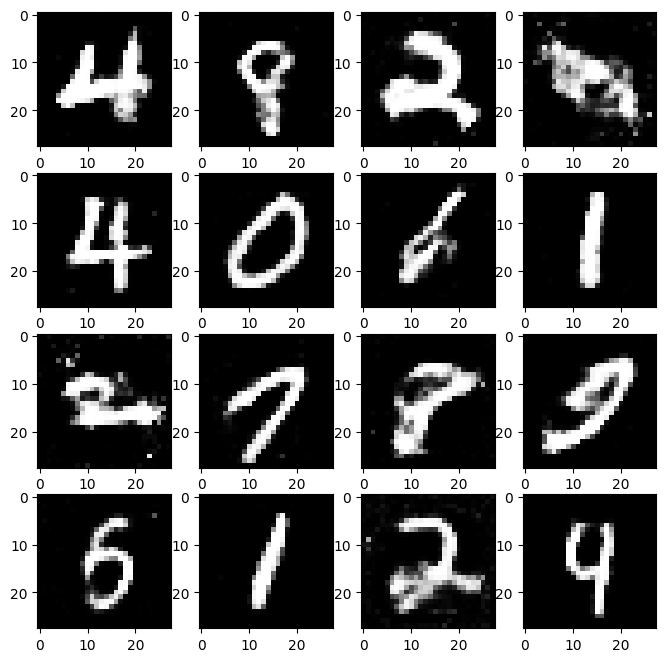

Epoch 144/200 (71.5%): [0/70016] (0.0%) D Error: 1.3437 G Error: 0.7772


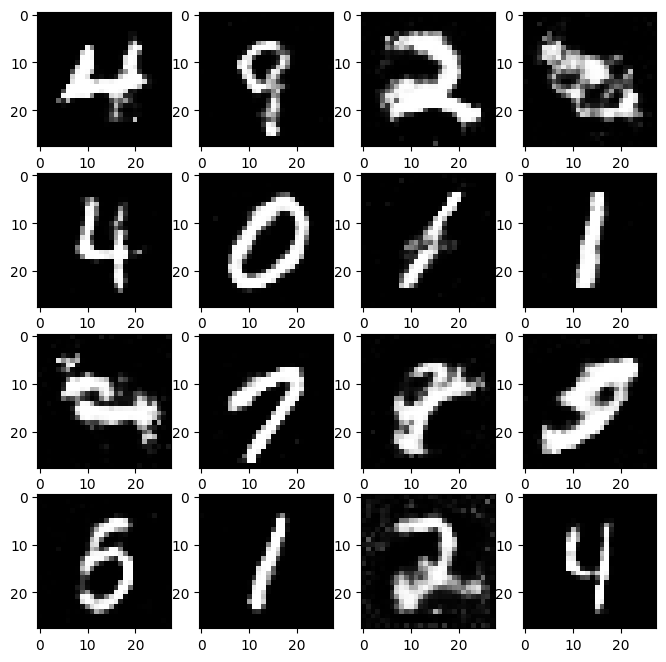

Epoch 145/200 (72.0%): [0/70016] (0.0%) D Error: 1.1940 G Error: 0.8636


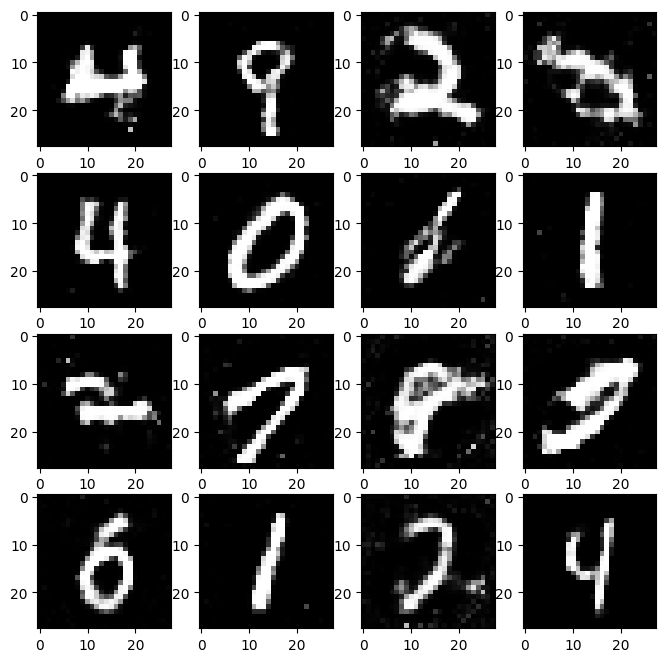

Epoch 146/200 (72.5%): [0/70016] (0.0%) D Error: 1.2189 G Error: 0.9327


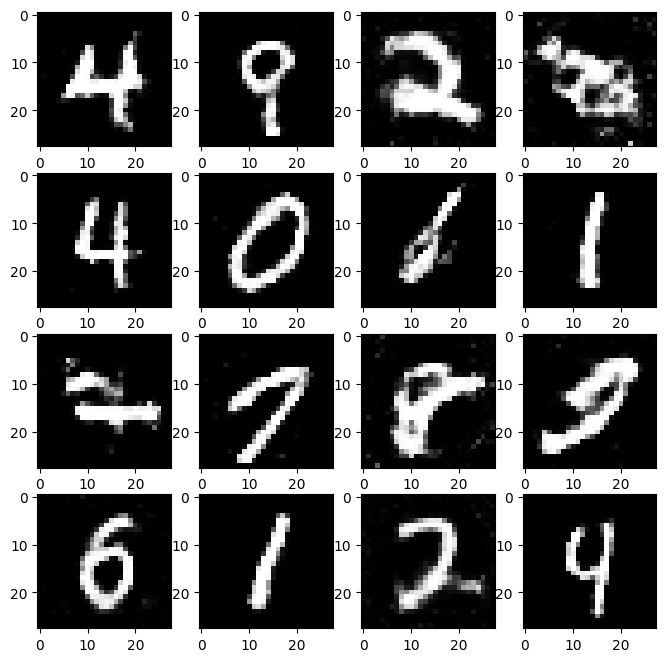

Epoch 147/200 (73.0%): [0/70016] (0.0%) D Error: 1.2586 G Error: 0.8919


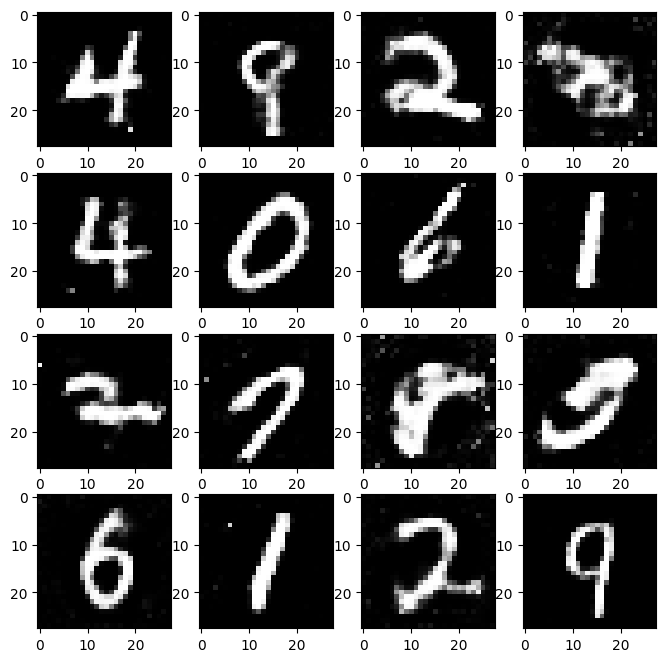

Epoch 148/200 (73.5%): [0/70016] (0.0%) D Error: 1.2762 G Error: 0.9484


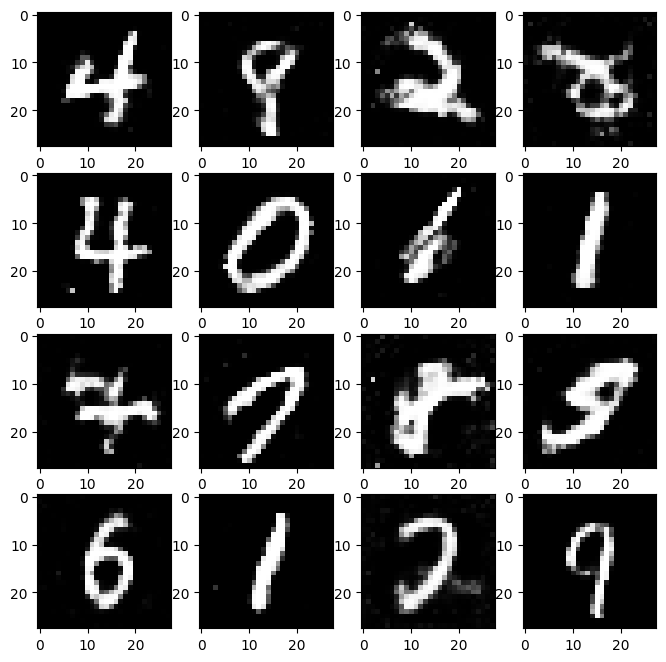

Epoch 149/200 (74.0%): [0/70016] (0.0%) D Error: 1.2587 G Error: 0.8135


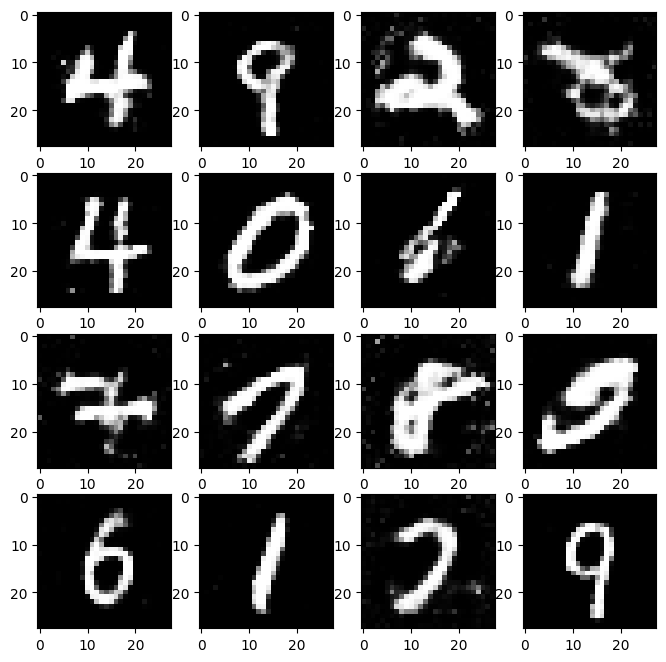

Epoch 150/200 (74.5%): [0/70016] (0.0%) D Error: 1.3249 G Error: 0.8577


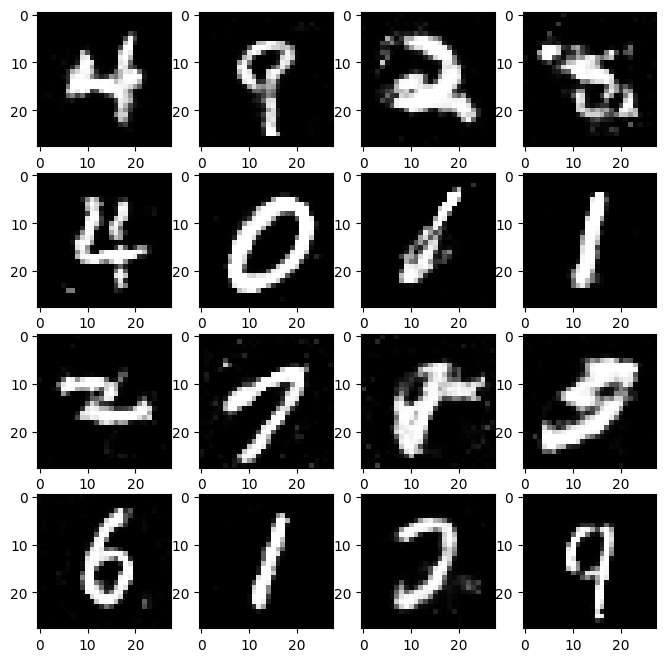

Epoch 151/200 (75.0%): [0/70016] (0.0%) D Error: 1.2775 G Error: 0.8063


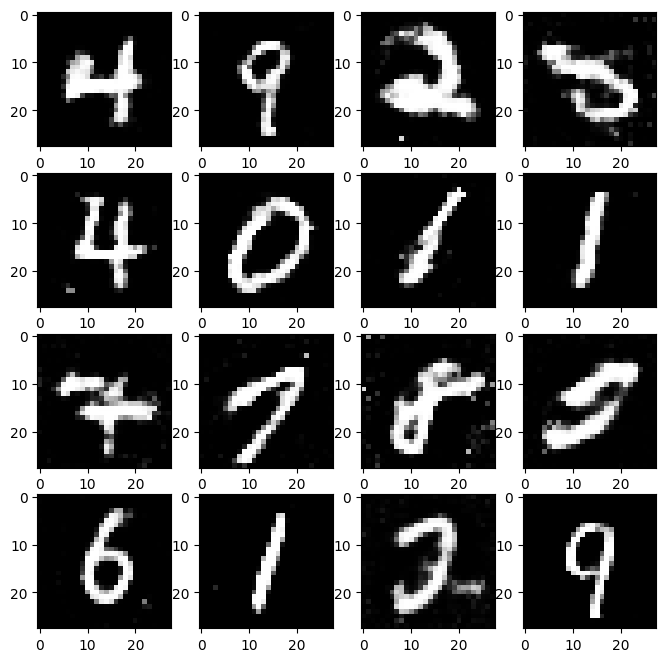

Epoch 152/200 (75.5%): [0/70016] (0.0%) D Error: 1.3744 G Error: 0.9017


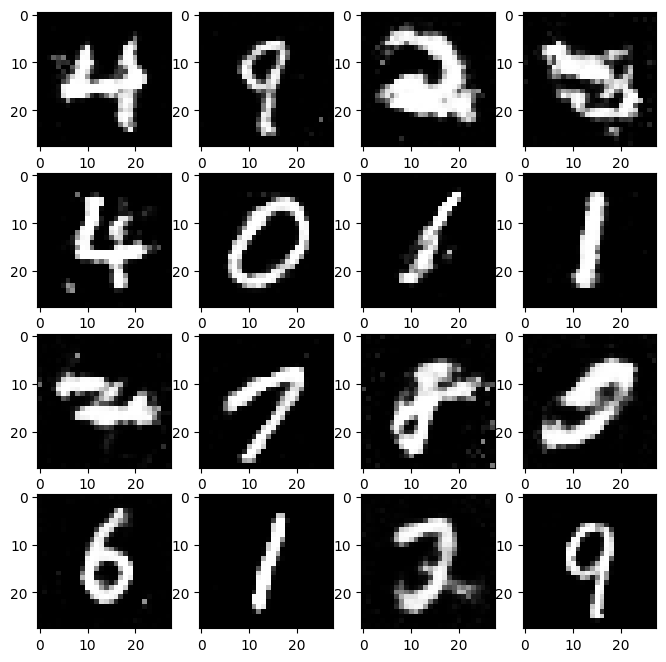

Epoch 153/200 (76.0%): [0/70016] (0.0%) D Error: 1.2534 G Error: 0.9069


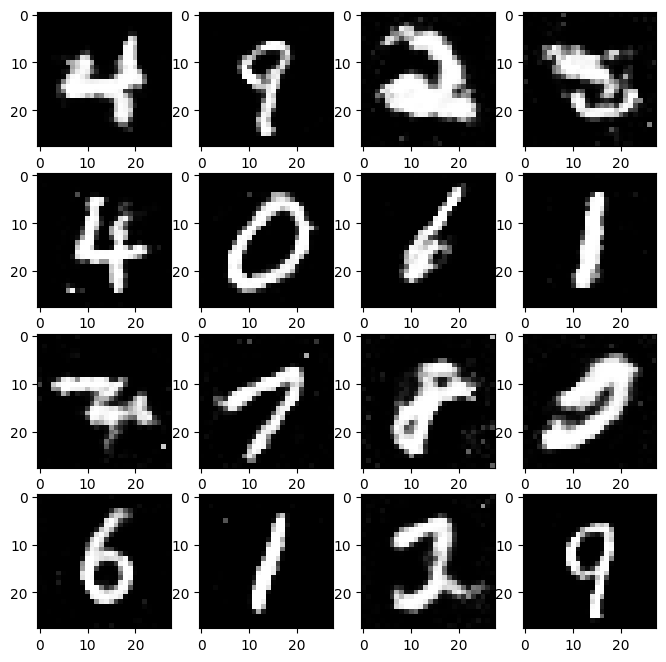

Epoch 154/200 (76.5%): [0/70016] (0.0%) D Error: 1.2522 G Error: 0.8977


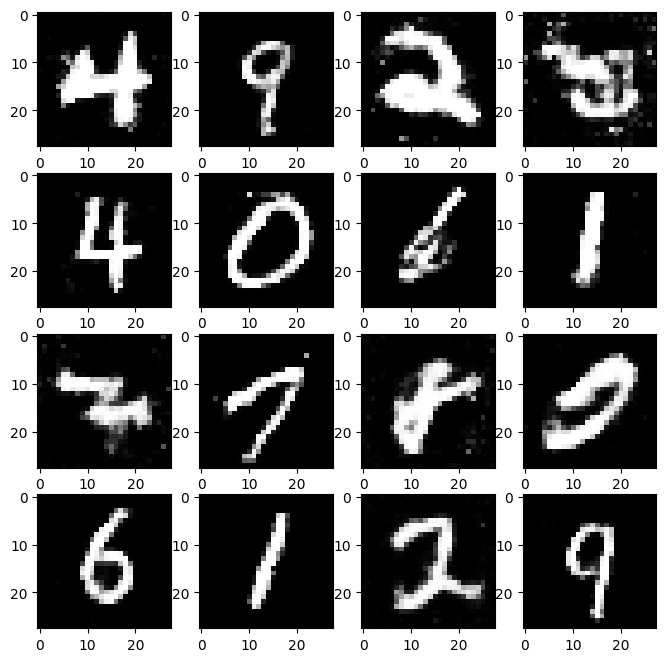

Epoch 155/200 (77.0%): [0/70016] (0.0%) D Error: 1.3319 G Error: 0.8421


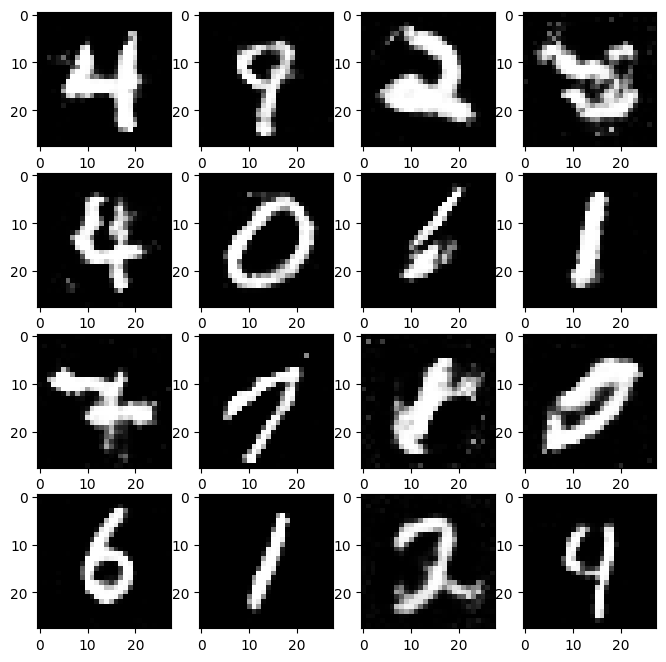

Epoch 156/200 (77.5%): [0/70016] (0.0%) D Error: 1.3019 G Error: 0.8908


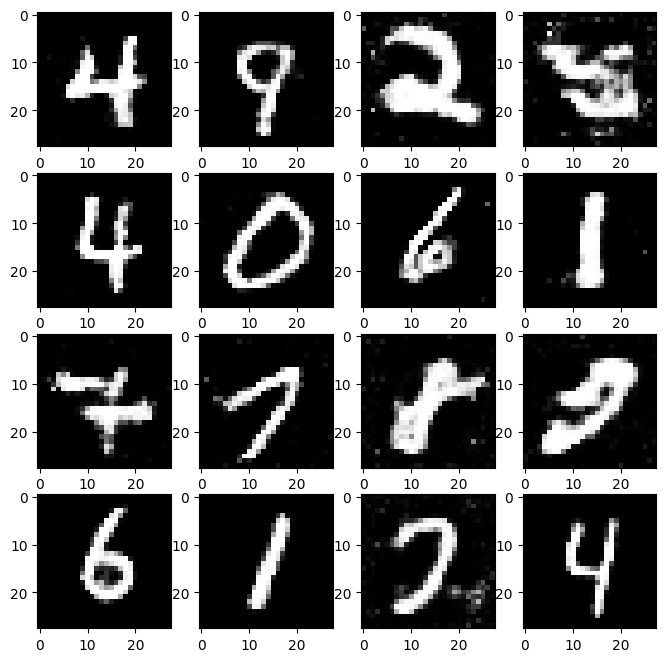

Epoch 157/200 (78.0%): [0/70016] (0.0%) D Error: 1.3121 G Error: 0.9250


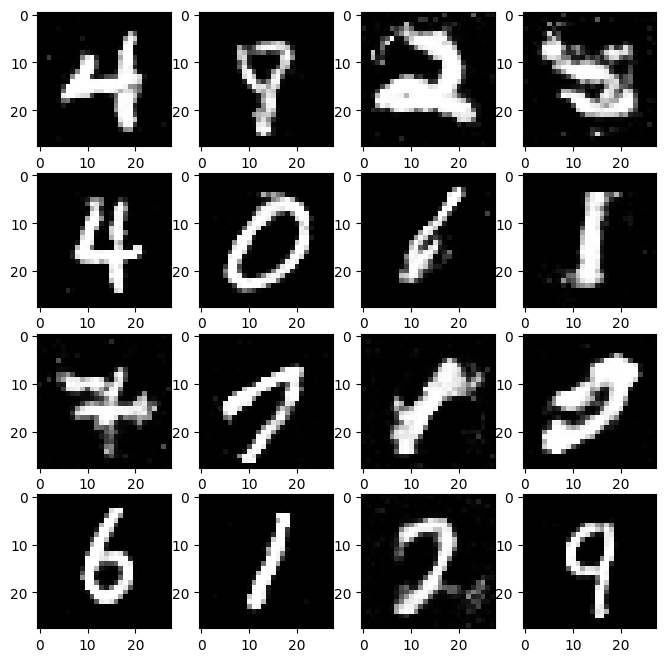

Epoch 158/200 (78.5%): [0/70016] (0.0%) D Error: 1.2424 G Error: 0.8624


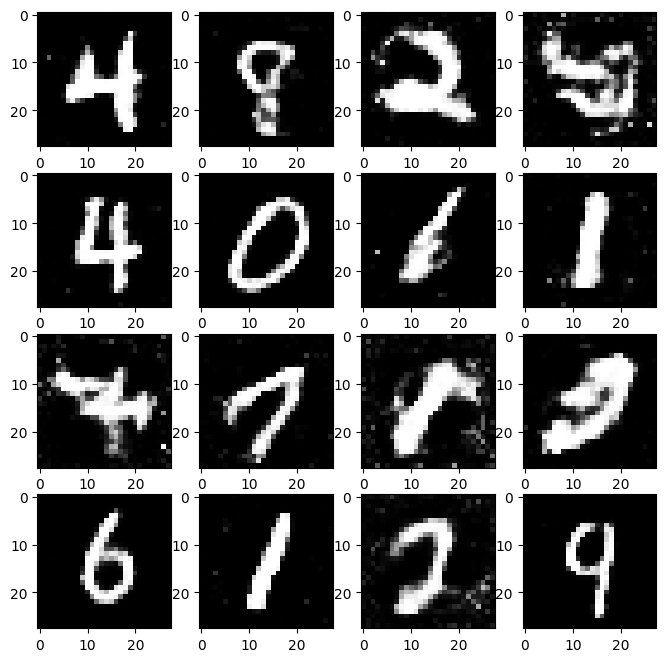

Epoch 159/200 (79.0%): [0/70016] (0.0%) D Error: 1.3858 G Error: 0.8244


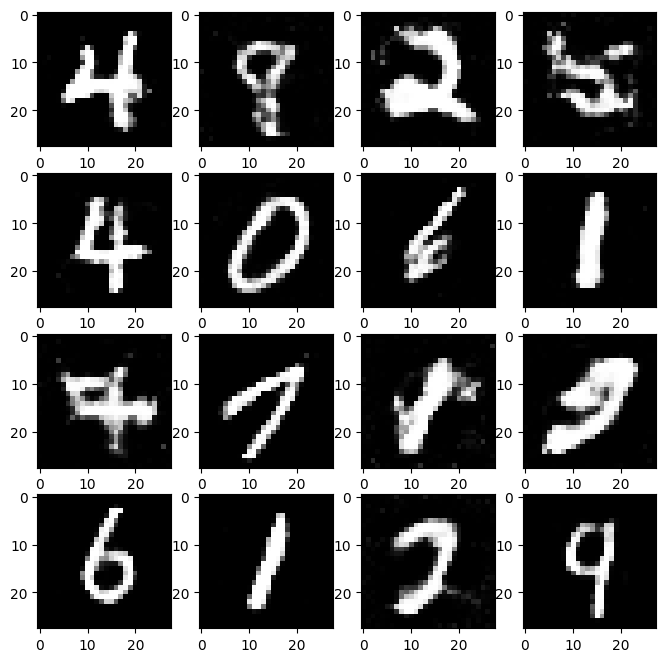

Epoch 160/200 (79.5%): [0/70016] (0.0%) D Error: 1.3309 G Error: 0.8059


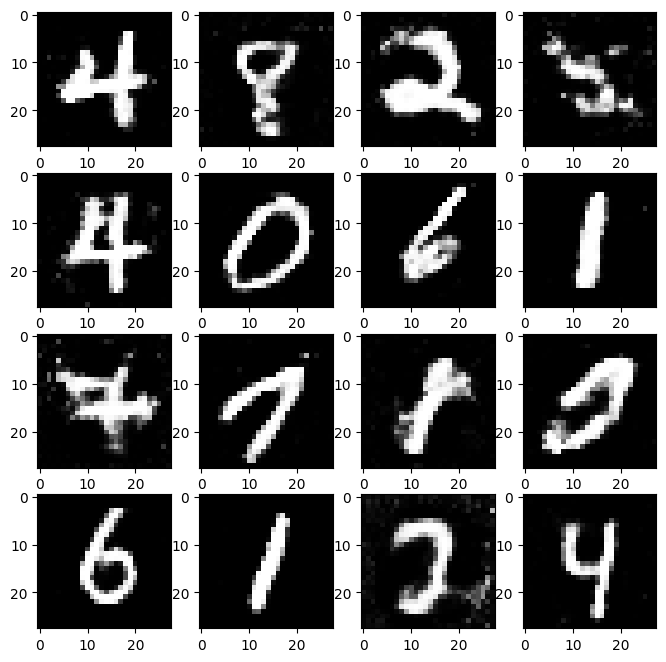

Epoch 161/200 (80.0%): [0/70016] (0.0%) D Error: 1.3845 G Error: 0.7899


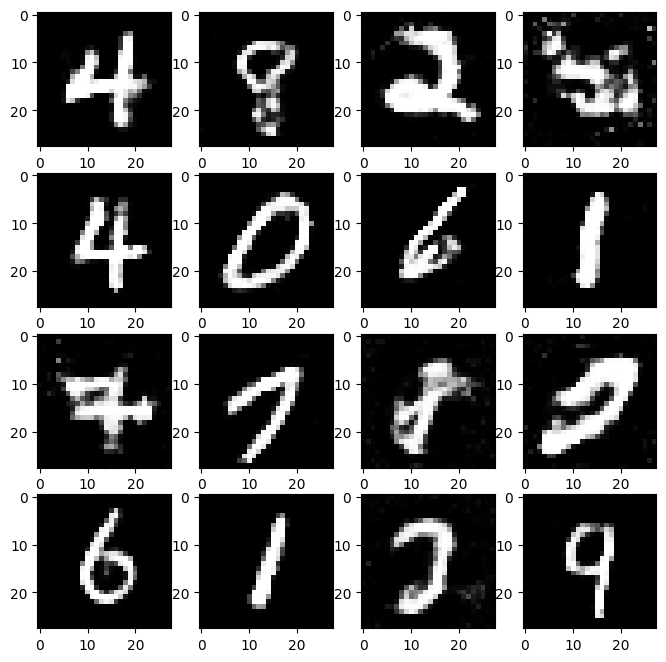

Epoch 162/200 (80.5%): [0/70016] (0.0%) D Error: 1.3335 G Error: 0.9128


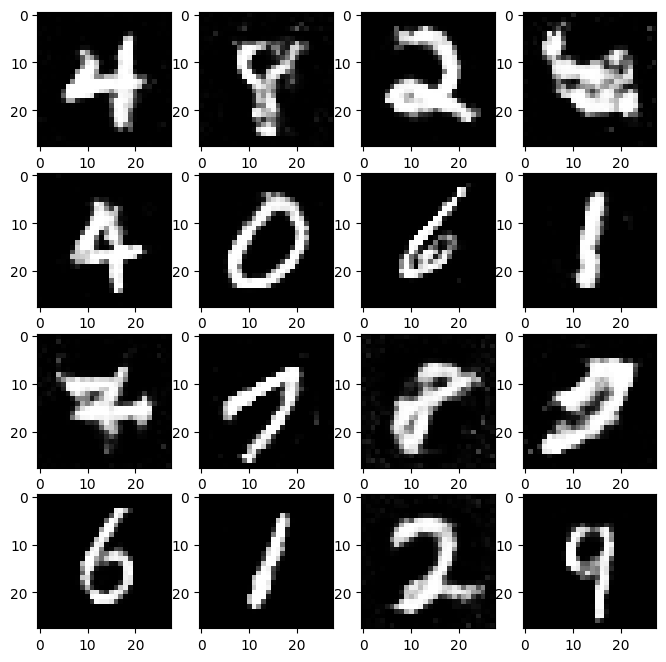

Epoch 163/200 (81.0%): [0/70016] (0.0%) D Error: 1.2622 G Error: 0.8567


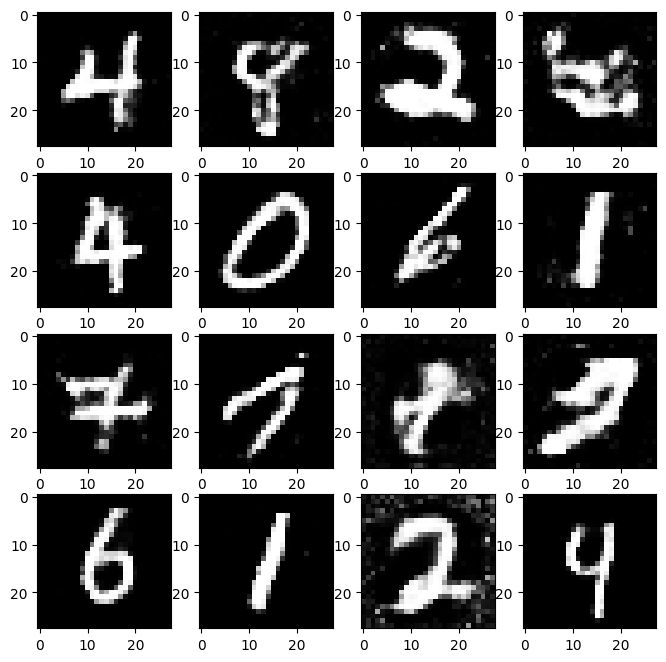

Epoch 164/200 (81.5%): [0/70016] (0.0%) D Error: 1.2278 G Error: 0.8622


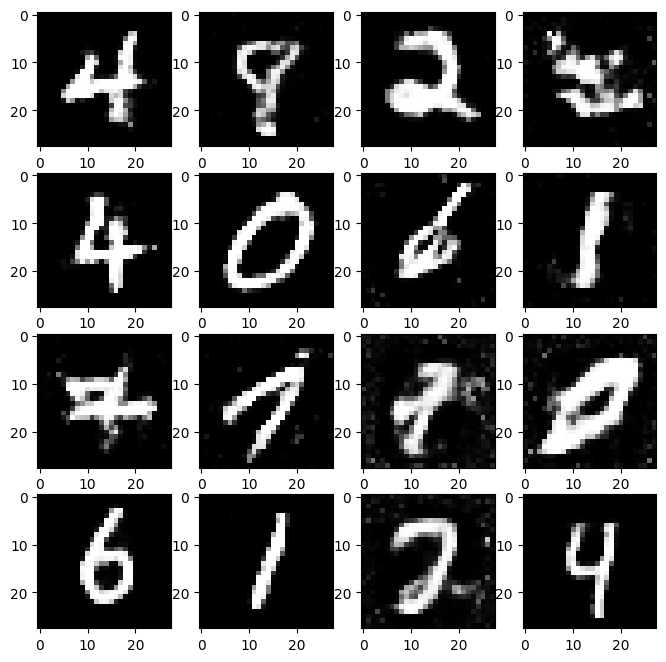

Epoch 165/200 (82.0%): [0/70016] (0.0%) D Error: 1.2579 G Error: 0.8385


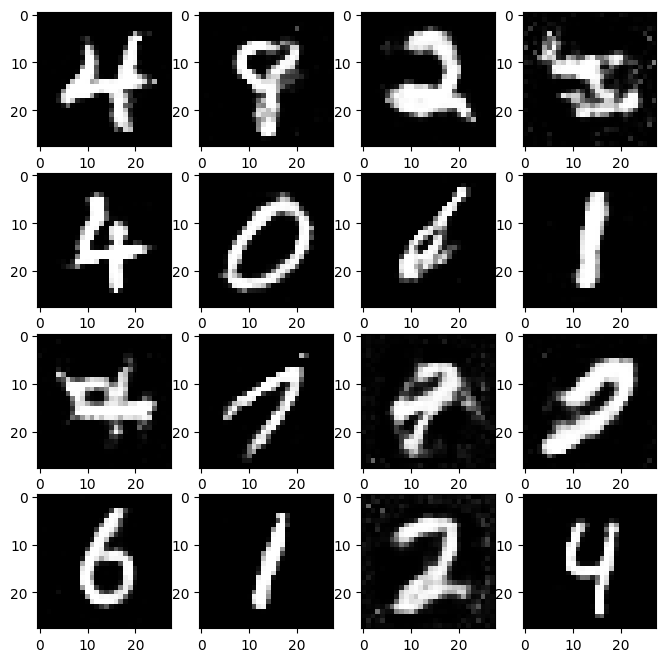

Epoch 166/200 (82.5%): [0/70016] (0.0%) D Error: 1.2610 G Error: 0.8903


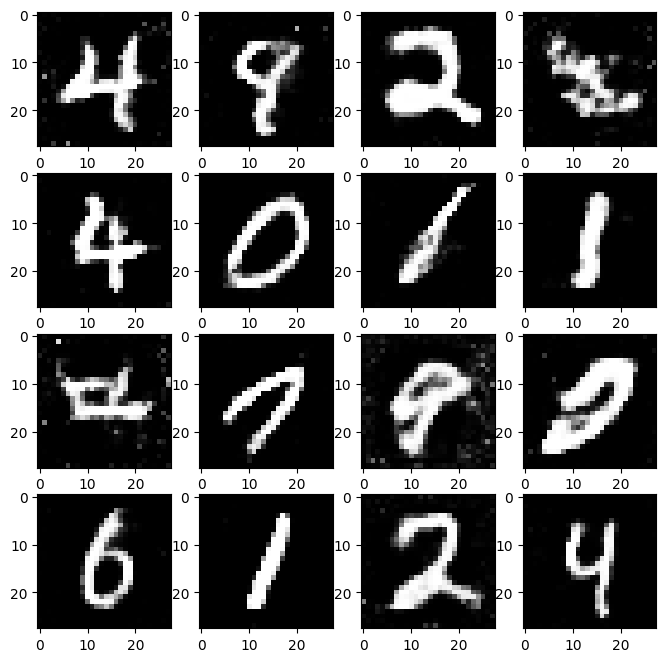

Epoch 167/200 (83.0%): [0/70016] (0.0%) D Error: 1.3147 G Error: 0.8185


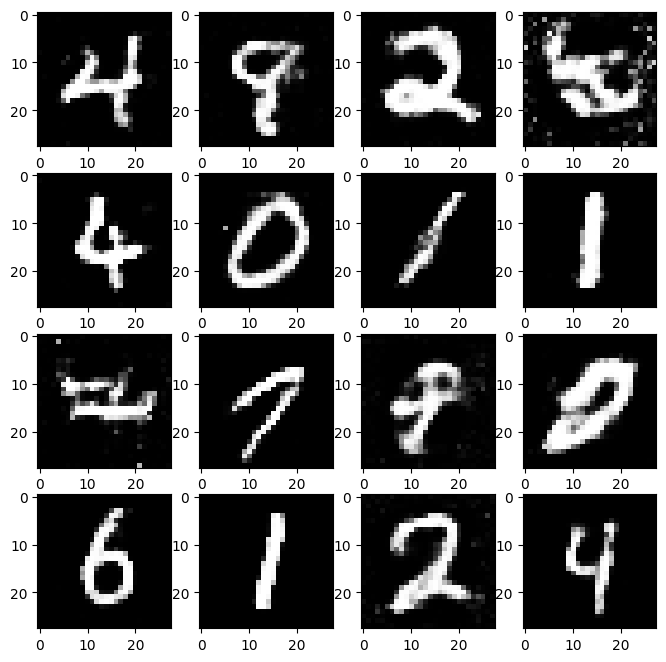

Epoch 168/200 (83.5%): [0/70016] (0.0%) D Error: 1.2849 G Error: 0.8125


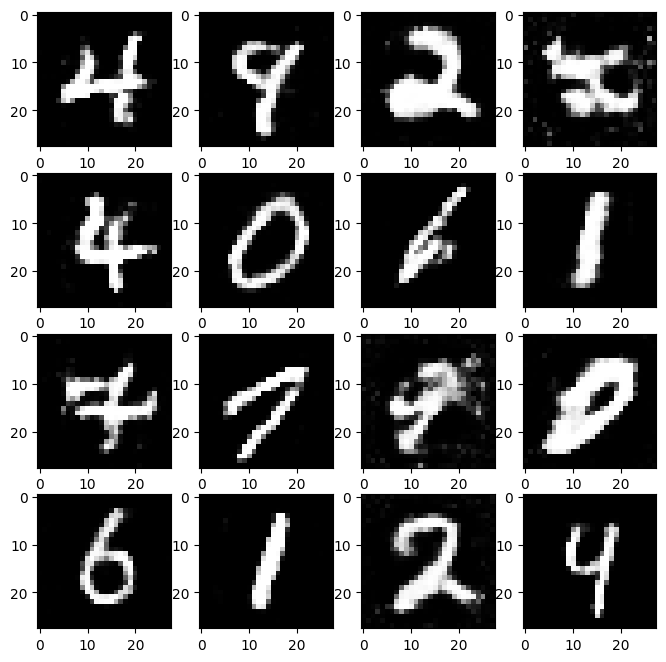

Epoch 169/200 (84.0%): [0/70016] (0.0%) D Error: 1.2519 G Error: 0.9297


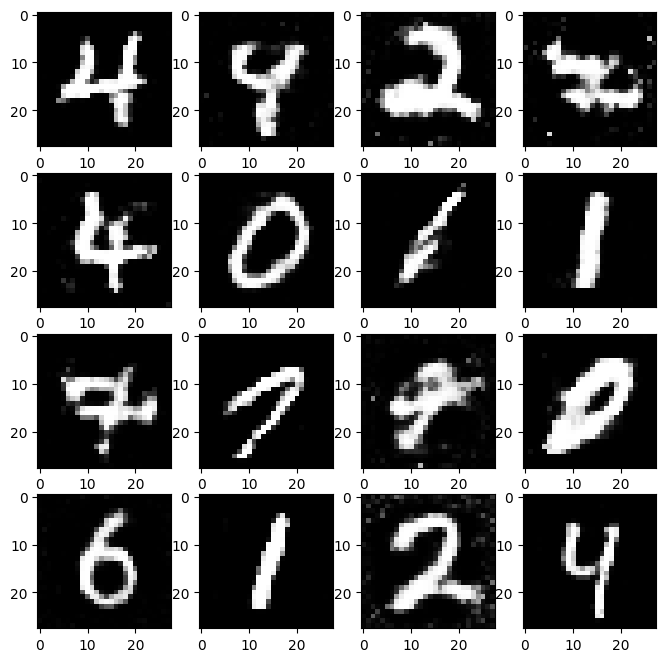

Epoch 170/200 (84.5%): [0/70016] (0.0%) D Error: 1.3181 G Error: 0.8907


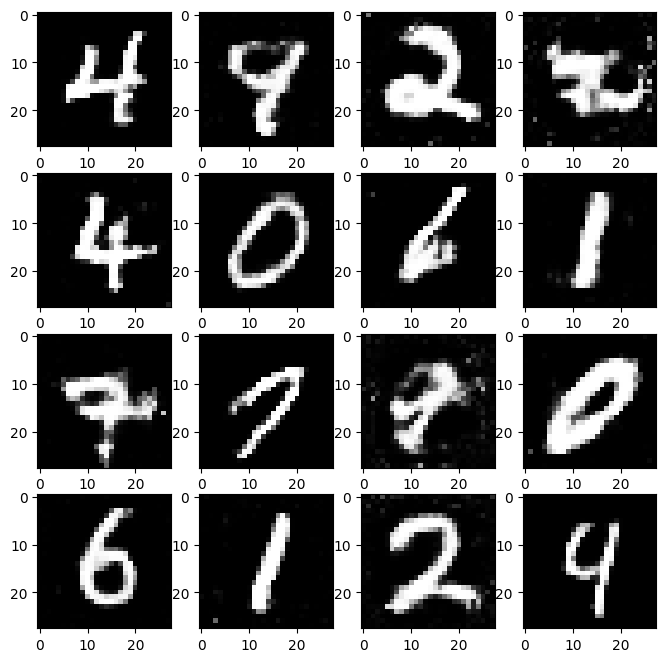

Epoch 171/200 (85.0%): [0/70016] (0.0%) D Error: 1.3493 G Error: 0.8362


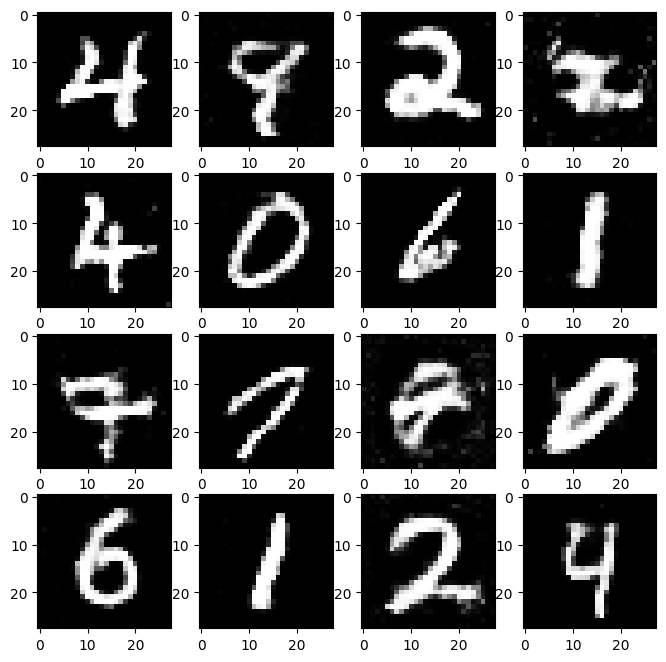

Epoch 172/200 (85.5%): [0/70016] (0.0%) D Error: 1.2824 G Error: 0.8594


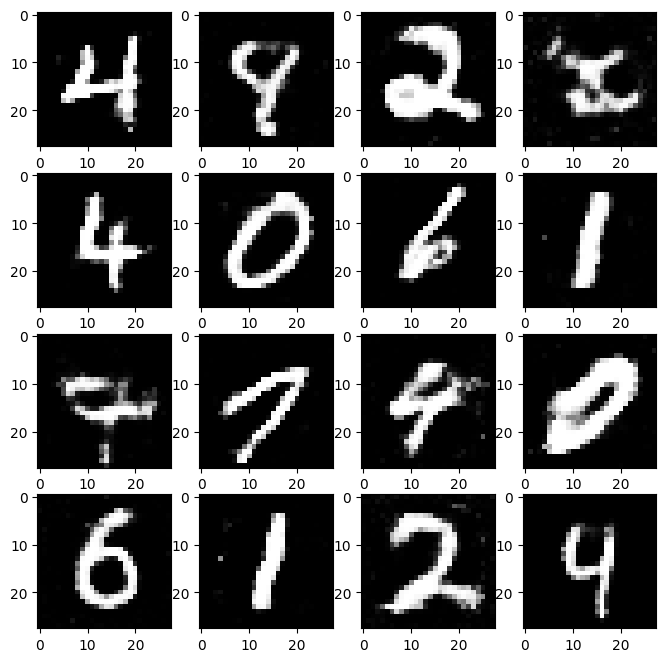

Epoch 173/200 (86.0%): [0/70016] (0.0%) D Error: 1.2973 G Error: 0.8500


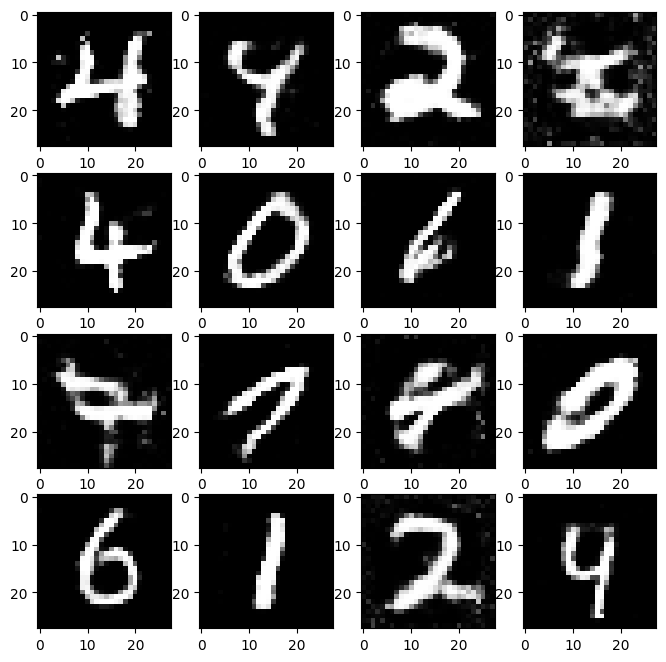

Epoch 174/200 (86.5%): [0/70016] (0.0%) D Error: 1.3557 G Error: 0.8486


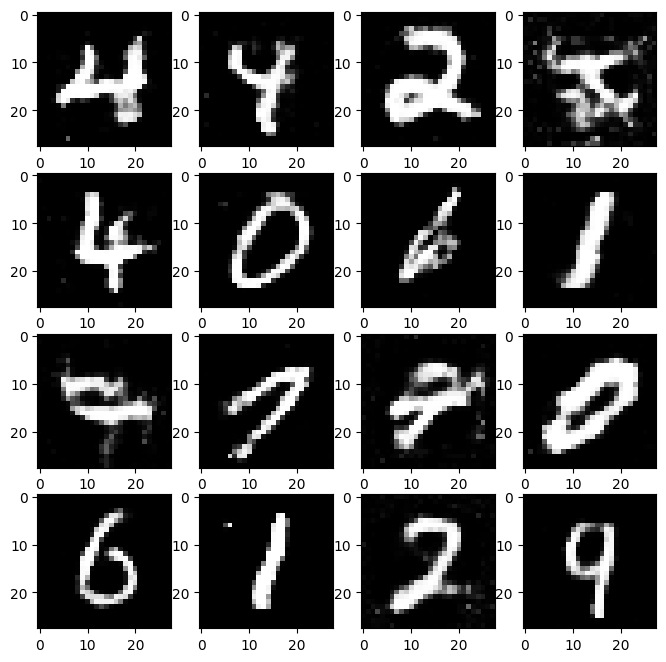

Epoch 175/200 (87.0%): [0/70016] (0.0%) D Error: 1.3322 G Error: 0.8417


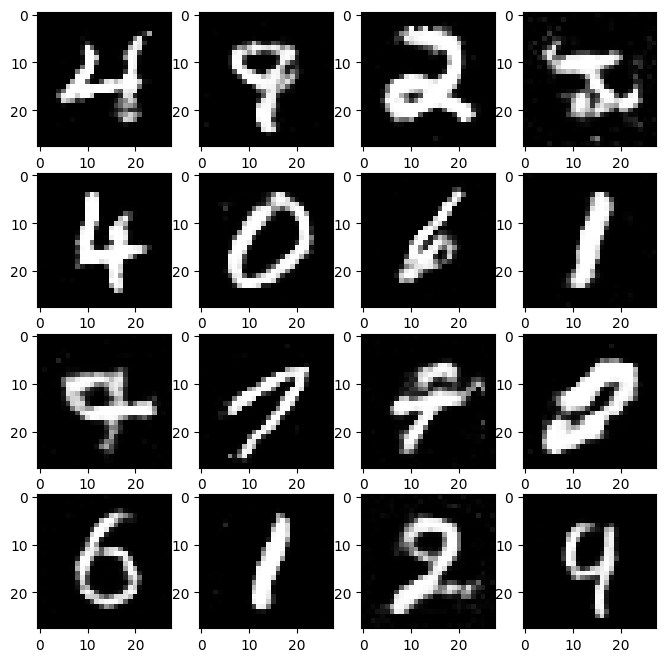

Epoch 176/200 (87.5%): [0/70016] (0.0%) D Error: 1.2663 G Error: 0.8915


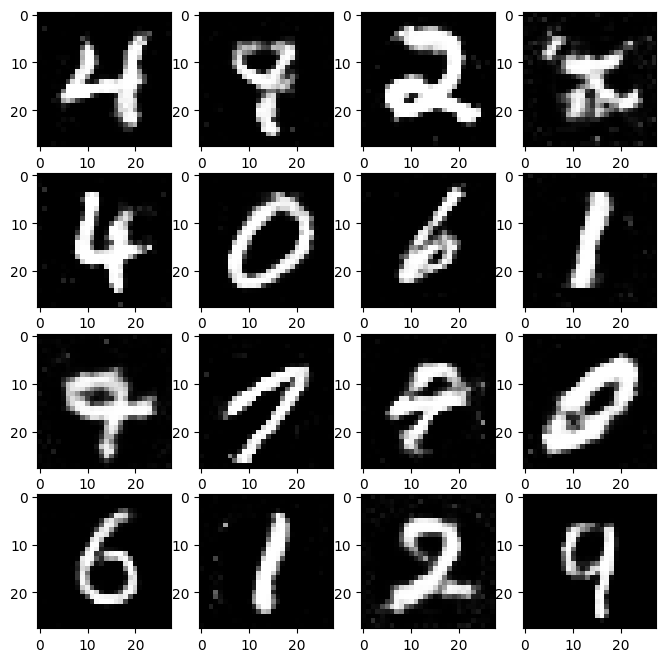

Epoch 177/200 (88.0%): [0/70016] (0.0%) D Error: 1.3474 G Error: 0.8178


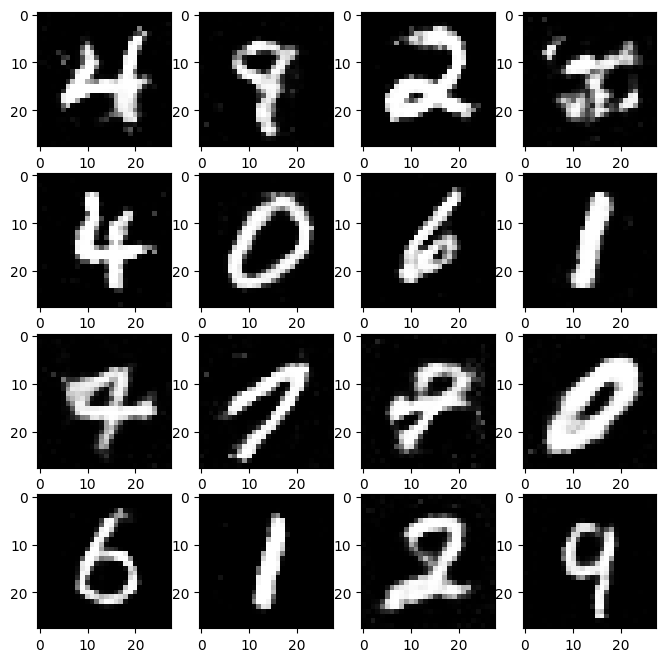

Epoch 178/200 (88.5%): [0/70016] (0.0%) D Error: 1.2672 G Error: 0.8334


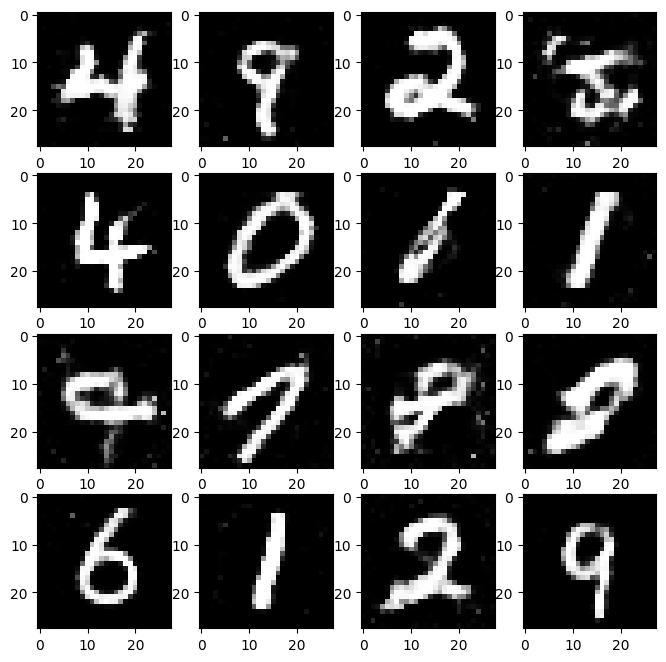

Epoch 179/200 (89.0%): [0/70016] (0.0%) D Error: 1.2553 G Error: 0.8006


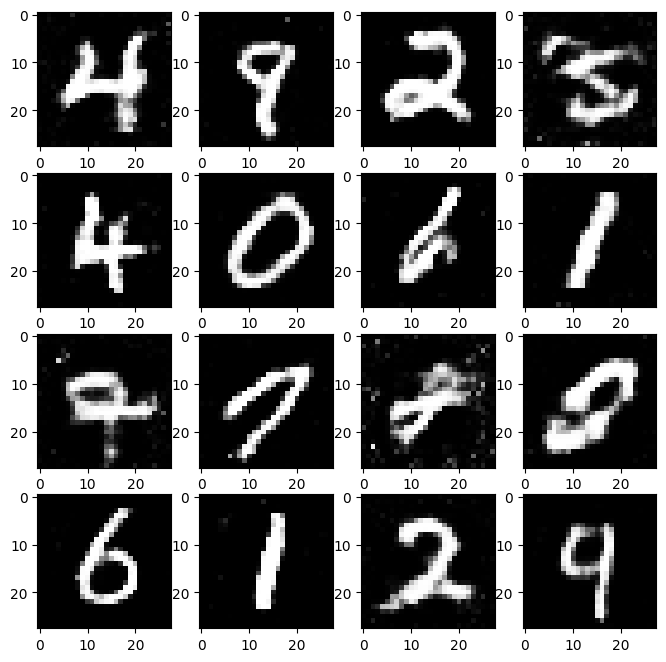

Epoch 180/200 (89.5%): [0/70016] (0.0%) D Error: 1.3587 G Error: 0.7862


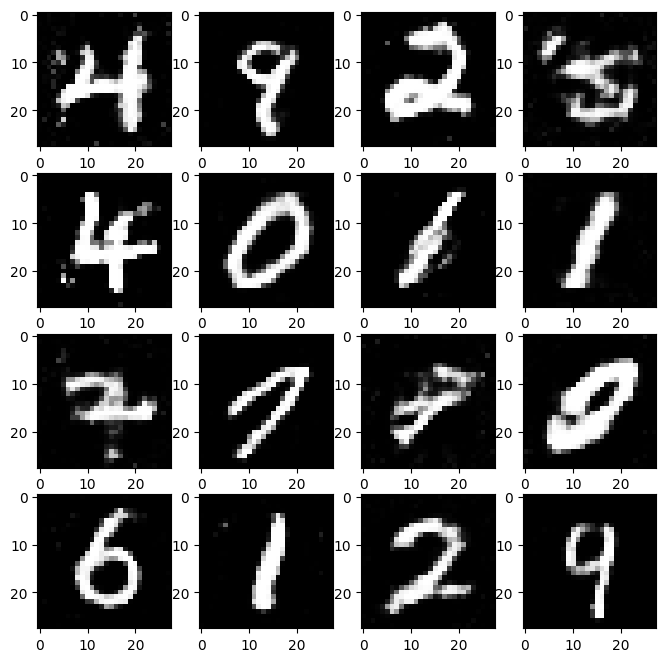

Epoch 181/200 (90.0%): [0/70016] (0.0%) D Error: 1.2609 G Error: 0.8081


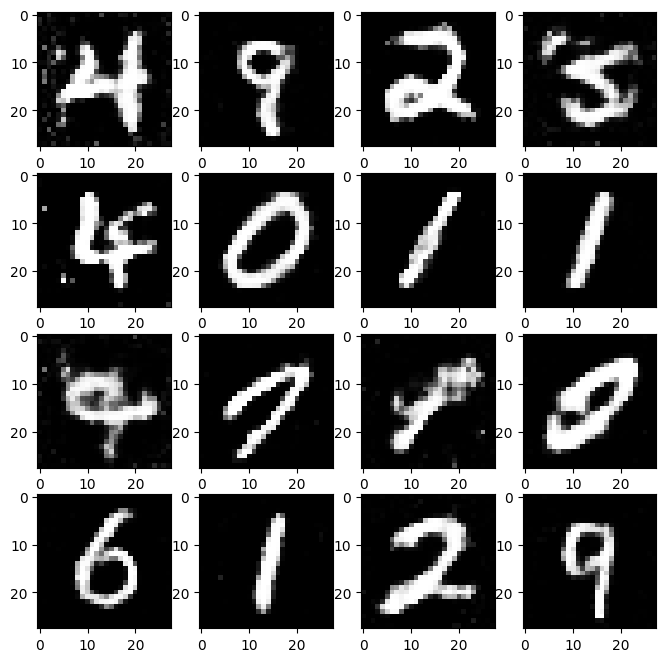

Epoch 182/200 (90.5%): [0/70016] (0.0%) D Error: 1.2831 G Error: 0.8680


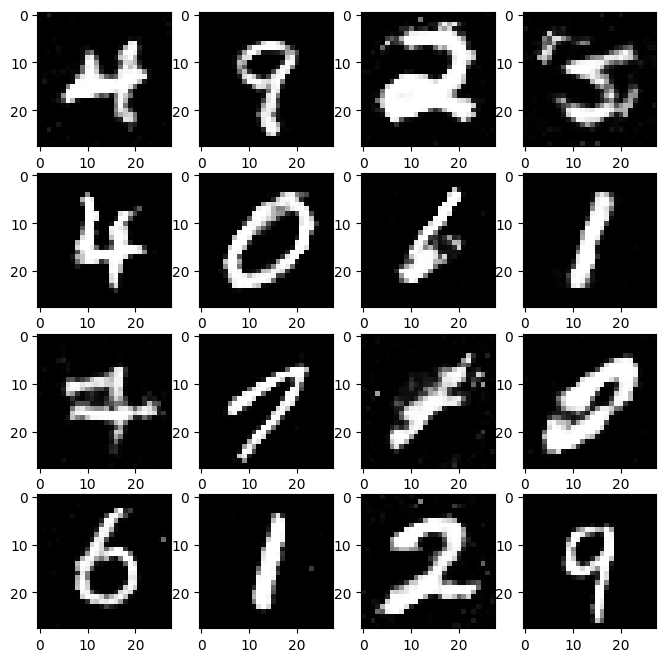

Epoch 183/200 (91.0%): [0/70016] (0.0%) D Error: 1.3394 G Error: 0.8823


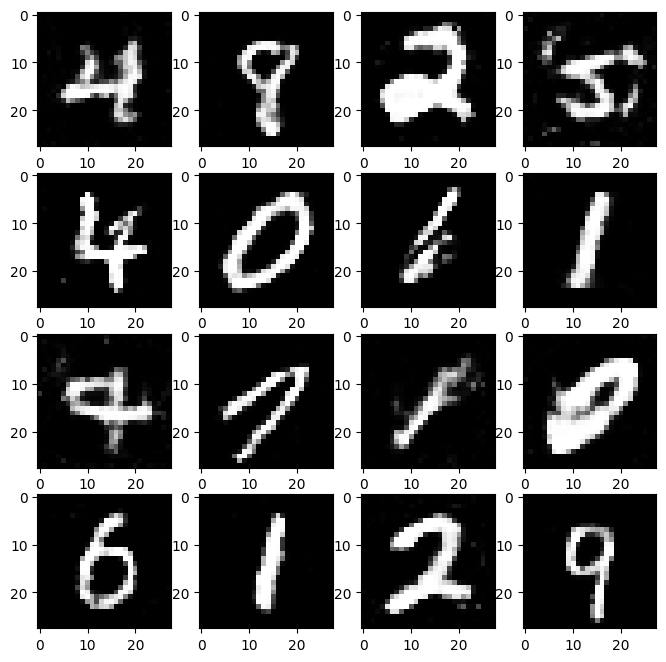

Epoch 184/200 (91.5%): [0/70016] (0.0%) D Error: 1.2724 G Error: 0.8692


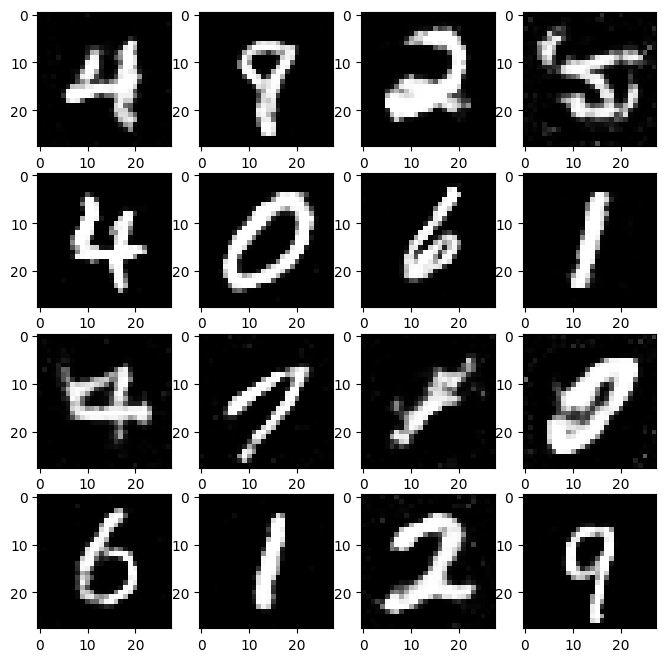

Epoch 185/200 (92.0%): [0/70016] (0.0%) D Error: 1.2996 G Error: 0.8414


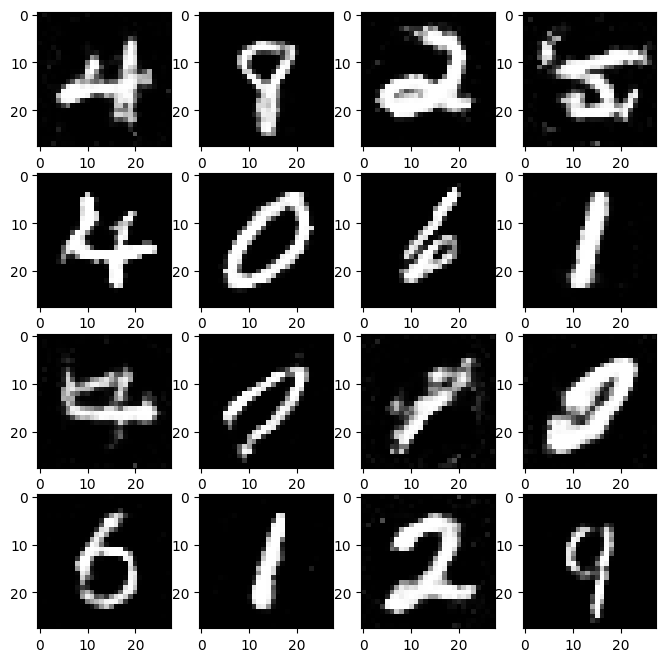

Epoch 186/200 (92.5%): [0/70016] (0.0%) D Error: 1.2808 G Error: 0.8983


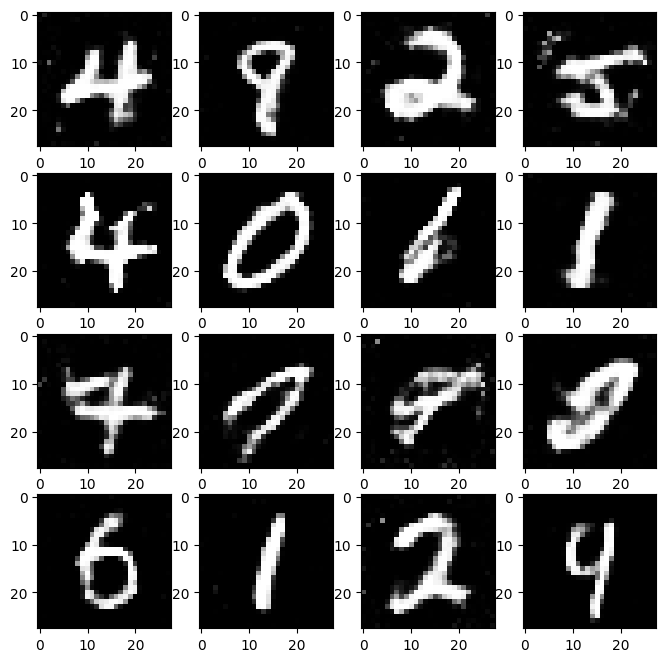

Epoch 187/200 (93.0%): [0/70016] (0.0%) D Error: 1.2440 G Error: 0.9044


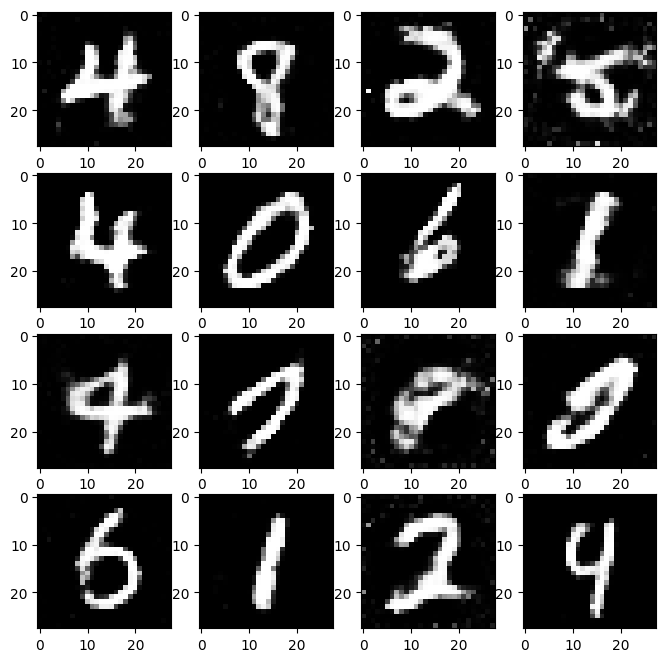

Epoch 188/200 (93.5%): [0/70016] (0.0%) D Error: 1.3239 G Error: 0.8613


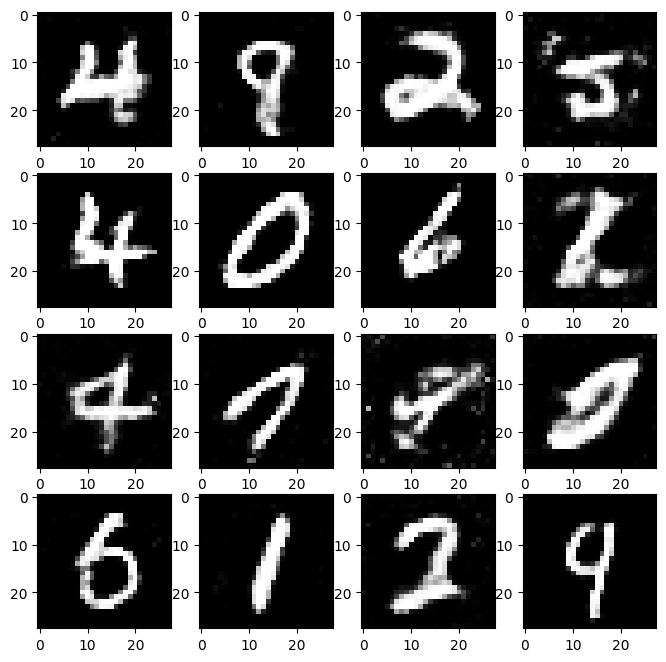

Epoch 189/200 (94.0%): [0/70016] (0.0%) D Error: 1.3366 G Error: 0.8365


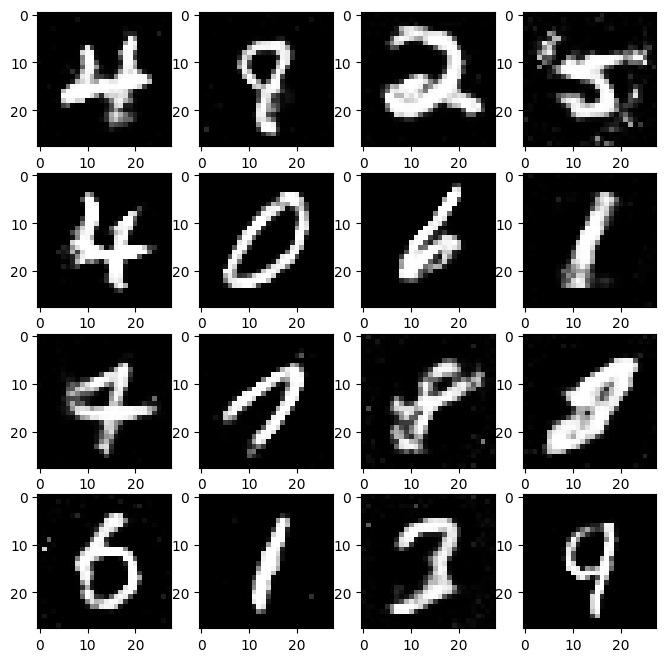

Epoch 190/200 (94.5%): [0/70016] (0.0%) D Error: 1.2501 G Error: 0.8242


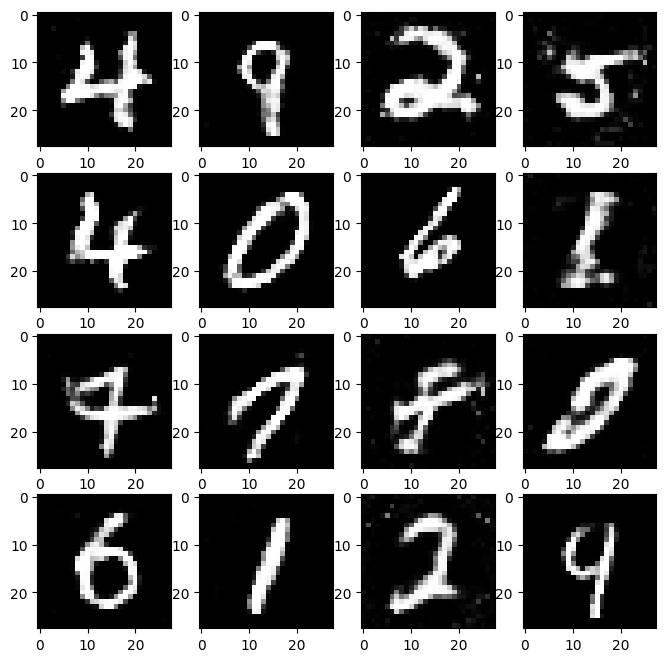

Epoch 191/200 (95.0%): [0/70016] (0.0%) D Error: 1.2580 G Error: 0.8247


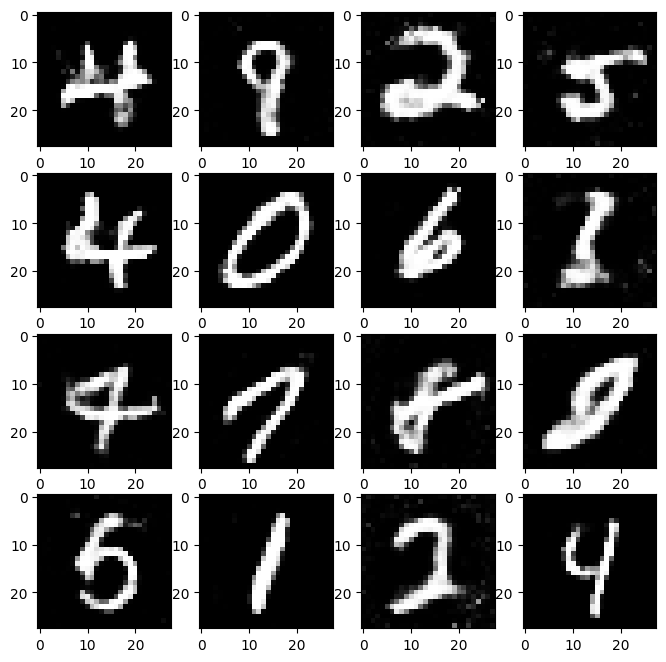

Epoch 192/200 (95.5%): [0/70016] (0.0%) D Error: 1.2882 G Error: 0.9278


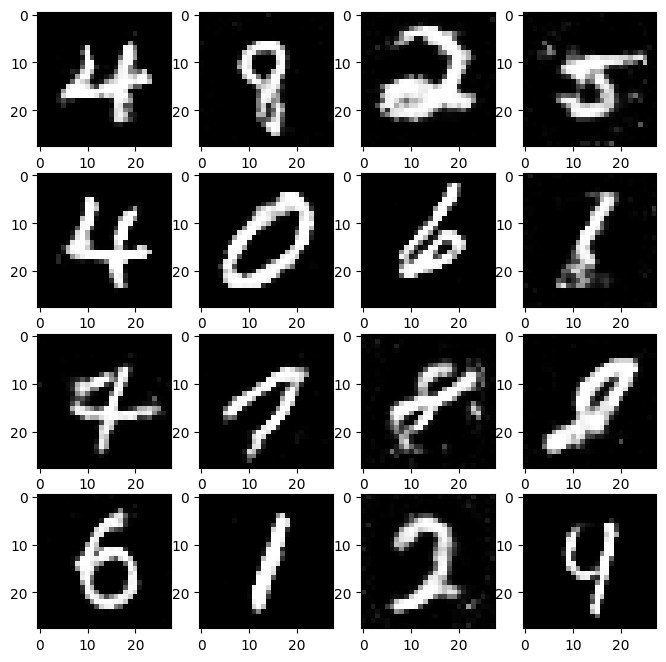

Epoch 193/200 (96.0%): [0/70016] (0.0%) D Error: 1.2495 G Error: 0.8604


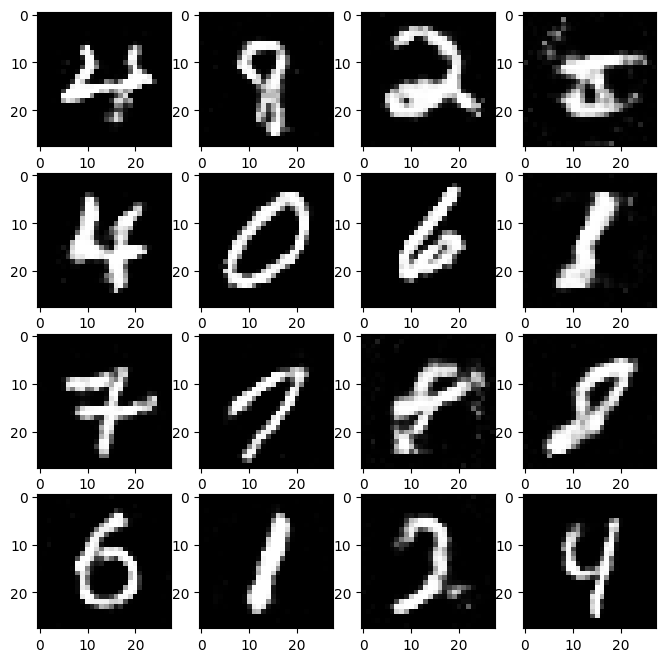

Epoch 194/200 (96.5%): [0/70016] (0.0%) D Error: 1.2546 G Error: 0.8246


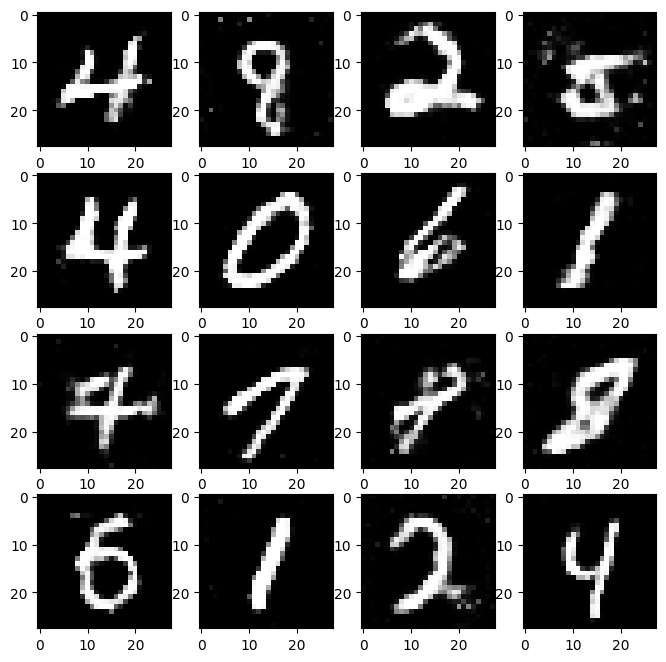

Epoch 195/200 (97.0%): [0/70016] (0.0%) D Error: 1.2743 G Error: 0.9576


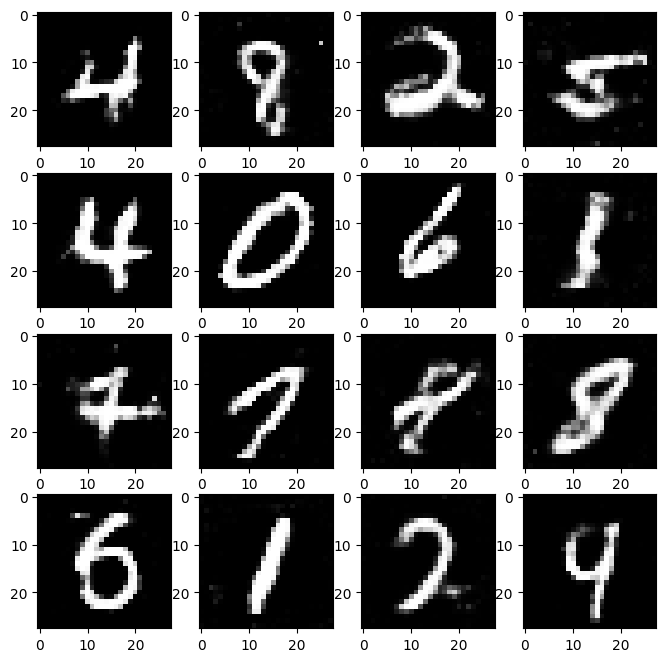

Epoch 196/200 (97.5%): [0/70016] (0.0%) D Error: 1.3458 G Error: 0.8508


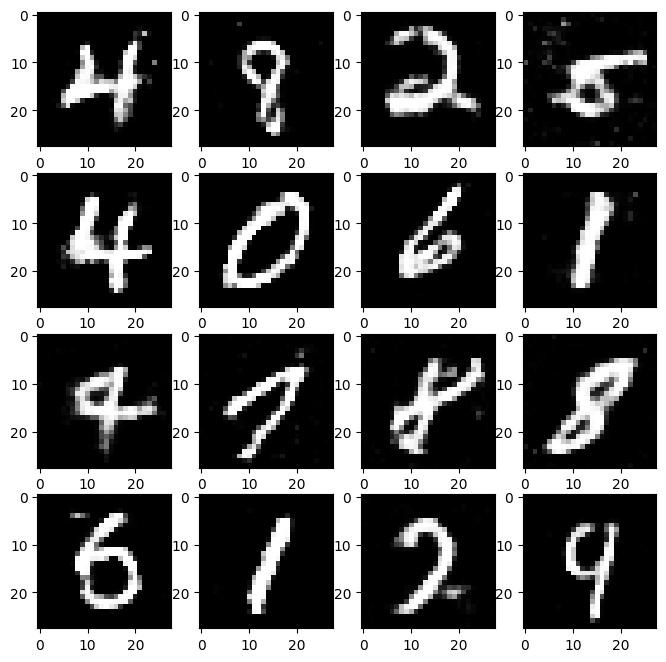

Epoch 197/200 (98.0%): [0/70016] (0.0%) D Error: 1.2589 G Error: 0.8420


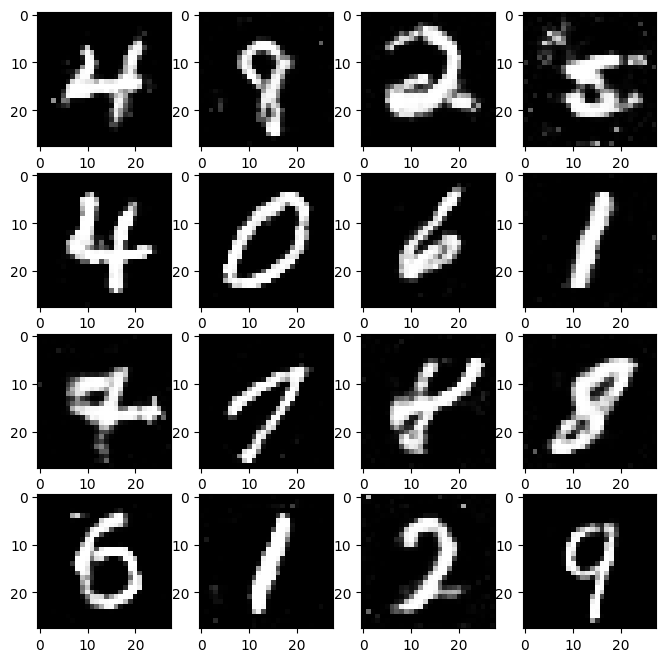

Epoch 198/200 (98.5%): [0/70016] (0.0%) D Error: 1.3167 G Error: 0.8459


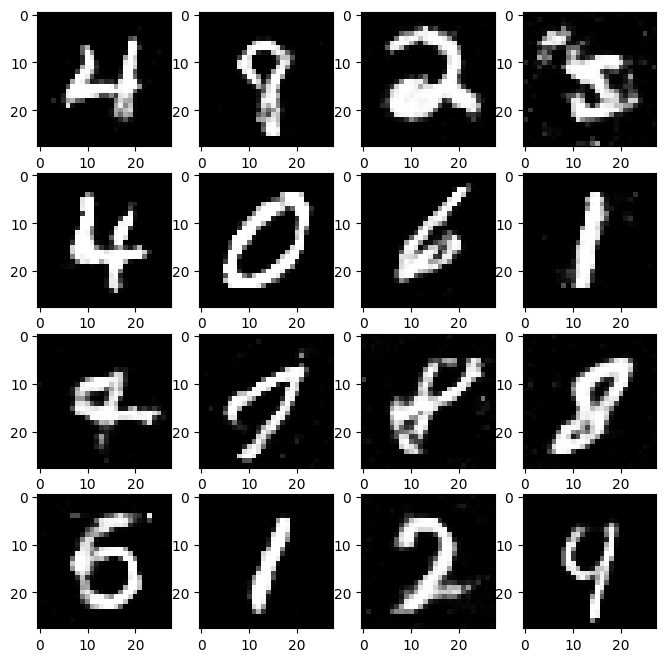

Epoch 199/200 (99.0%): [0/70016] (0.0%) D Error: 1.4128 G Error: 0.8610


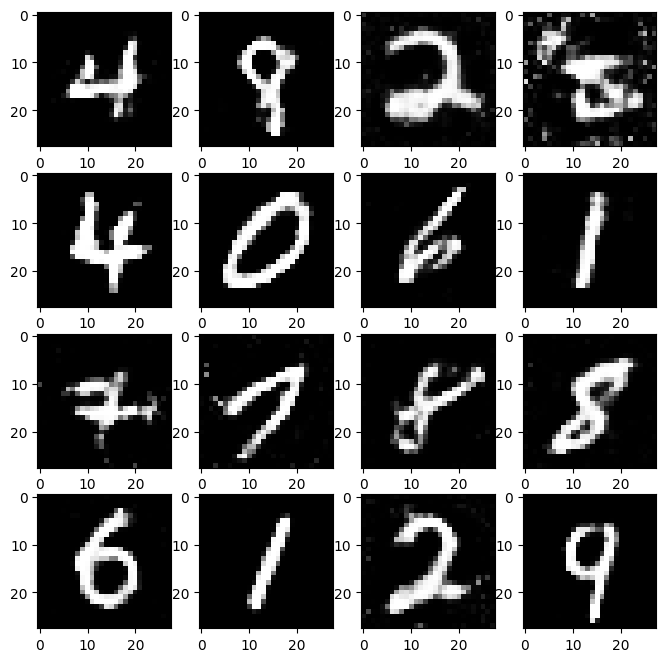

Epoch 200/200 (99.5%): [0/70016] (0.0%) D Error: 1.2742 G Error: 0.9585


In [31]:
# discriminator = DiscriminatorModel().to(device)
# generator = GeneratorModel().to(device)

# loss_fn = nn.BCELoss()

# d_optimizer = Adam(discriminator.parameters(), lr=0.0002)
# g_optimizer = Adam(generator.parameters(), lr=0.0002)

for epoch in range(EPOCHS):
    for batch_idx, (batch, _) in enumerate(data_loader):
        # === Train D ===
        # real_data = imgs_to_vec(batch.to(device))
        real_data = imgs_to_vec(batch).to(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake, = train_discriminator(discriminator, d_optimizer, loss_fn, real_data, fake_data)
        # === Train G ===
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(discriminator, g_optimizer, loss_fn, fake_data)
        # === Logging ===
        #log(d_error, g_error, epoch, batch_idx, len(data_loader))
        
        if (batch_idx % DISPLAY_EVERY) == 0:
            test_images = vec_to_imgs(generator(test_noise)).data.cpu()
            display_images(test_images)
            # Logging
            display_logs(epoch, EPOCHS, batch_idx, NUM_BATCHES, d_error, g_error, d_pred_real, d_pred_fake)

tensor([[0.4467]], device='cuda:0', grad_fn=<SigmoidBackward0>)


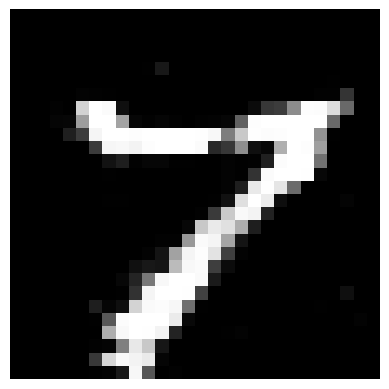

tensor([[0.4902]], device='cuda:0', grad_fn=<SigmoidBackward0>)


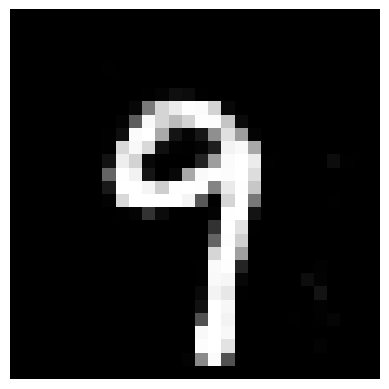

tensor([[0.4066]], device='cuda:0', grad_fn=<SigmoidBackward0>)


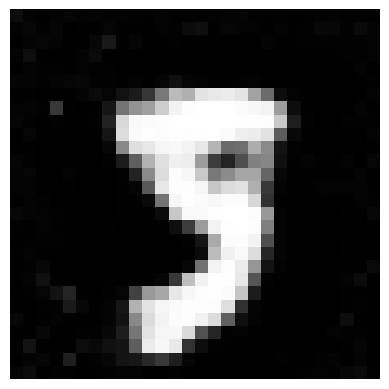

tensor([[0.4465]], device='cuda:0', grad_fn=<SigmoidBackward0>)


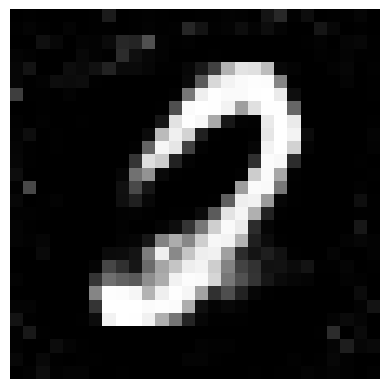

tensor([[0.6086]], device='cuda:0', grad_fn=<SigmoidBackward0>)


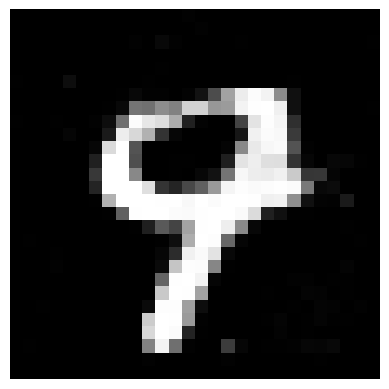

tensor([[0.6617]], device='cuda:0', grad_fn=<SigmoidBackward0>)


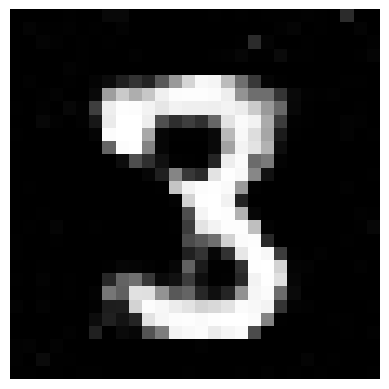

tensor([[0.7196]], device='cuda:0', grad_fn=<SigmoidBackward0>)


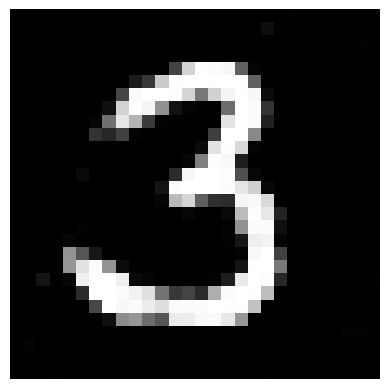

tensor([[0.4405]], device='cuda:0', grad_fn=<SigmoidBackward0>)


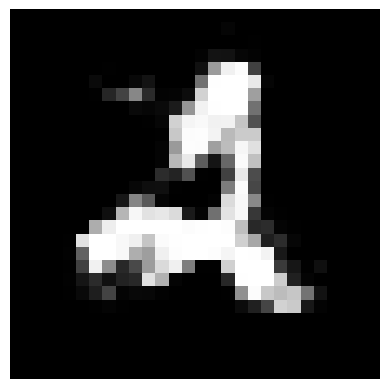

tensor([[0.4252]], device='cuda:0', grad_fn=<SigmoidBackward0>)


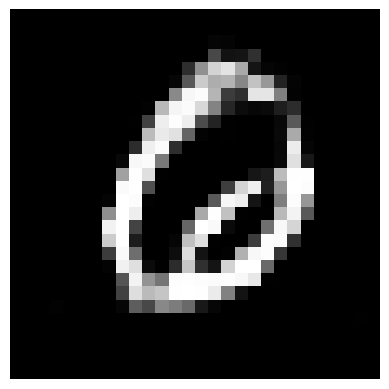

tensor([[0.4091]], device='cuda:0', grad_fn=<SigmoidBackward0>)


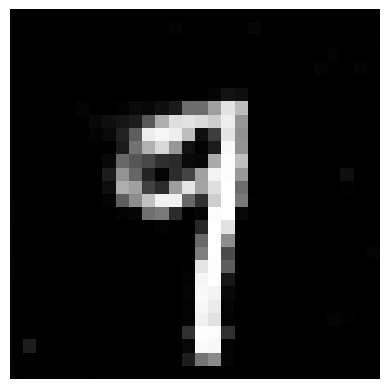

In [37]:
def plot(img):
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

for _ in range(10):
    test_model = noise(1)
    fake_image = generator(test_model)
    print(discriminator(fake_image))
    plot(vec_to_imgs(fake_image).data.cpu())